In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx
import os.path as osp
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report
from itertools import product


In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()
conf = {
    'font.size': 14.0,
    'axes.grid': True,
    'figure.titlesize': 'x-large',
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
#    'xtick.labelsize': 'medium',
#    'ytick.labelsize': 'medium',
#    'legend.fontsize': 'medium',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
}

plt.rcParams.update(conf)


In [3]:
# cleaned data are good for user anylysis but not for anime analysis. For users, around 200k animelist records were discarded, over 30m records remainded.
from pandas.io.common import _NA_VALUES
na_values = _NA_VALUES - {'NULL', 'null', 'nan', 'NaN'}

animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv', na_values=na_values, keep_default_na=False)
animelists = pd.read_csv('animelists_cleaned.csv', na_values=na_values, keep_default_na=False)

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
users['age'] = 2018 - users['birth_date'].dt.year   # fix this to be more robust and precise

In [7]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing  ...           broadcast  \
anime_id                                     ...                       
11013           12  Finished Airing   False  ...  Fridays at Unknown   
2104            26  Finished Airing   False  ...             Unknown   
5262            51  Finished Airing   False  ...             Unknown   
721             38  Finished Airing   False  ...  Fridays at Unknown   
12365           25  Finished Airing   False  ...             Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsuko Okazaki']   
12365     ['#1: "Moshimo no Hanashi (もしもの話)" by nano.RIP...   

                                               ending_theme  duration_min  

In [8]:
animelists.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        59                   26    0000-00-00     0000-00-00   
2  karthiga        74                   26    0000-00-00     0000-00-00   
3  karthiga       120                   26    0000-00-00     0000-00-00   
4  karthiga       178                   26    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         7          2            NaN                 0 2013-03-10 13:54:51   
2         7          2            NaN                 0 2013-04-27 16:43:35   
3         7          2            NaN                 0 2013-03-03 10:53:57   
4         7          2            0.0                 0 2013-03-27 15:59:13   

  my_tags  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [9]:
users.head()

user_id  user_watching  user_completed  user_onhold  \
username                                                              
karthiga        2255153              3              49            1   
Damonashu         37326             45             195           27   
bskai            228342             25             414            2   
terune_uzumaki   327311              5               5            0   
Bas_G           5015094             35             114            6   

                user_dropped  user_plantowatch  user_days_spent_watching  \
username                                                                   
karthiga                   0                 0                 55.091667   
Damonashu                 25                59                 82.574306   
bskai                      5                11                159.483333   
terune_uzumaki             0                 0                 11.394444   
Bas_G                     20               175                 30.458333   

                gender             location birth_date  access_rank  \
username                                                              
karthiga        Female      Chennai, India  1990-04-29          NaN   
Damonashu         Male     Detroit,Michigan 1991-08-01          NaN   
bskai             Male      Nayarit, Mexico 1990-12-14          NaN   
terune_uzumaki  Female    Malaysia, Kuantan 1998-08-24          NaN   
Bas_G             Male  Nijmegen, Nederland 1999-10-24          NaN   

                join_date         last_online  stats_mean_score  \
username                                                          
karthiga       2013-03-03 2014-02-04 01:32:00              7.43   
Damonashu      2008-02-13 2017-07-10 06:52:54              6.15   
bskai          2009-08-31 2014-05-12 16:35:00              8.27   
terune_uzumaki 2010-05-10 2012-10-18 19:06:00              9.70   
Bas_G          2015-11-26 2018-05-10 20:53:37              7.86   

                stats_rewatched  stats_episodes  age  
username                                              
karthiga                    0.0            3391   28  
Damonashu                   6.0            4903   27  
bskai                       1.0            9701   28  
terune_uzumaki              6.0             697   20  
Bas_G                       0.0            1847   19

### comparison of all and active users
Active users are users with some ratings in last 3 months

In [10]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [11]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

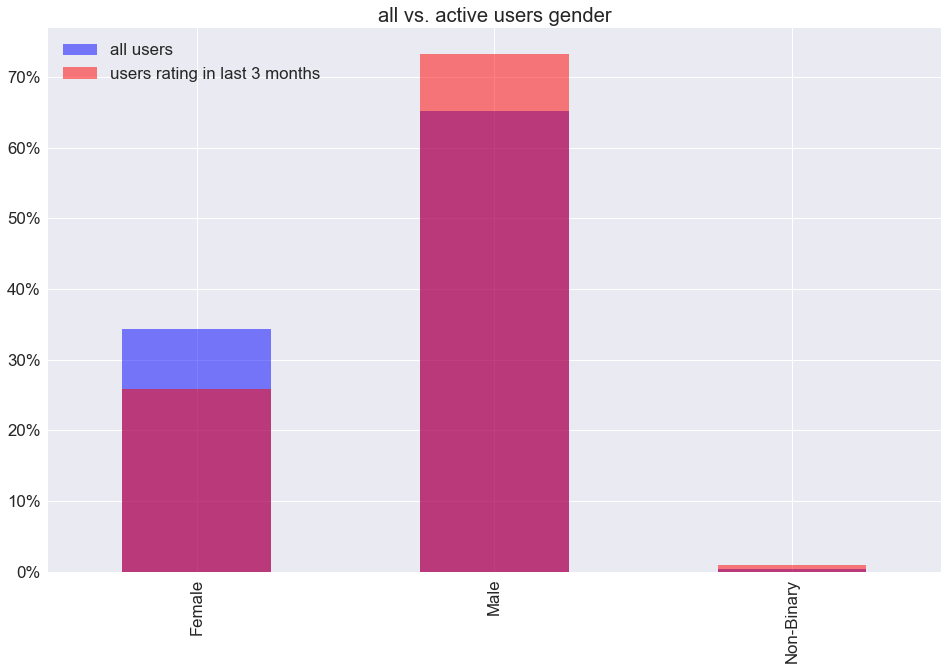

In [12]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

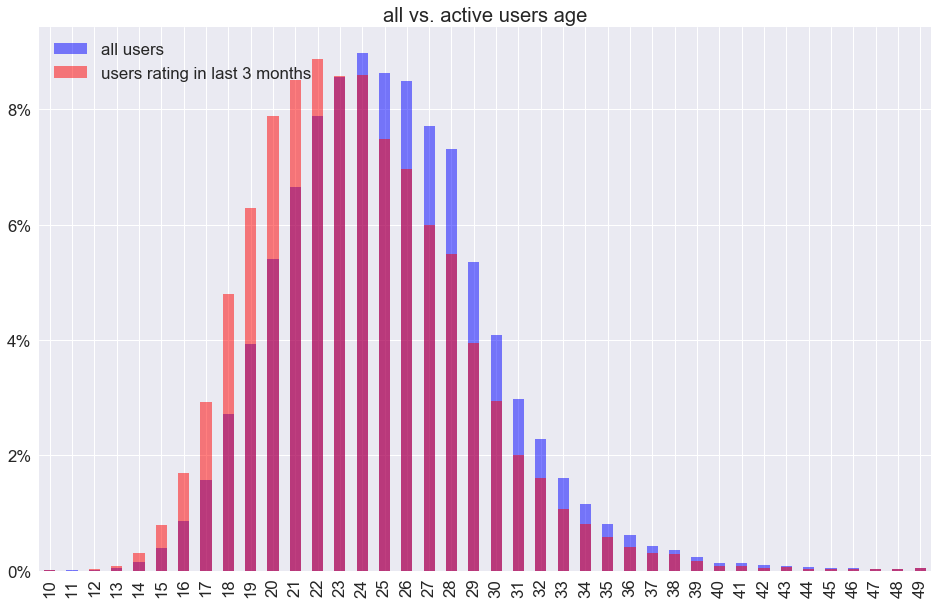

In [13]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

### inspecing seen animes per all genres by age, gender etc.

In [14]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].str.replace(' ', '').str.split(',', expand=True).stack().reset_index(drop=True, level=1).to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
animes_genres = pd.merge(animes, genres_arr, how='inner', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [15]:
# the fastest and safest option (having separate dataframe per each genre is better than one big dataframe)
from joblib import Parallel, delayed
# todo: rewrite all queries using animelists_genres to access dict
def filter_by_genre(animelists, genre):
    print(genre)
    return genre, animelists[animelists.index.isin(genres_arr[genres_arr['genre'] == genre].index)]

res_lists = Parallel(n_jobs=16, backend='threading')(delayed(filter_by_genre)(animelists, genre) for genre in genres_arr['genre'].unique())
animelists_genres = {key: val for key, val in res_lists}

ComedySupernatural
RomanceShounenParody
SchoolMagic


ShoujoDrama
Fantasy


Kids

ActionMusicSliceofLifeJosei


Harem

ShounenAi
Adventure
SuperPower
Sci-Fi
Ecchi
Seinen
MartialArts
GameSports

DemonsHistorical
Horror

Mystery
Psychological
Vampire
Mecha
Military
Space
Samurai
Thriller
Hentai
Yaoi
ShoujoAi
Police
Cars
Dementia
Yuri


In [16]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

In [17]:
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv')
    users = users.set_index('username')
else:
    # handcrafted features
    genres_columns = ['completed_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genre['my_status'] == status['completed']
        users[genre_column] = animelists_genre[completed].groupby('username')['anime_id'].count()
    
    genres_columns = ['dropped_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        dropped = animelists_genre['my_status'] == status['dropped']
        users[genre_column] = animelists_genre[dropped].groupby('username')['anime_id'].count()
    
    genres_columns = ['meanscore_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        rated = (animelists_genre['my_score'] != 0)
        completed = animelists_genre['my_status'] == status['completed']
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()

    # good score is 9 or higher
    genres_columns = ['scoreabove8_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genre['my_status'] == status['completed']
        rated = animelists_genre['my_score'] > 8
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].count()

    # score is 10
    genres_columns = ['scoreabove9_'+x for x in genres]
    for genre_column, genre in zip(genres_columns, genres):
        animelists_genre = animelists_genres[genre]
        completed = animelists_genre['my_status'] == status['completed']
        rated = animelists_genre['my_score'] > 9
        users[genre_column] = animelists_genre[completed & rated].groupby('username')['my_score'].count()
    
    completed = (animelists['my_status'] == status['completed'])
    dropped = (animelists['my_status'] == status['dropped'])
    rated = (animelists['my_score'] != 0)
    users['all_completed'] = animelists[completed].groupby('username')['anime_id'].count()
    users['all_dropped'] = animelists[dropped].groupby('username')['anime_id'].count()
    users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()
    users['all_rated'] = animelists[completed & rated].groupby('username')['anime_id'].count()

    users.reset_index().to_csv('users_calculated.csv', index=False, sep=',', encoding='utf-8')

In [18]:
animelists_genre

username  anime_id  my_watched_episodes my_start_date  \
1359   MistButterfly       877                   47    0000-00-00   
1496   MistButterfly      6746                   24    0000-00-00   
2169   MistButterfly      9062                    2    0000-00-00   
7748         Akihara      1221                   52    0000-00-00   
8577         Sakurei       894                    1    0000-00-00   
9600      magedgamed     14713                   13    0000-00-00   
10845     magedgamed     34350                   12    0000-00-00   
21521           Nihi     30654                   25    0000-00-00   
28779         lila94     11371                    2    0000-00-00   
31283         Cleaye     22433                    0    0000-00-00   

      my_finish_date  my_score  my_status  my_rewatching  my_rewatching_ep  \
1359      0000-00-00        10          2            0.0                 0   
1496      0000-00-00         9          2            0.0                 0   
2169      0000-00-00         6          2            0.0                 0   
7748      0000-00-00         6          2            NaN                 0   
8577      0000-00-00         3          2            0.0                 0   
9600      0000-00-00         7          2            0.0                 0   
10845     2017-10-19         8          2            0.0                 0   
21521     0000-00-00         7          2            0.0                 0   
28779     0000-00-00         8          3            NaN                 0   
31283     0000-00-00         0          6            NaN                 0   

          my_last_updated       my_tags  
1359  2013-04-26 14:35:49           NaN  
1496  2013-04-26 14:18:42           NaN  
2169  2015-06-24 11:07:34           NaN  
7748  2009-05-01 08:15:32           NaN  
8577  2009-04-26 00:46:02           NaN  
9600  2015-03-21 22:33:27      HEADER,   
10845 2017-10-19 14:06:29  HEADER, lone  
21521 2016-07-29 18:49:44           NaN  
28779 2012-01-13 14:19:20           NaN  
31283 2014-07-16 01:54:36           NaN

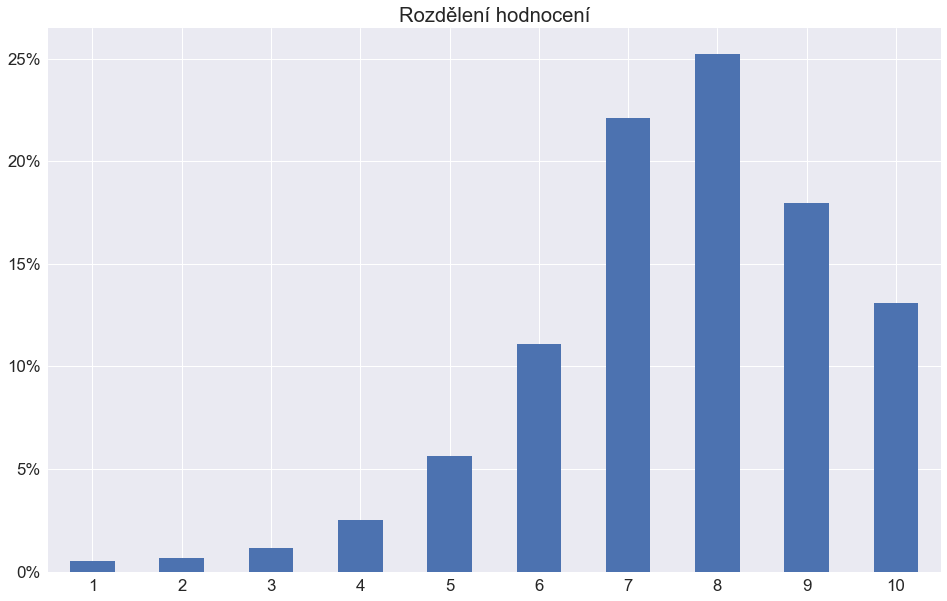

In [19]:
#showing score distribution
scores = animelists[animelists['my_score'] != 0]['my_score'].value_counts()
(scores / scores.sum()).sort_index().plot(kind='bar', figsize=(16, 10), title='Rozdělení hodnocení')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni.png', bbox_inches="tight")

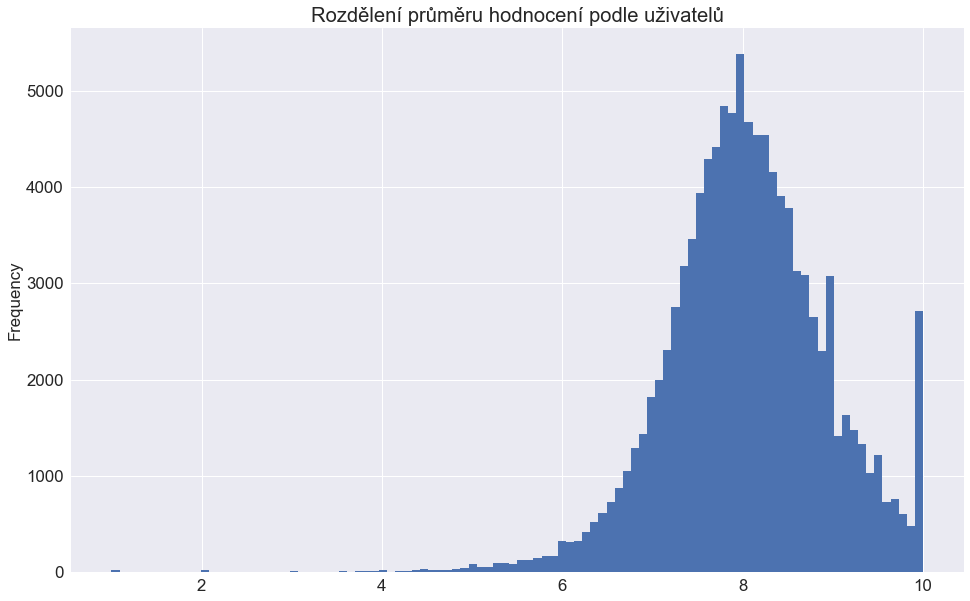

In [20]:
users['all_meanscore'].plot(kind='hist', bins=100, figsize=(16, 10), title='Rozdělení průměru hodnocení podle uživatelů')
plt.xticks(rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni-prumer-histogram.png', bbox_inches="tight")

In [21]:
print('total users:', users['all_meanscore'].count())
print('users with mean score 10:', (users['all_meanscore'] == 10).sum())


total users: 105723
users with mean score 10: 2437


### analyzing users and genres now when I have features for genres per user

In [29]:
completed_columns = sorted(['completed_'+x for x in genres if x != ''])
users[completed_columns] = users[completed_columns].fillna(0)  # without this, NaN values are ommited from mean calculation, which messes up data a lot
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed = users[completed_columns].div(users['all_completed'], axis=0).fillna(0)
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

above8_columns = sorted(['scoreabove8_'+x for x in genres if x != ''])
above9_columns = sorted(['scoreabove9_'+x for x in genres if x != ''])
users[above8_columns] = users[above8_columns].fillna(0)
users[above9_columns] = users[above9_columns].fillna(0)
mean_columns = sorted(['meanscore_'+x for x in genres if x != ''])
users[mean_columns] = users[mean_columns].fillna(0)


In [30]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Text(0.5, 1.0, 'genre percentage in animelists')

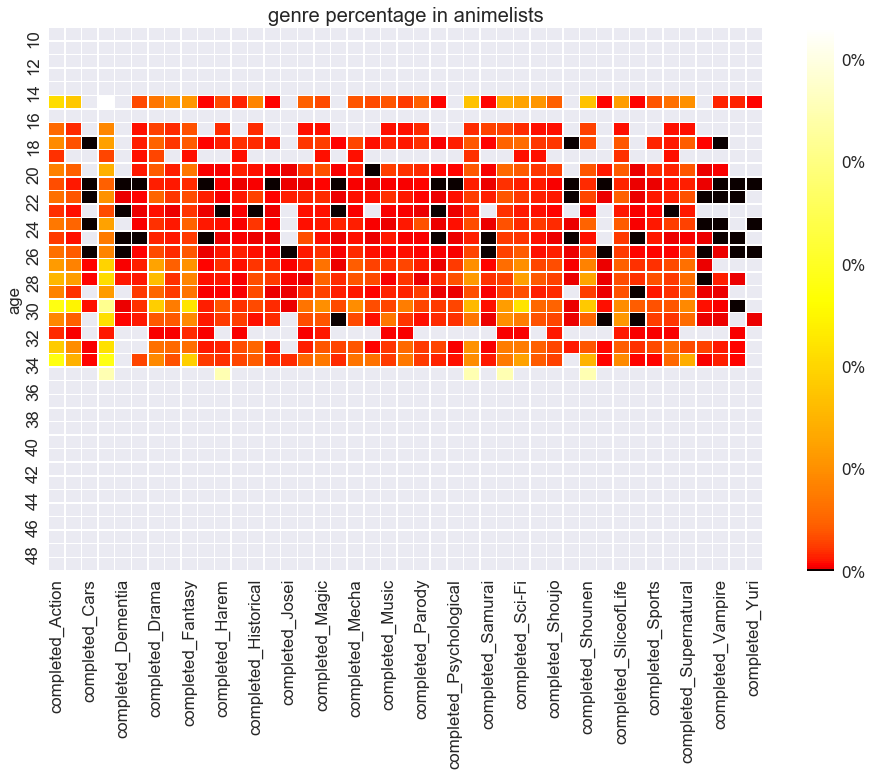

In [31]:
f, ax = plt.subplots(figsize=(16, 10))
#data = ages_genres.div(ages_genres.sum(axis=1), axis=0) * 100
data = ages_genres * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('genre percentage in animelists')

Text(0.5, 1.0, 'histograms normed per genre')

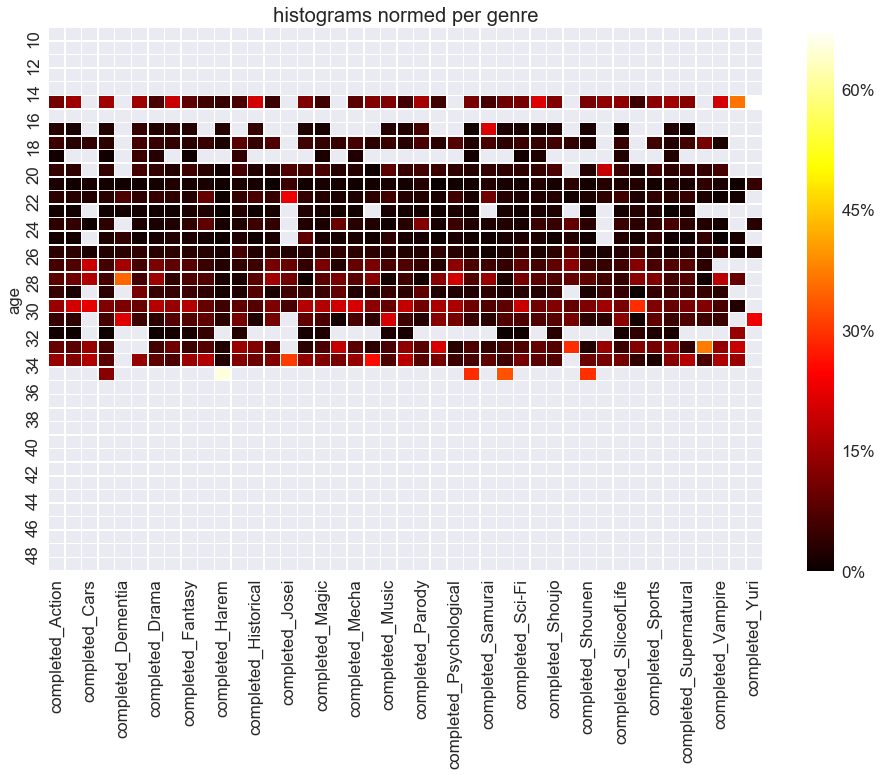

In [32]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
#data = ages_genres * 100
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('histograms normed per genre')

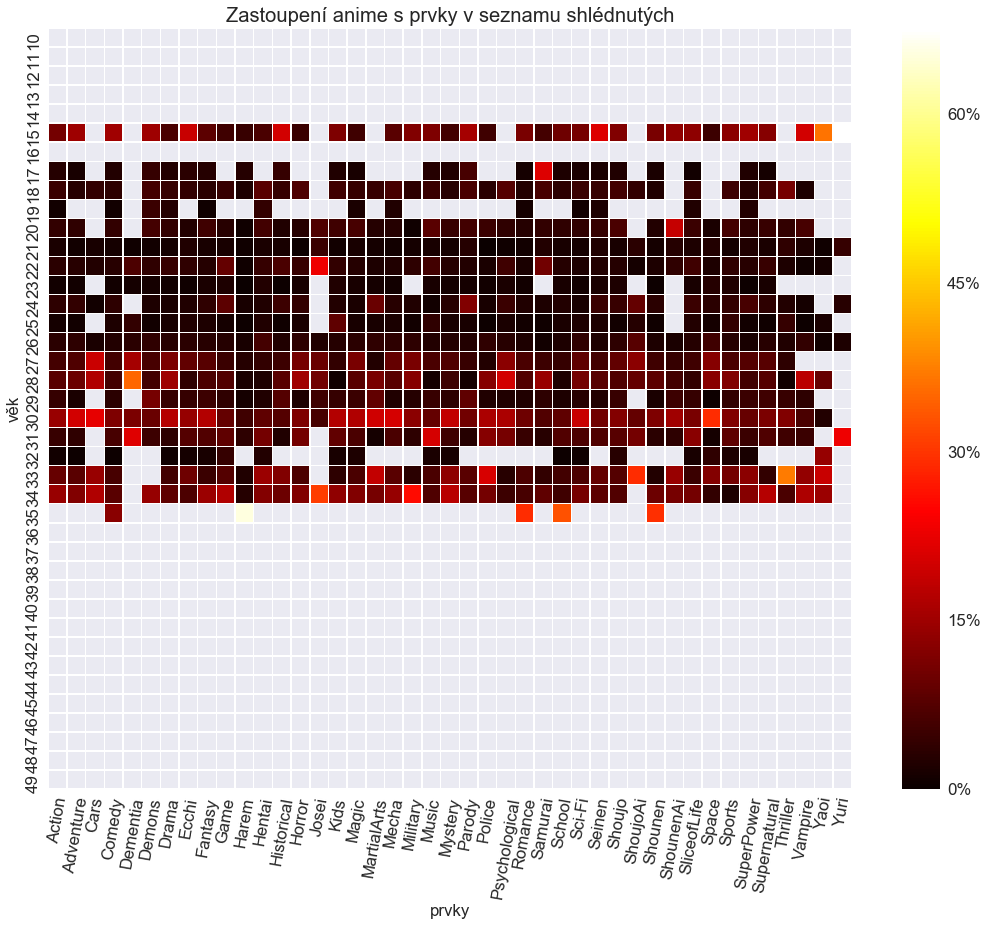

In [33]:
f, ax = plt.subplots(figsize=(18, 14))
renaming = {x: x.replace('completed_', '') for x in completed_columns}
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
data = data.rename(columns=renaming)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=80)
plt.ylabel('věk')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-vek-zanr-heatmap.png', bbox_inches="tight")

In [34]:
users[['all_completed', 'age', 'gender'] + completed_columns]

all_completed  age  gender  completed_Action  \
username                                                         
karthiga                   49.0   28  Female              20.0   
Damonashu                 188.0   27    Male              50.0   
bskai                     378.0   28    Male              58.0   
terune_uzumaki              5.0   20  Female               0.0   
Bas_G                     113.0   19    Male               0.0   
HimeAria                   84.0   22  Female               0.0   
Skallington                 3.0   27    Male               0.0   
Slimak                    222.0   30    Male              71.0   
Elysiun                     4.0   34    Male               0.0   
jimothy000                  NaN   23    Male               0.0   
MistButterfly            3011.0   26  Female             455.0   
ProperBritish             225.0   26    Male               0.0   
kioniel                   405.0   30    Male              25.0   
Xinil                     213.0   33    Male              19.0   
helenply                  184.0   19  Female               0.0   
hood_rad                  309.0   21    Male               0.0   
detestedlove311            29.0   29  Female               0.0   
ihasabucket               145.0   34    Male              10.0   
xTheFallenx               608.0   25    Male              34.0   
L-LawlietDN                 NaN   23    Male               0.0   
zZKinhoZz                  65.0   18    Male               0.0   
glittermilk                33.0   24  Female               0.0   
Lithuelle                 139.0   33  Female              10.0   
scootarski                252.0   34    Male              21.0   
Yukia-Kontan               12.0   28    Male               0.0   
Akihara                   586.0   24  Female              16.0   
Tomoki-sama               334.0   22    Male              13.0   
Sakurei                   594.0   15  Female              27.0   
raickos                   166.0   29    Male               0.0   
Spike                     341.0   24  Female               0.0   
...                         ...  ...     ...               ...   
NessaIero                 235.0   23  Female               0.0   
TsuyoiTamashi231          266.0   20    Male               0.0   
Falco2424                 128.0   24    Male               0.0   
Theasn                    144.0   22    Male               0.0   
Ray0flight                 27.0   23    Male               0.0   
adultswimfan88             34.0   30    Male               0.0   
Doraka                     26.0   21    Male               0.0   
BlackRockShtr              98.0   18    Male               0.0   
Sadpanda                  243.0   39    Male               0.0   
FateMaster                508.0   26    Male               0.0   
xsxeotakux                  6.0   27    Male               0.0   
Perzik                     90.0   21  Female               0.0   
Tenos                     125.0   25    Male               0.0   
Destiney                   62.0   26  Female               0.0   
Lost_Bullet                71.0   27  Female               0.0   
alesos                     70.0   31    Male               0.0   
Jarlath7                  361.0   22    Male               0.0   
M_Northstar                38.0   44    Male               0.0   
ZnamJendrka               223.0   19    Male               0.0   
kvothe96_                 317.0   22    Male               0.0   
Dusty9797                  86.0   21    Male               0.0   
assassin0202              178.0   27    Male               0.0   
ZeroFr3aK                 178.0   25    Male               0.0   
yoyoman9                   32.0   19    Male               0.0   
generalist                184.0   30    Male               0.0   
isoann                    208.0   21    Male               0.0   
bumcakee                  116.0   20  Female               0.0   
Scarlet95                 103.0   23  Female              

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


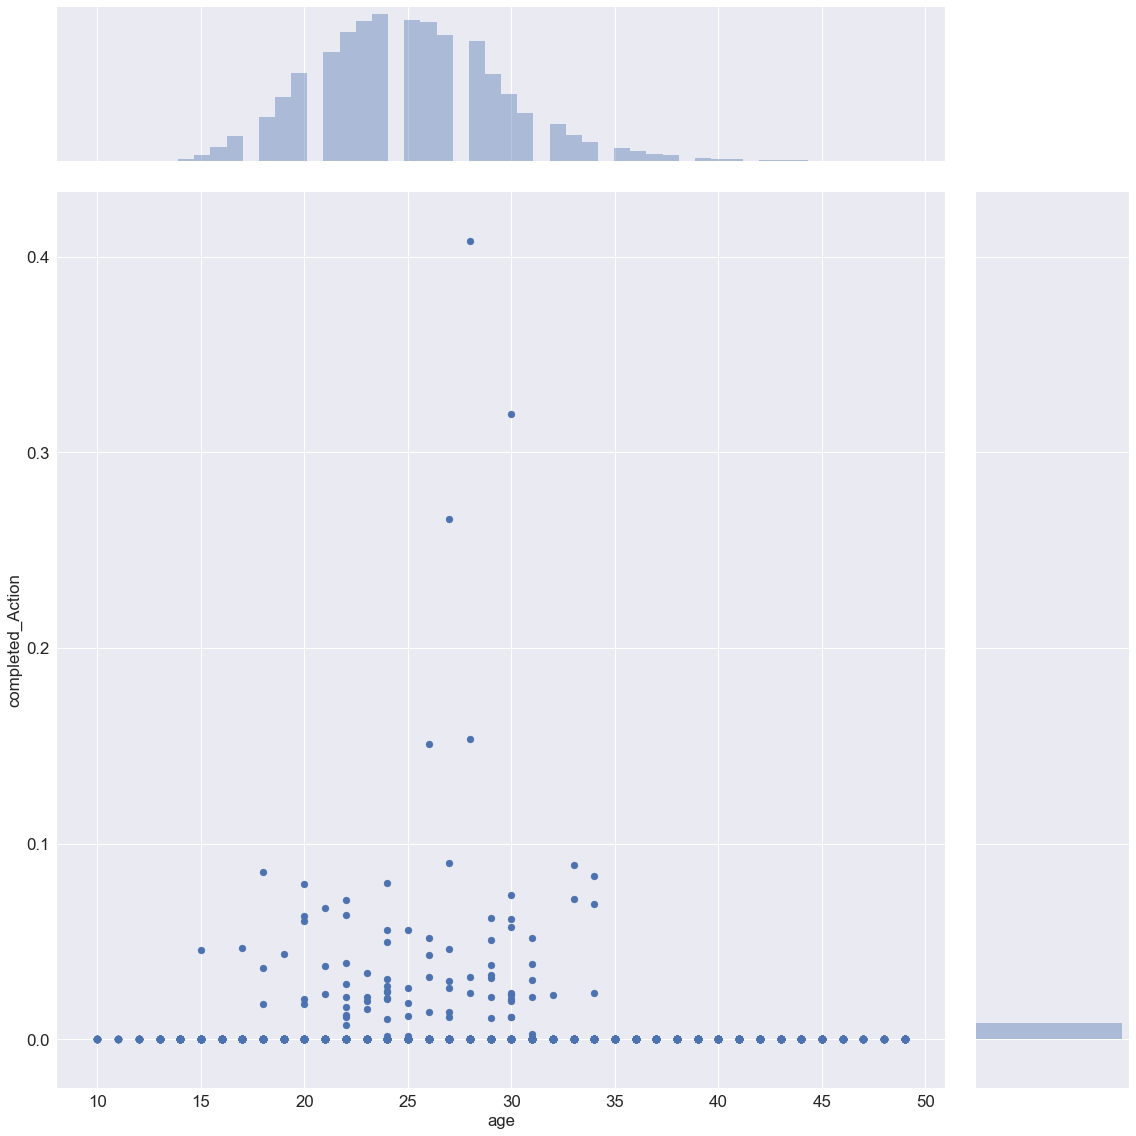

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


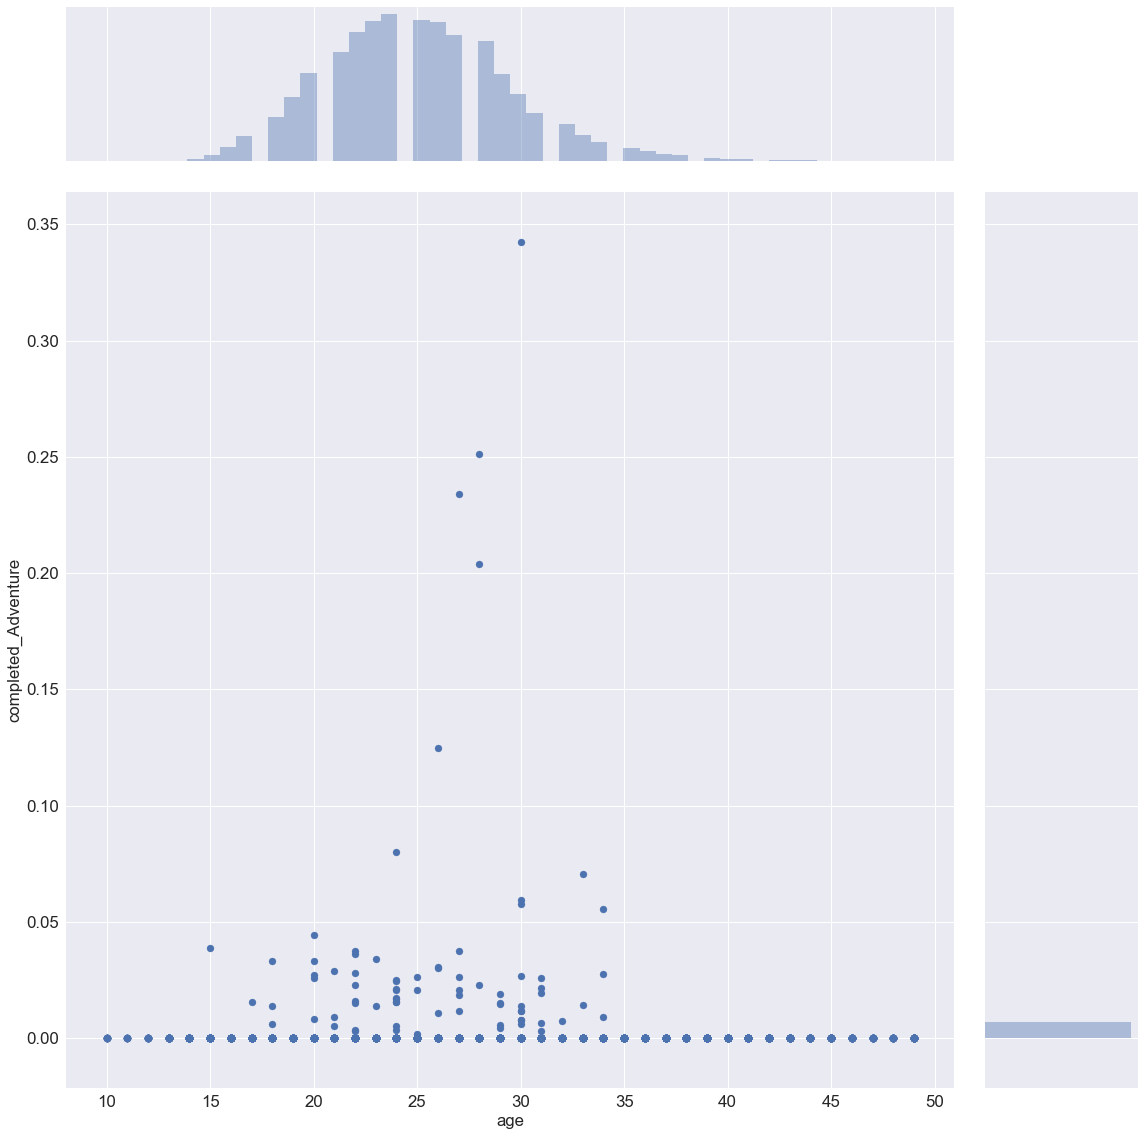

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


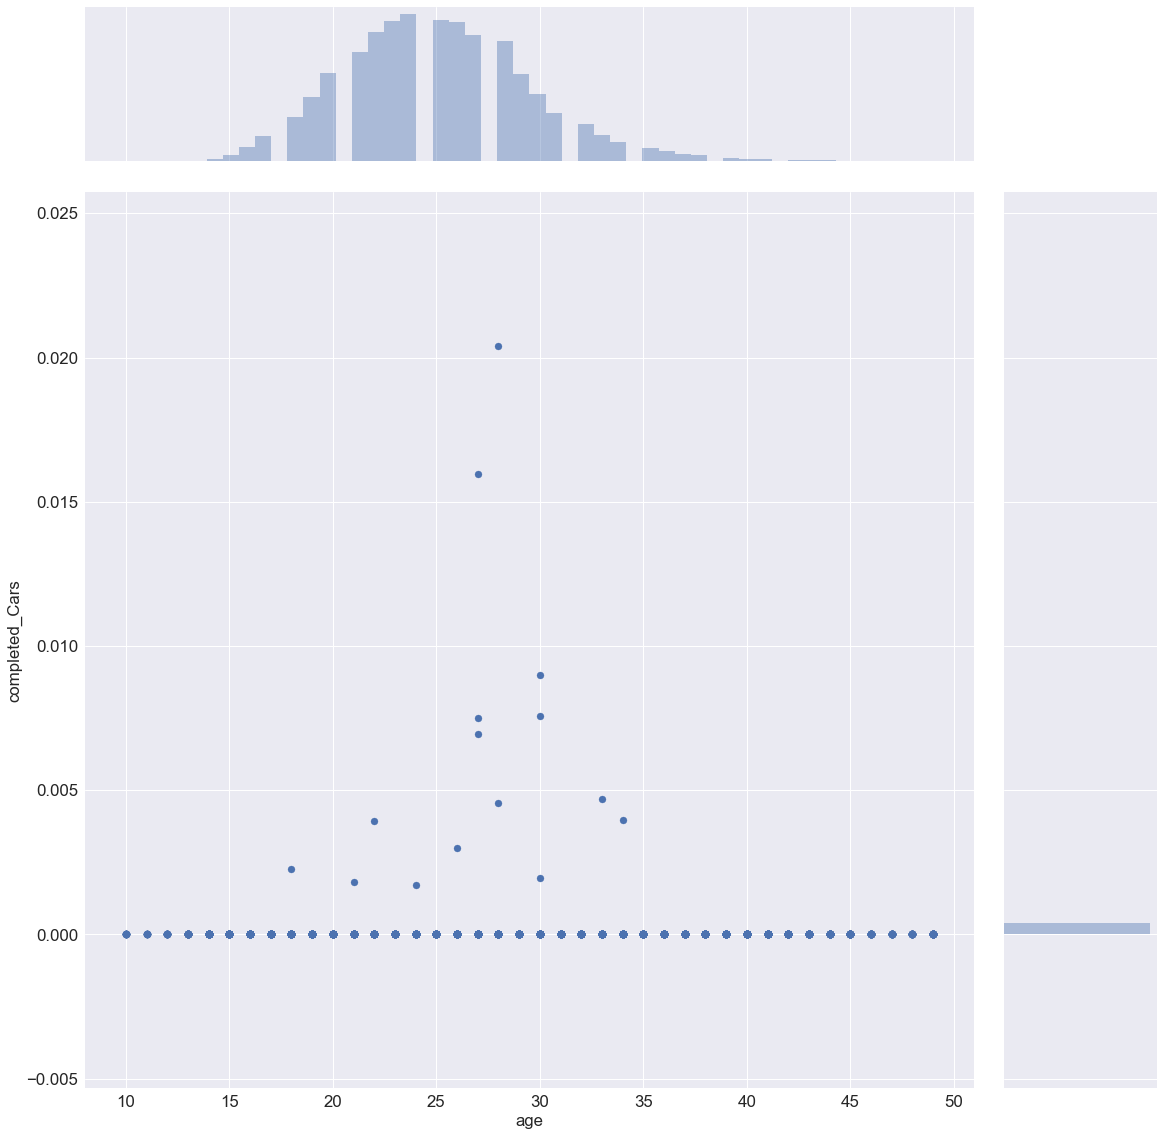

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


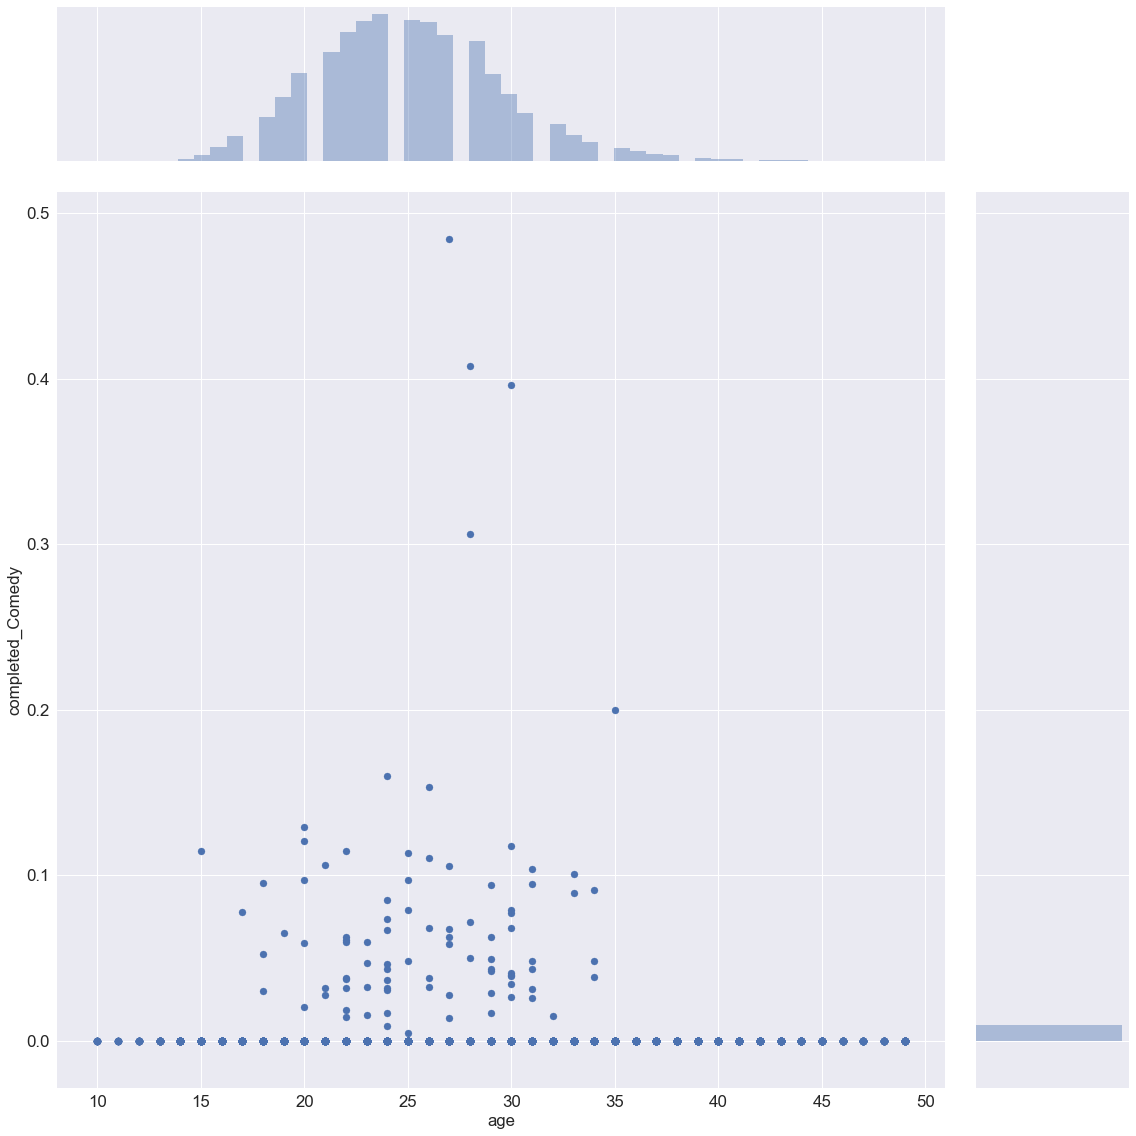

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


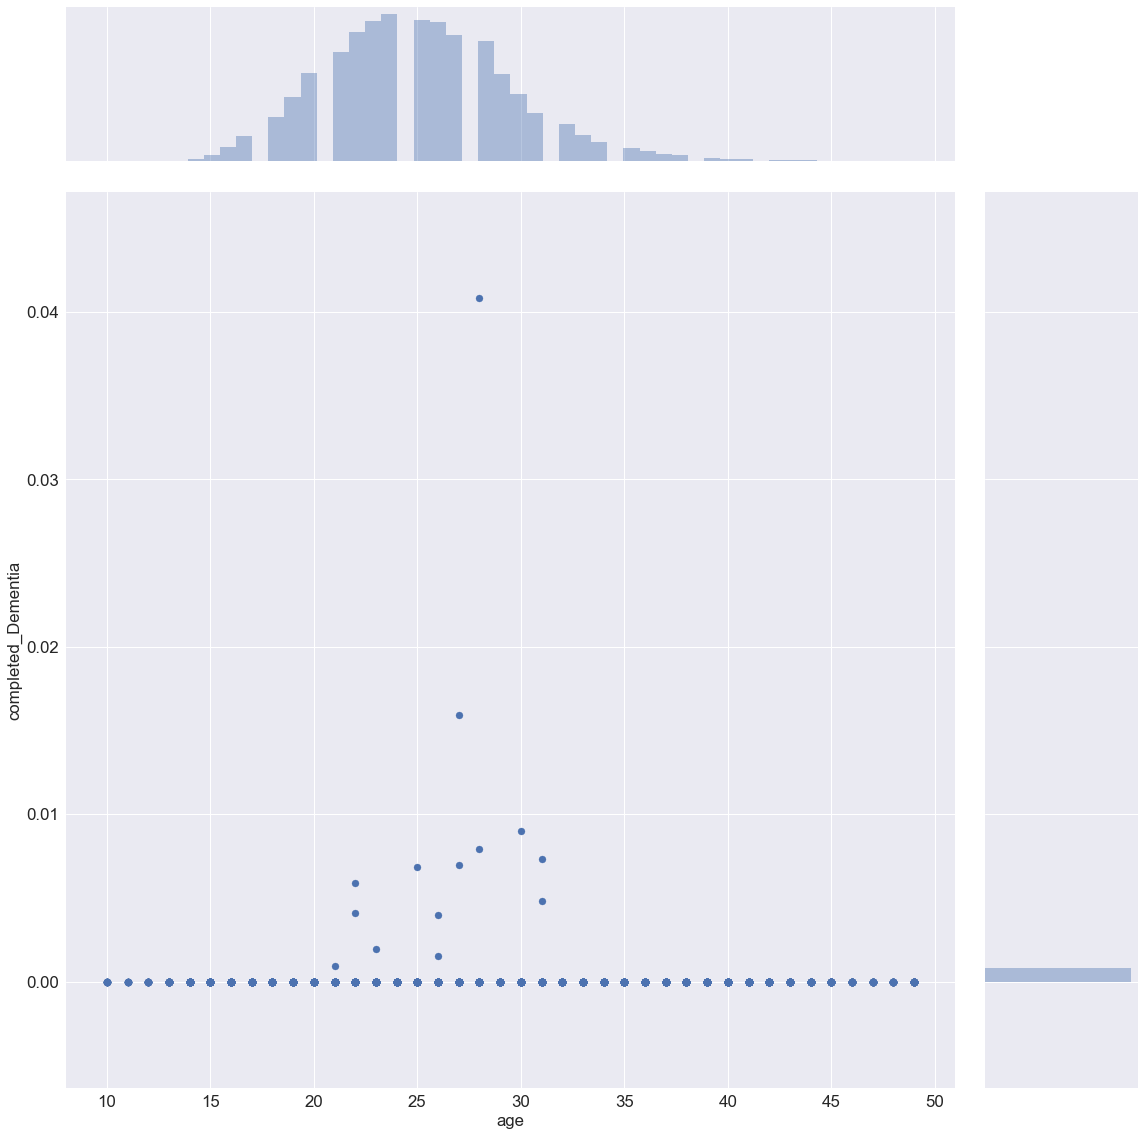

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


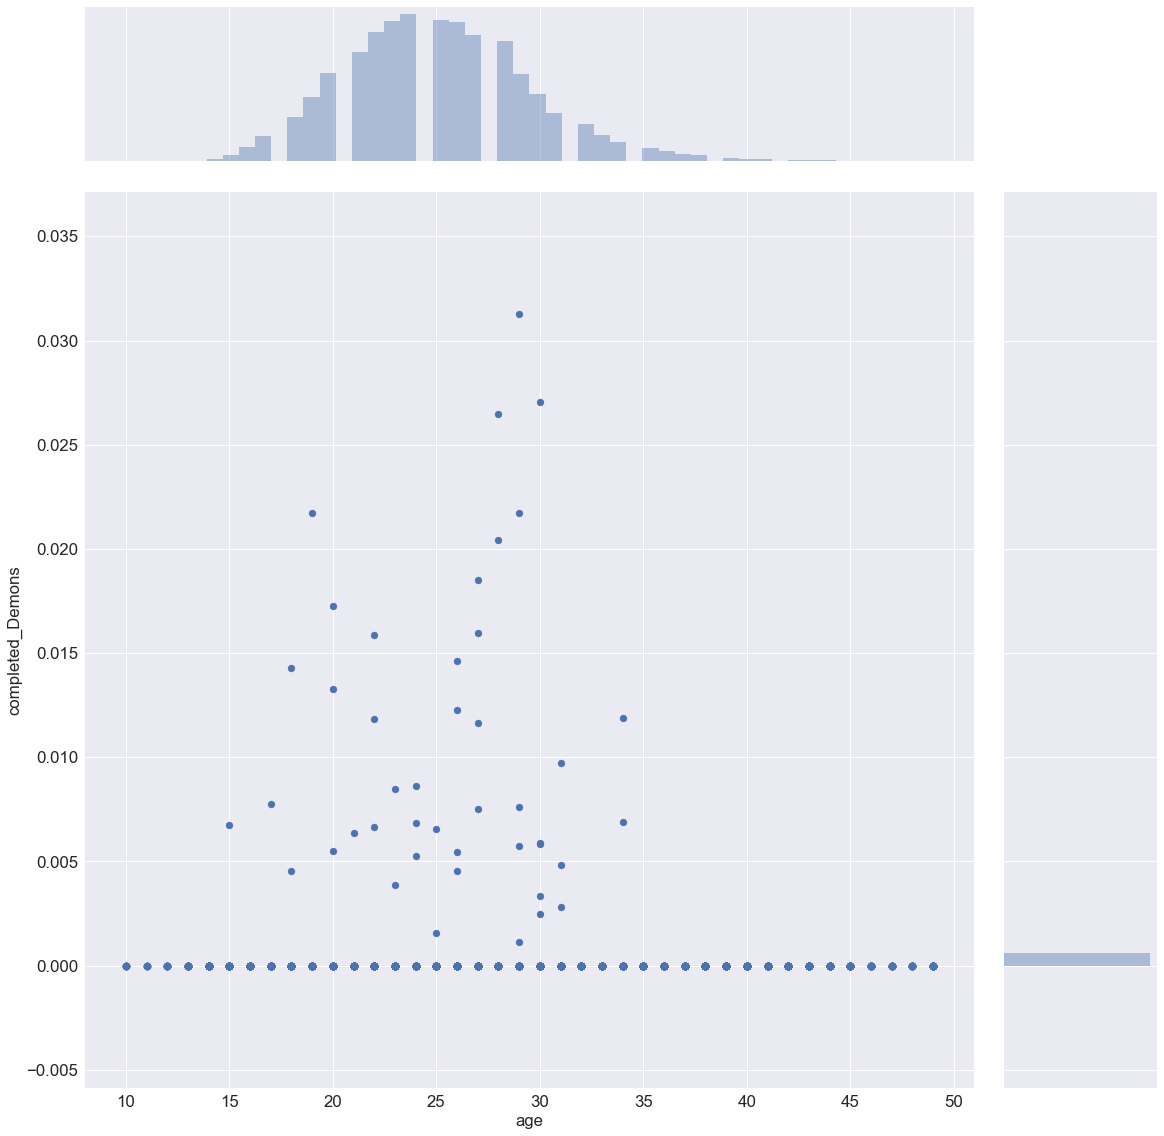

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


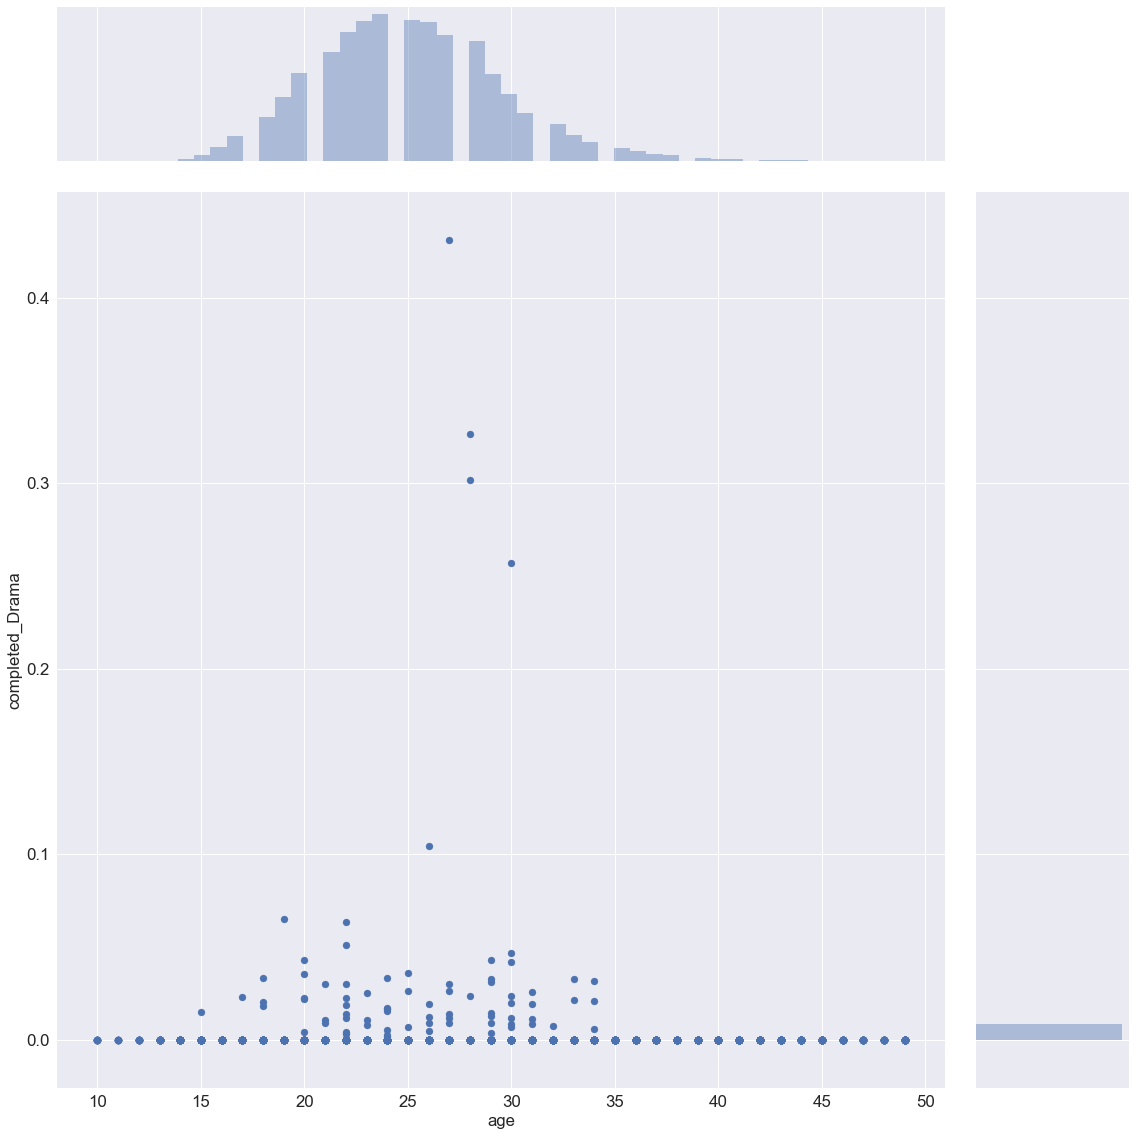

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


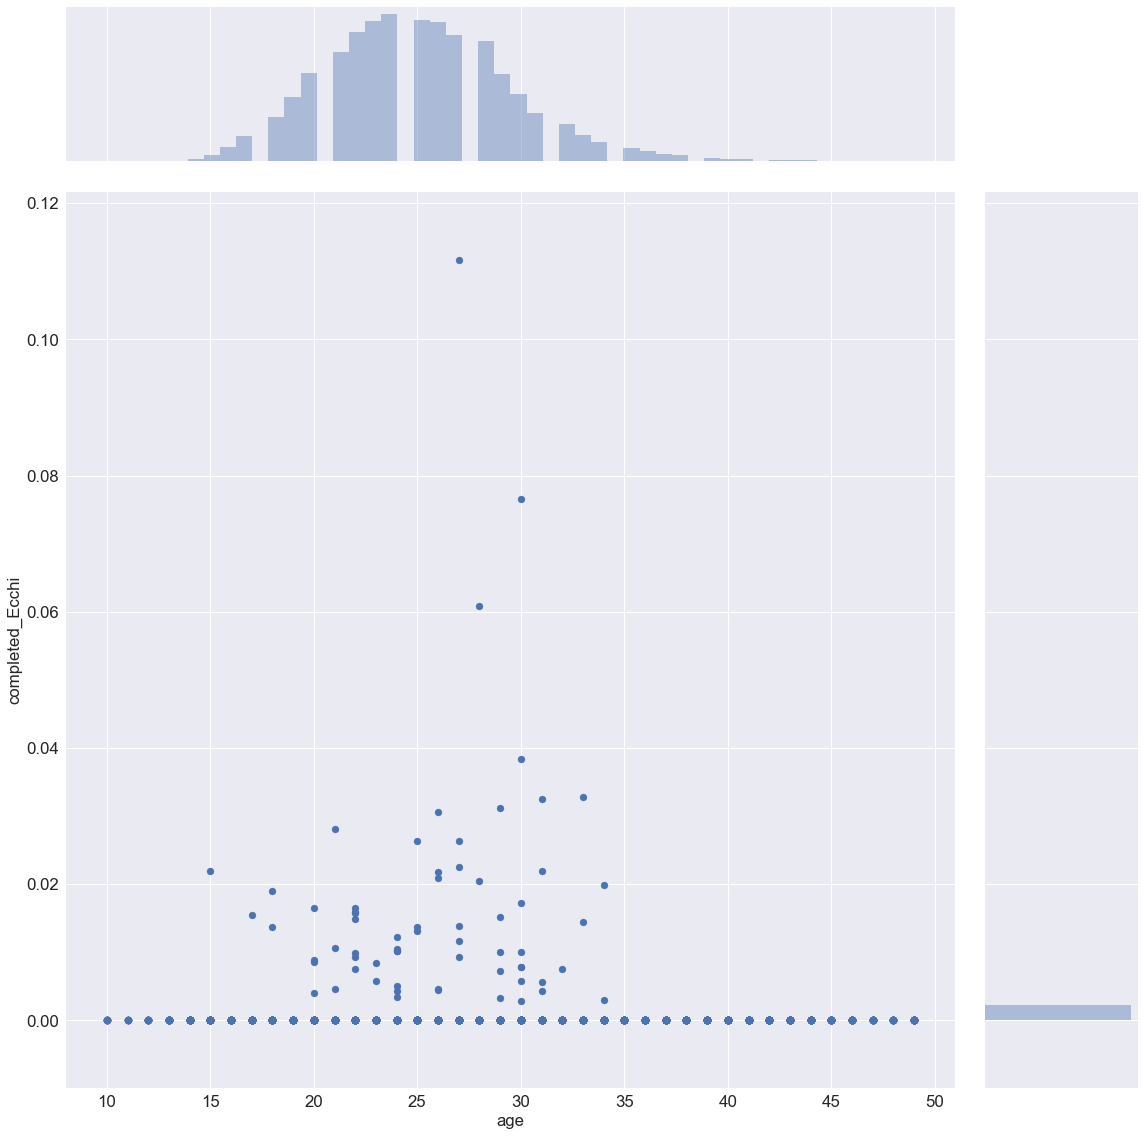

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


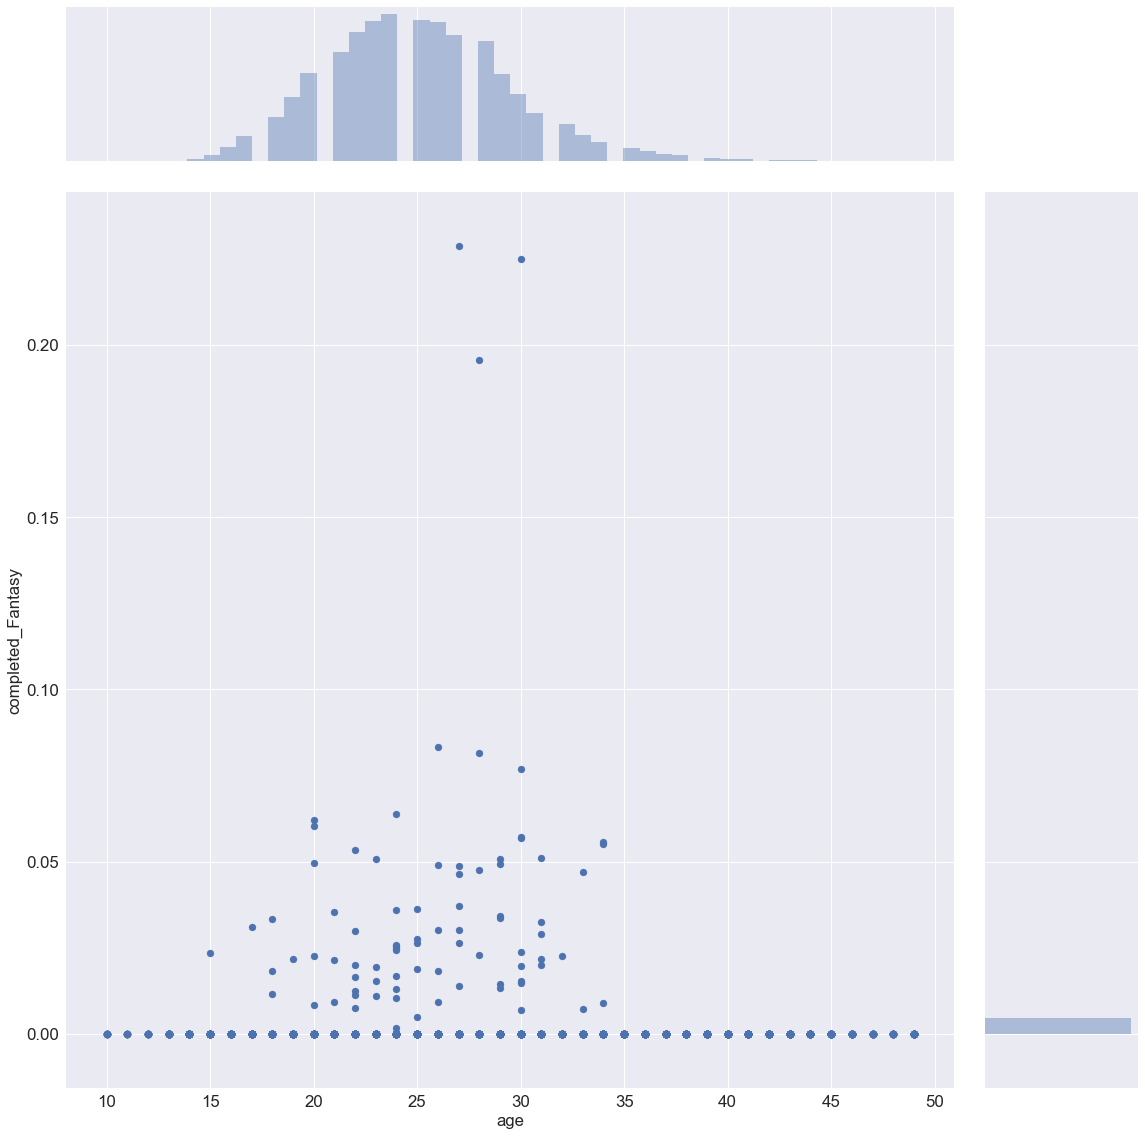

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


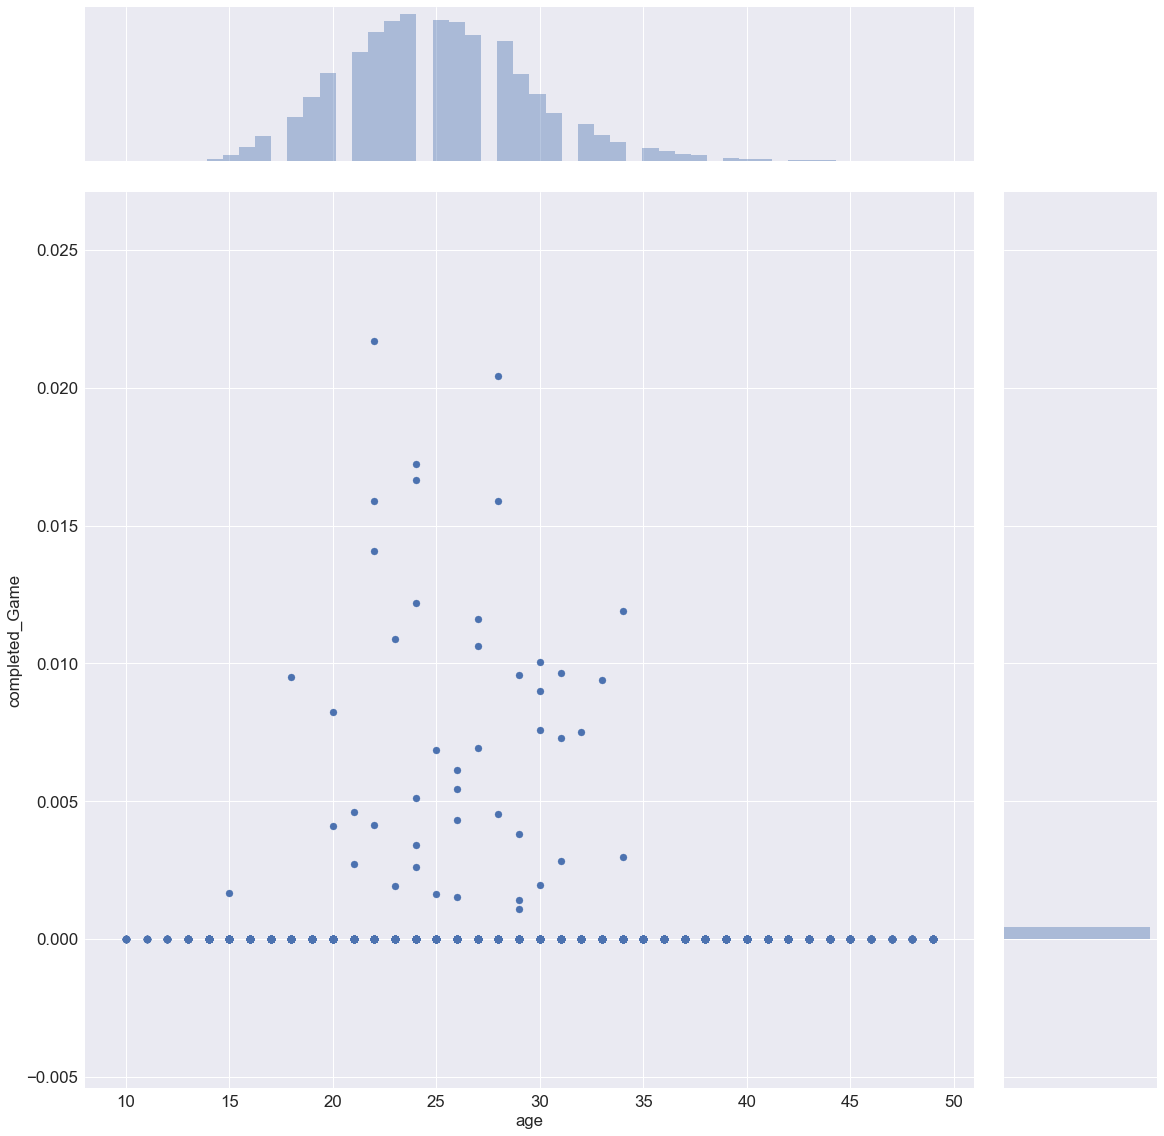

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


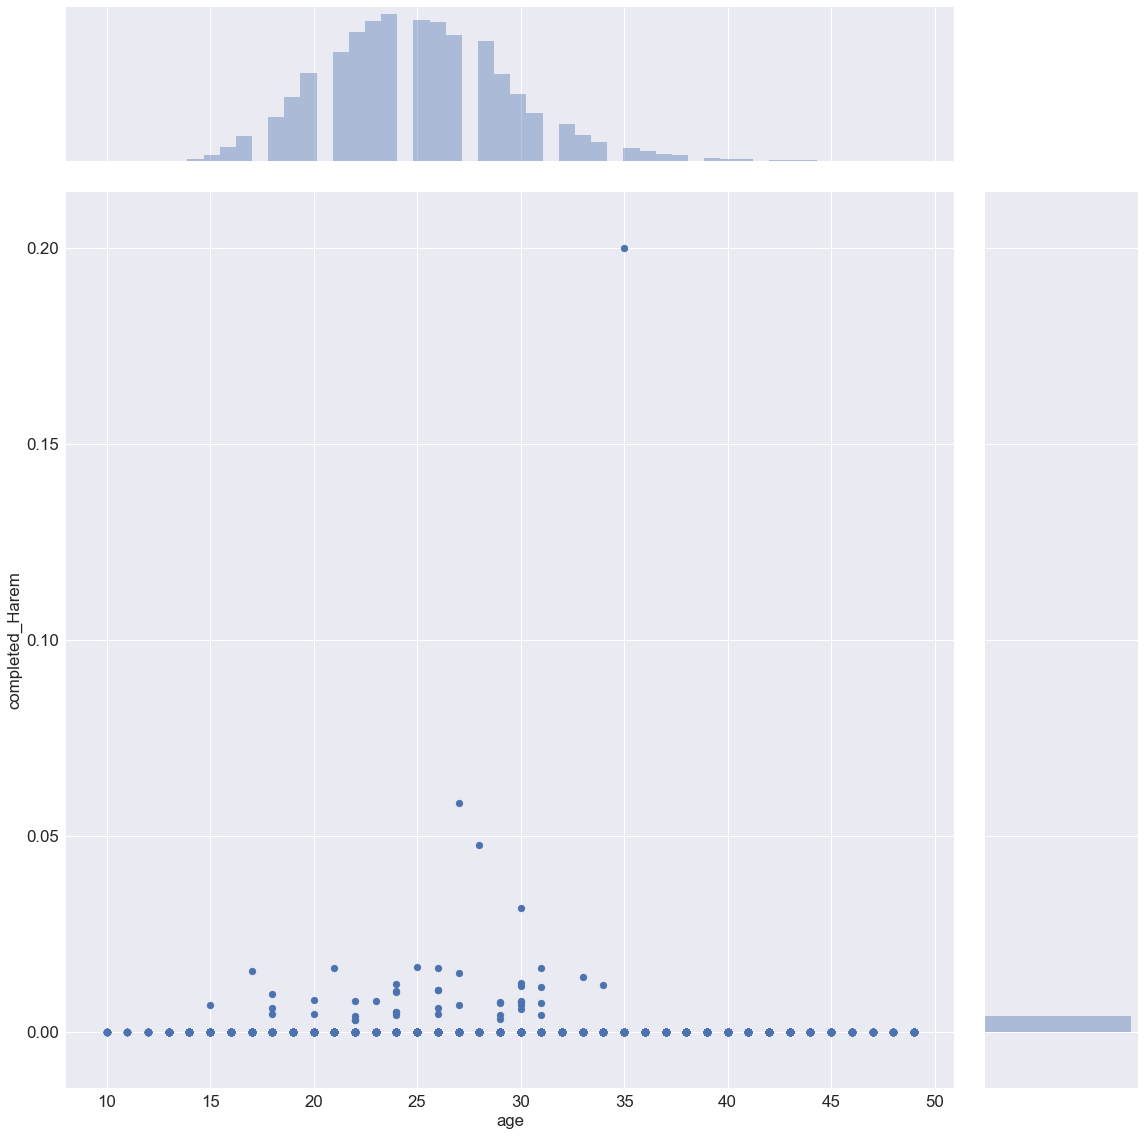

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


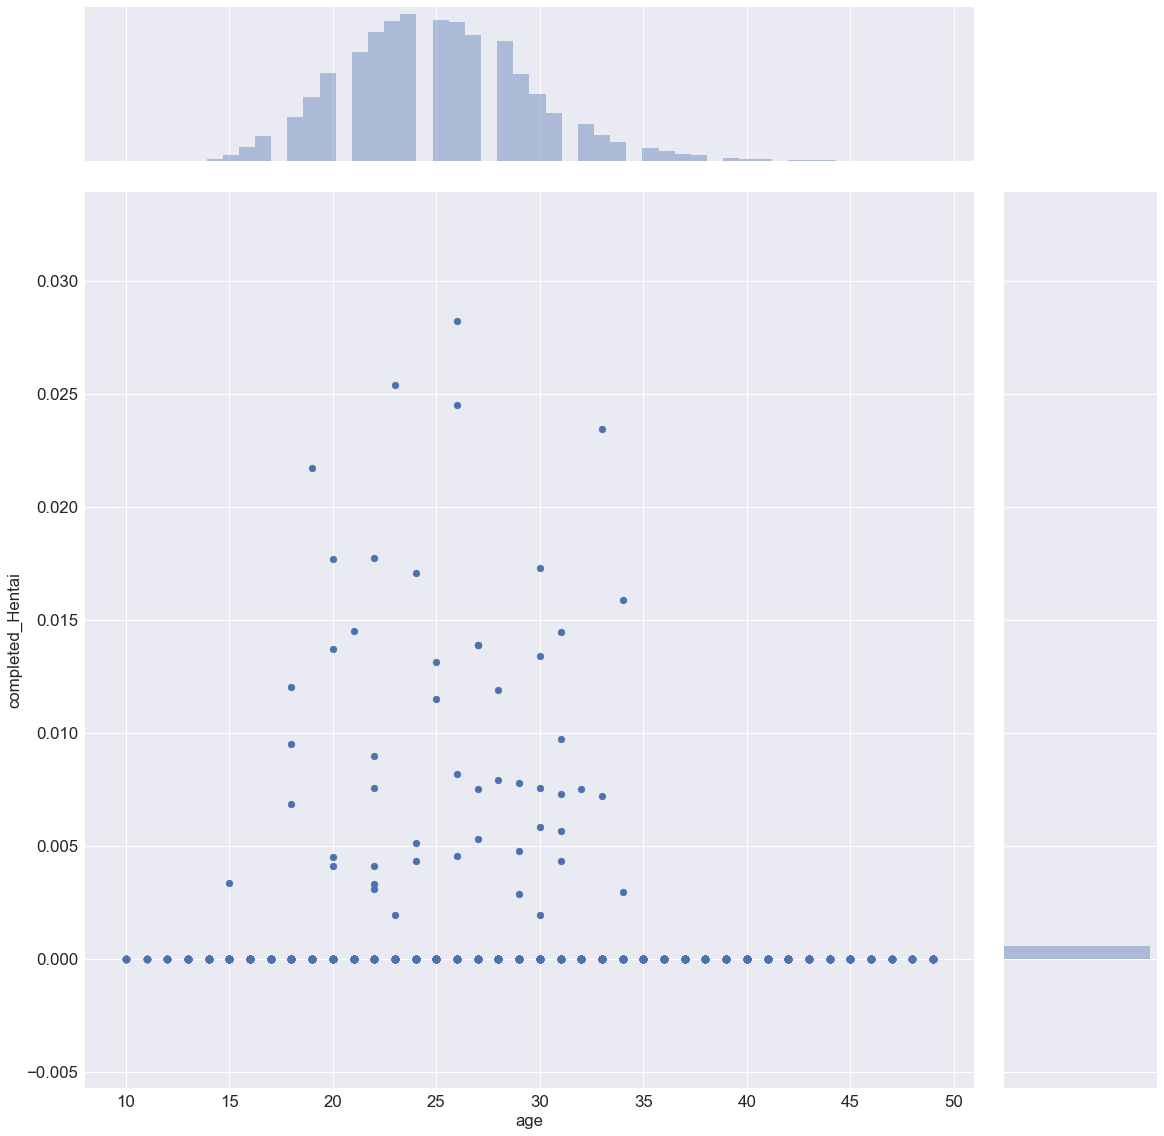

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


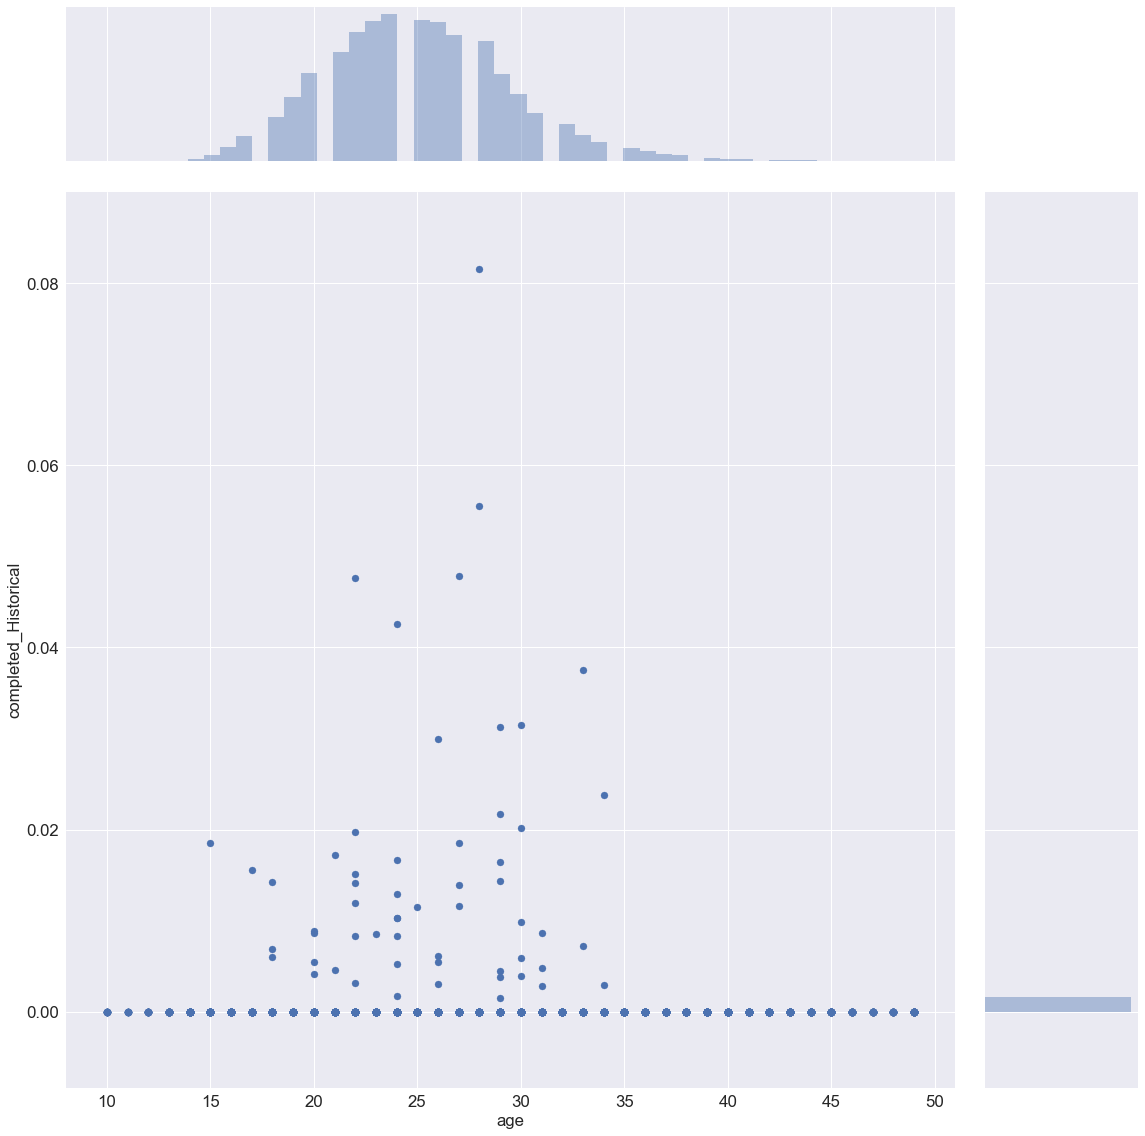

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


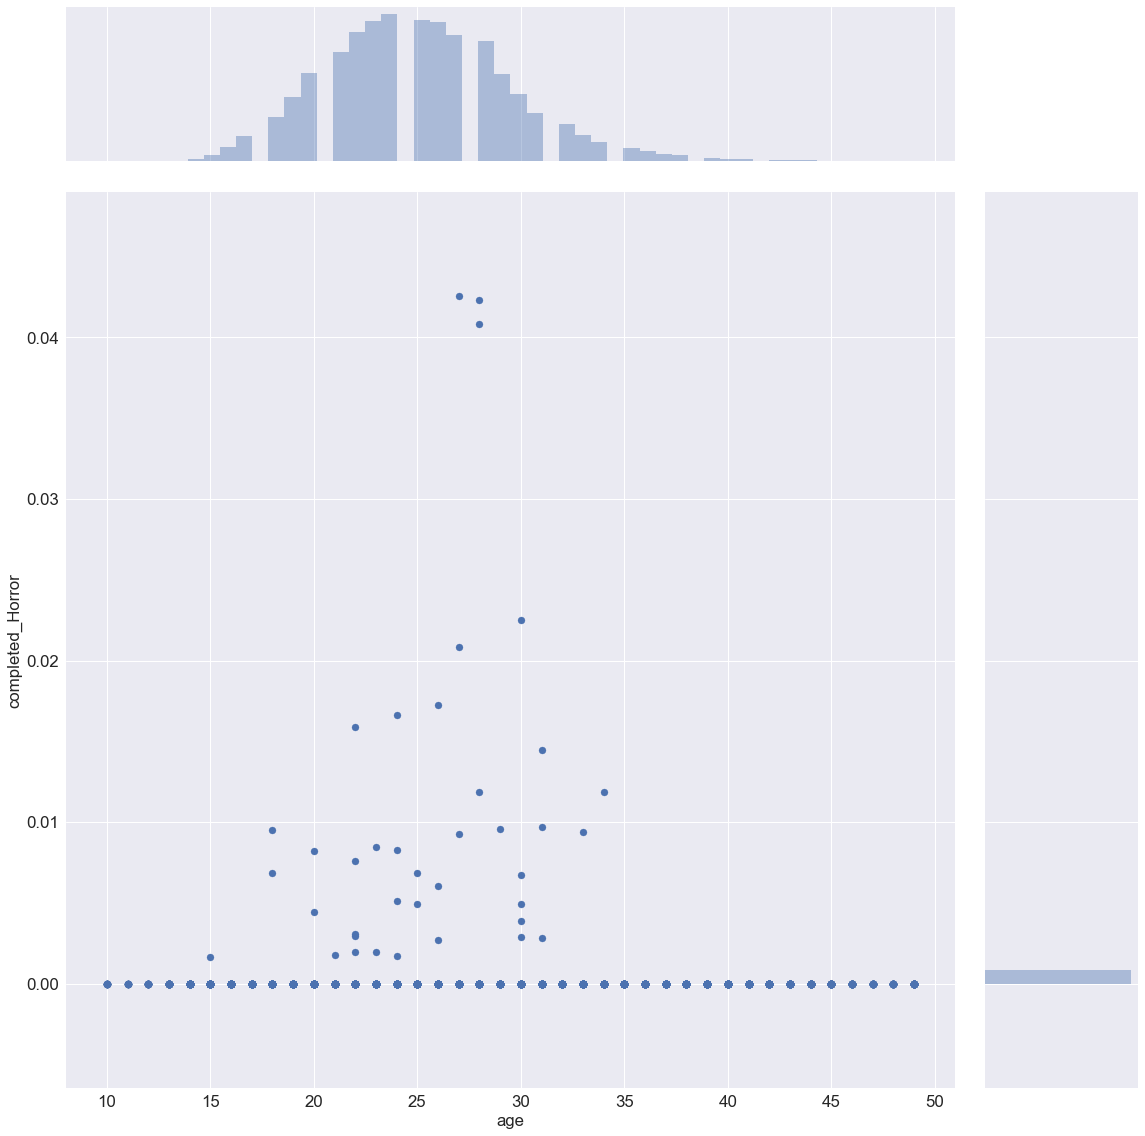

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


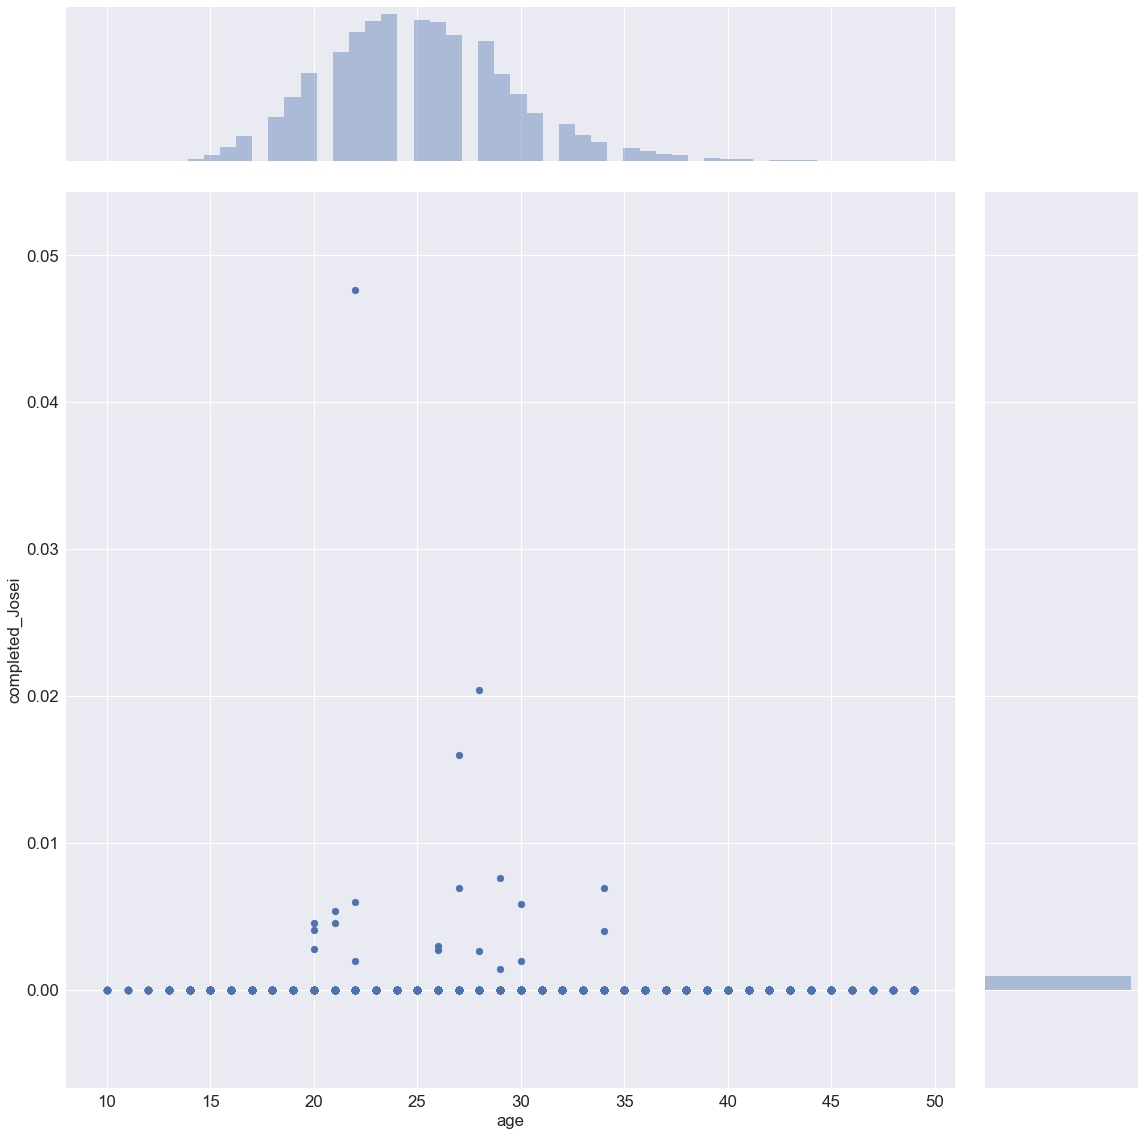

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


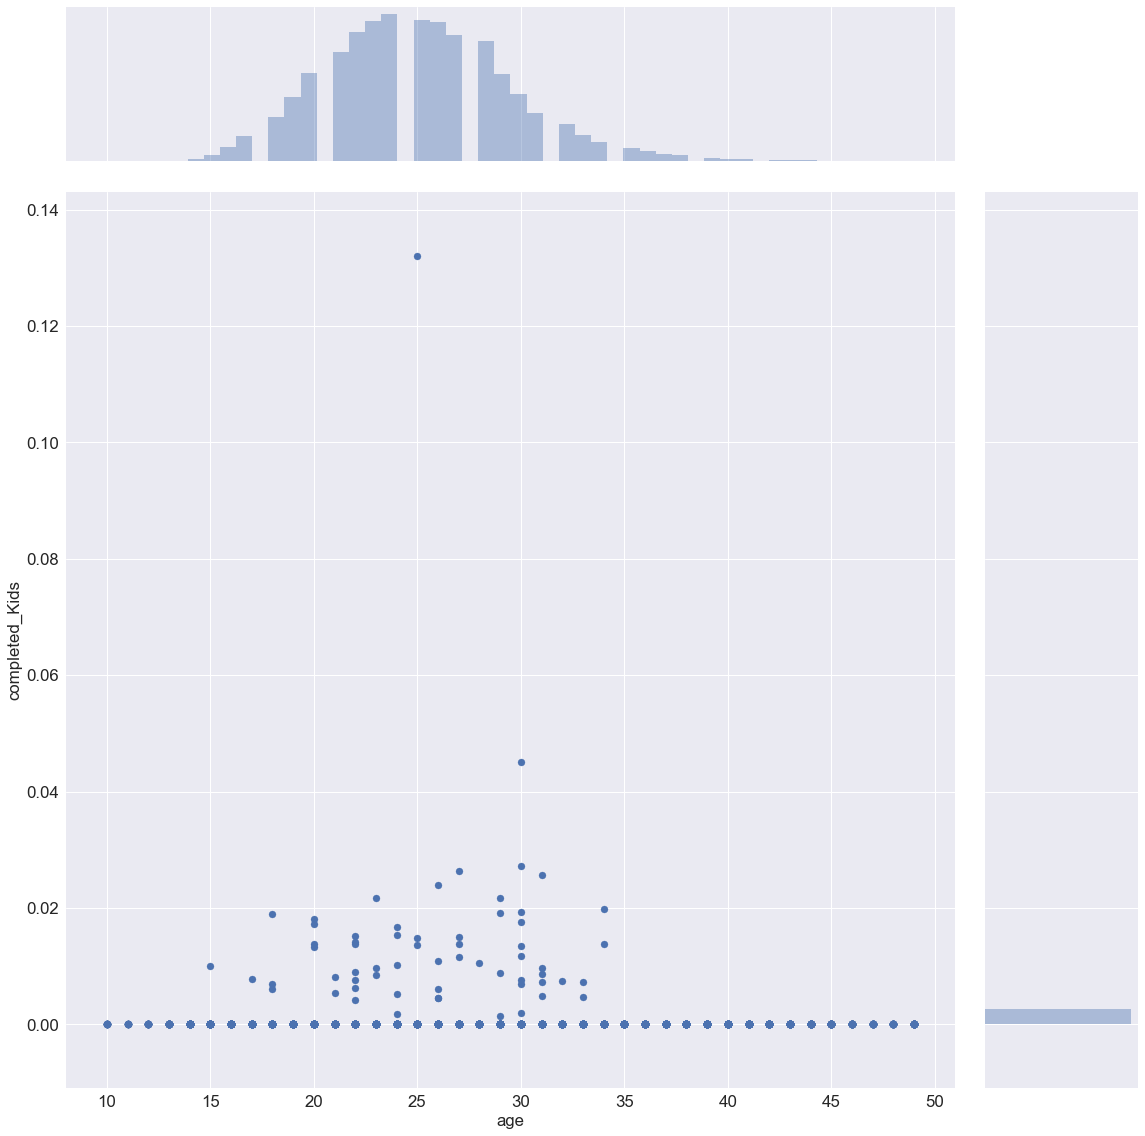

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


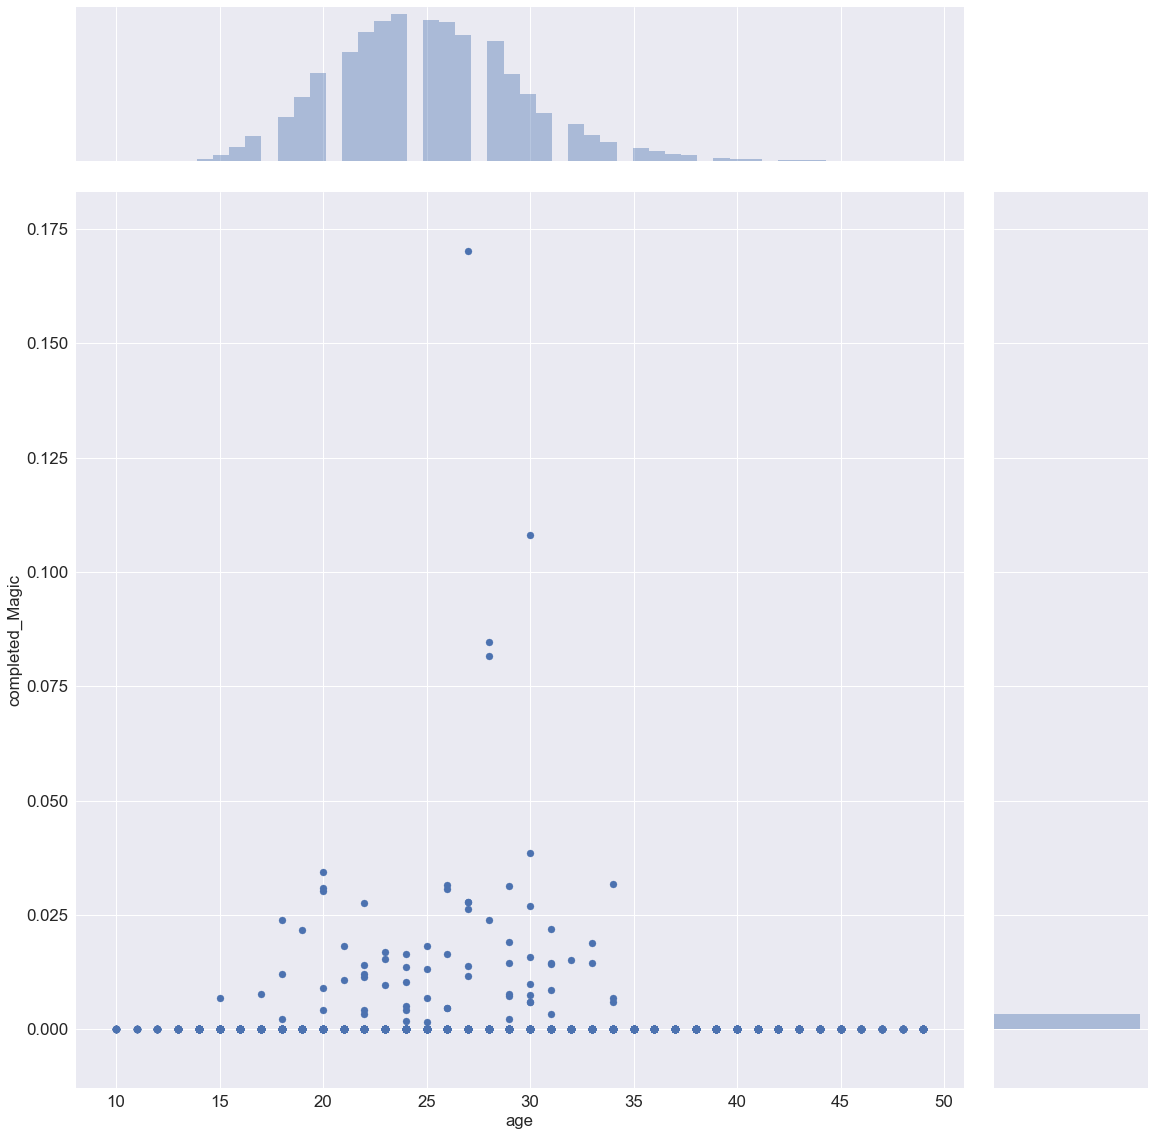

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


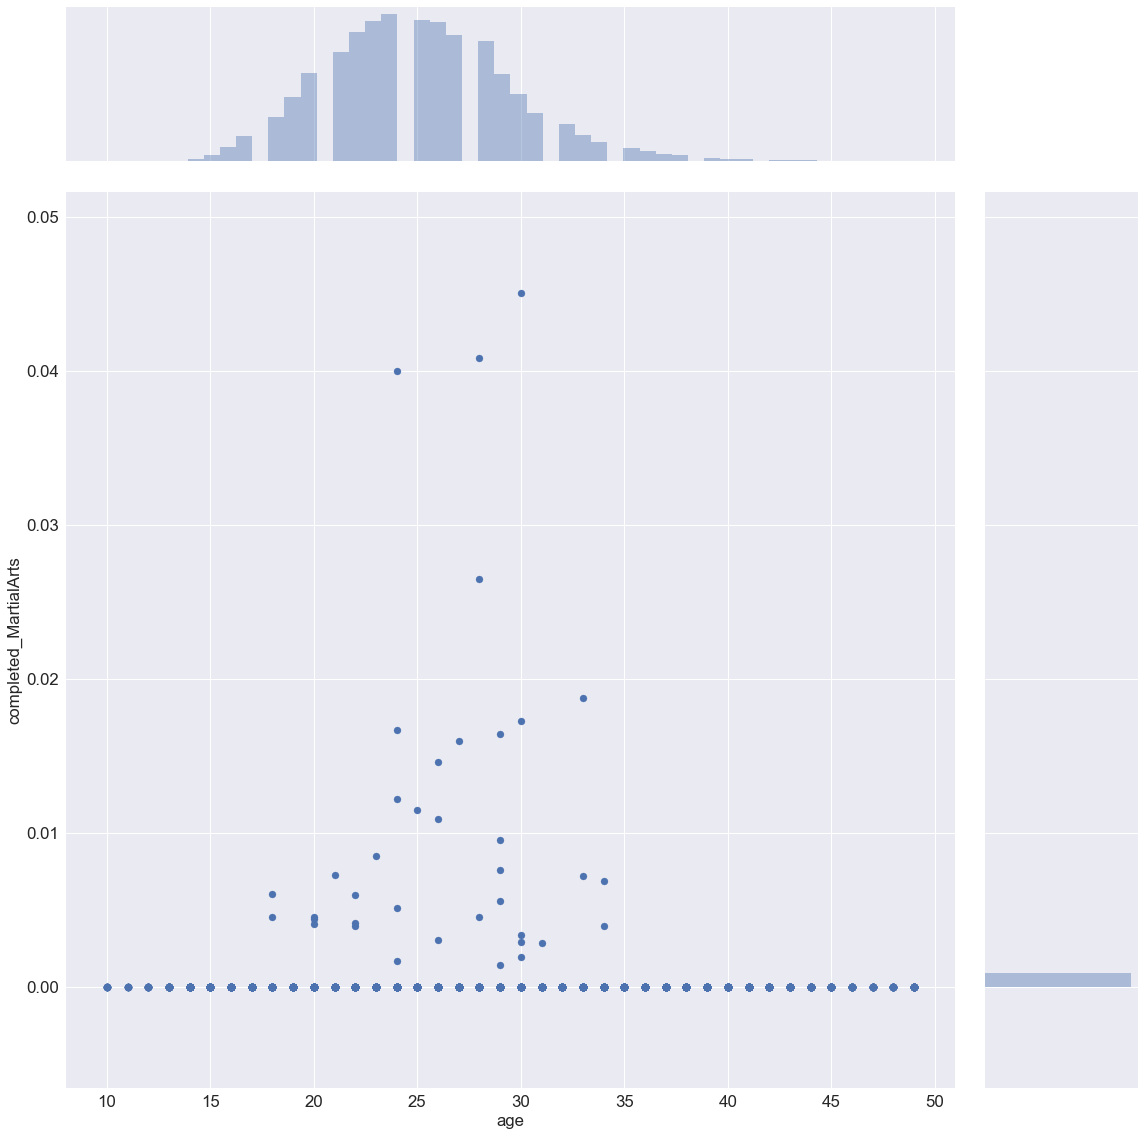

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


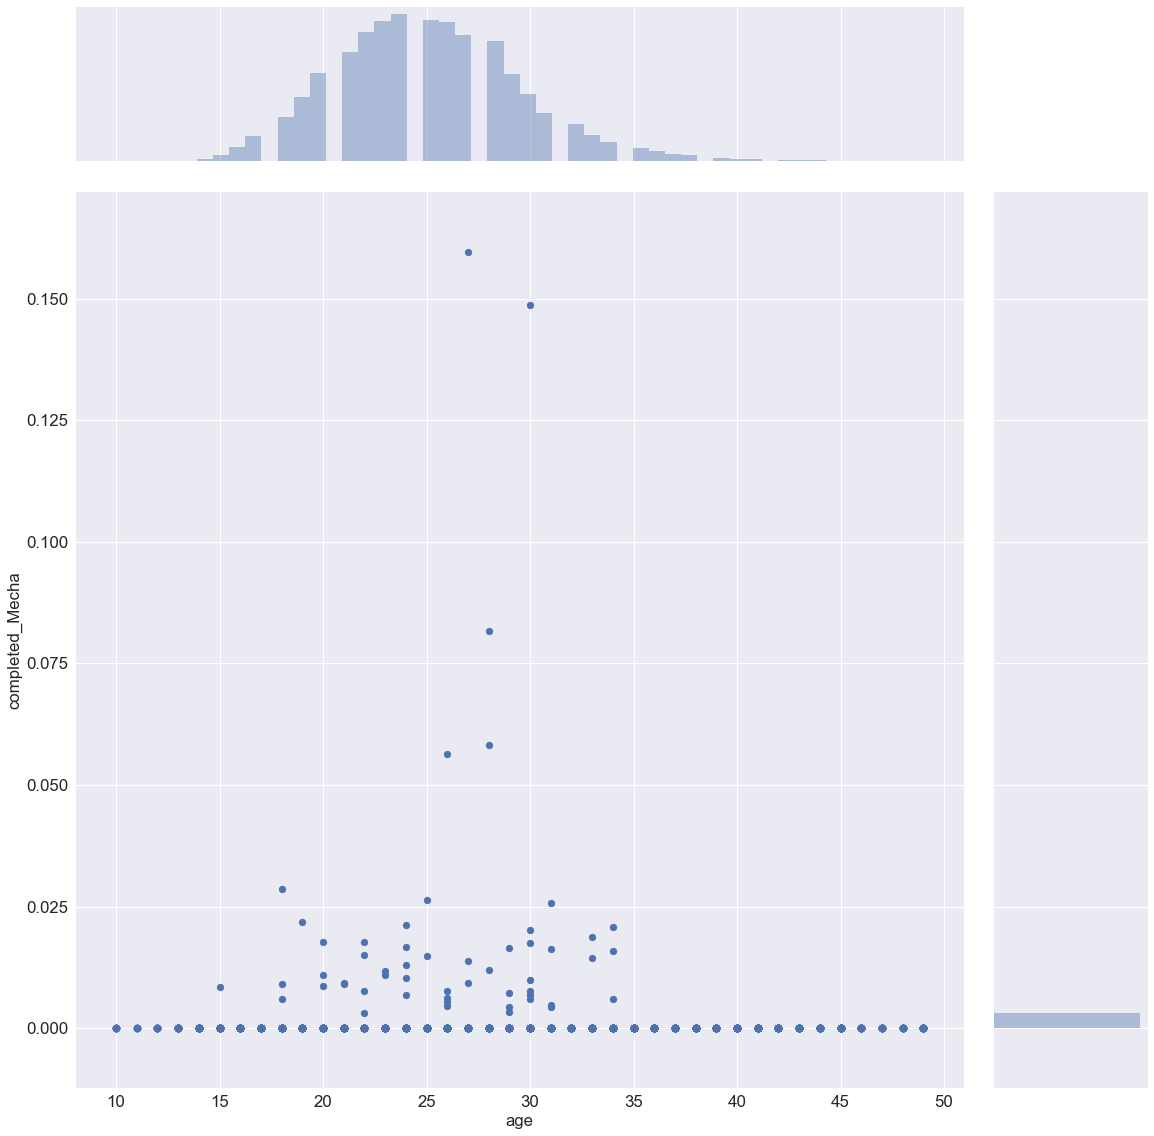

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


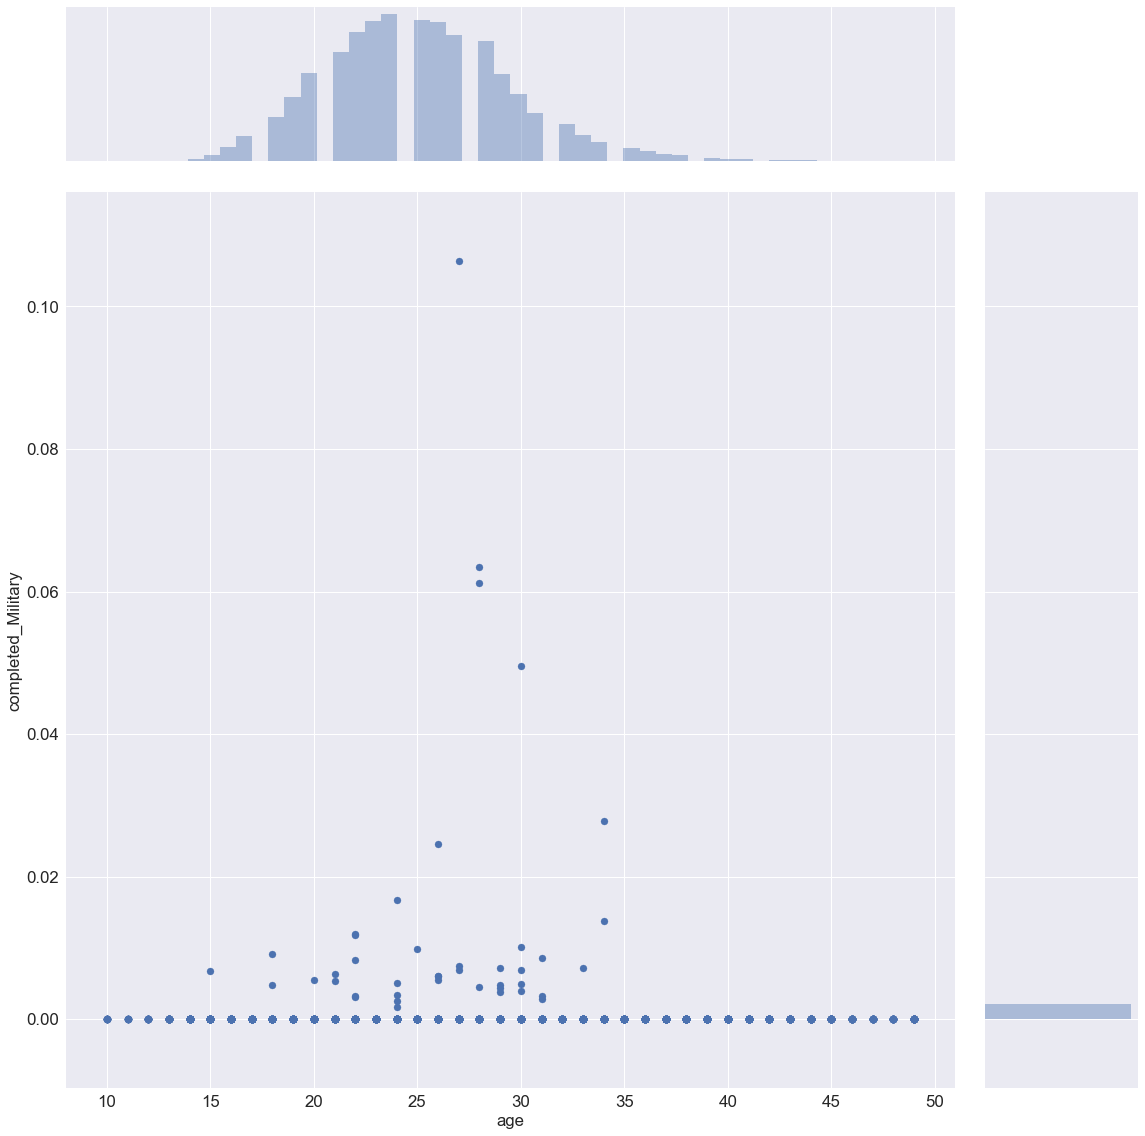

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


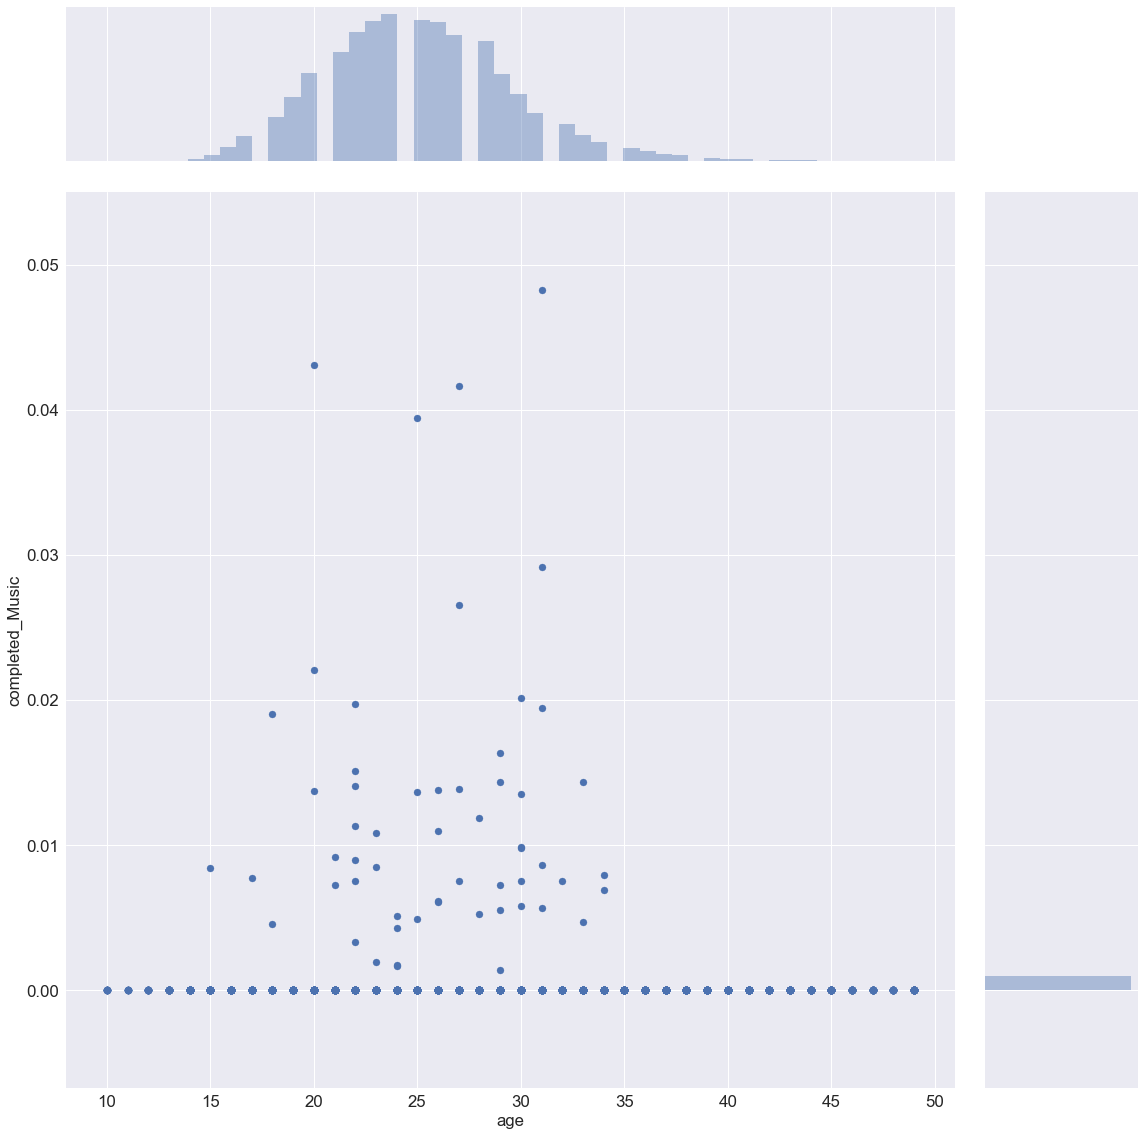

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


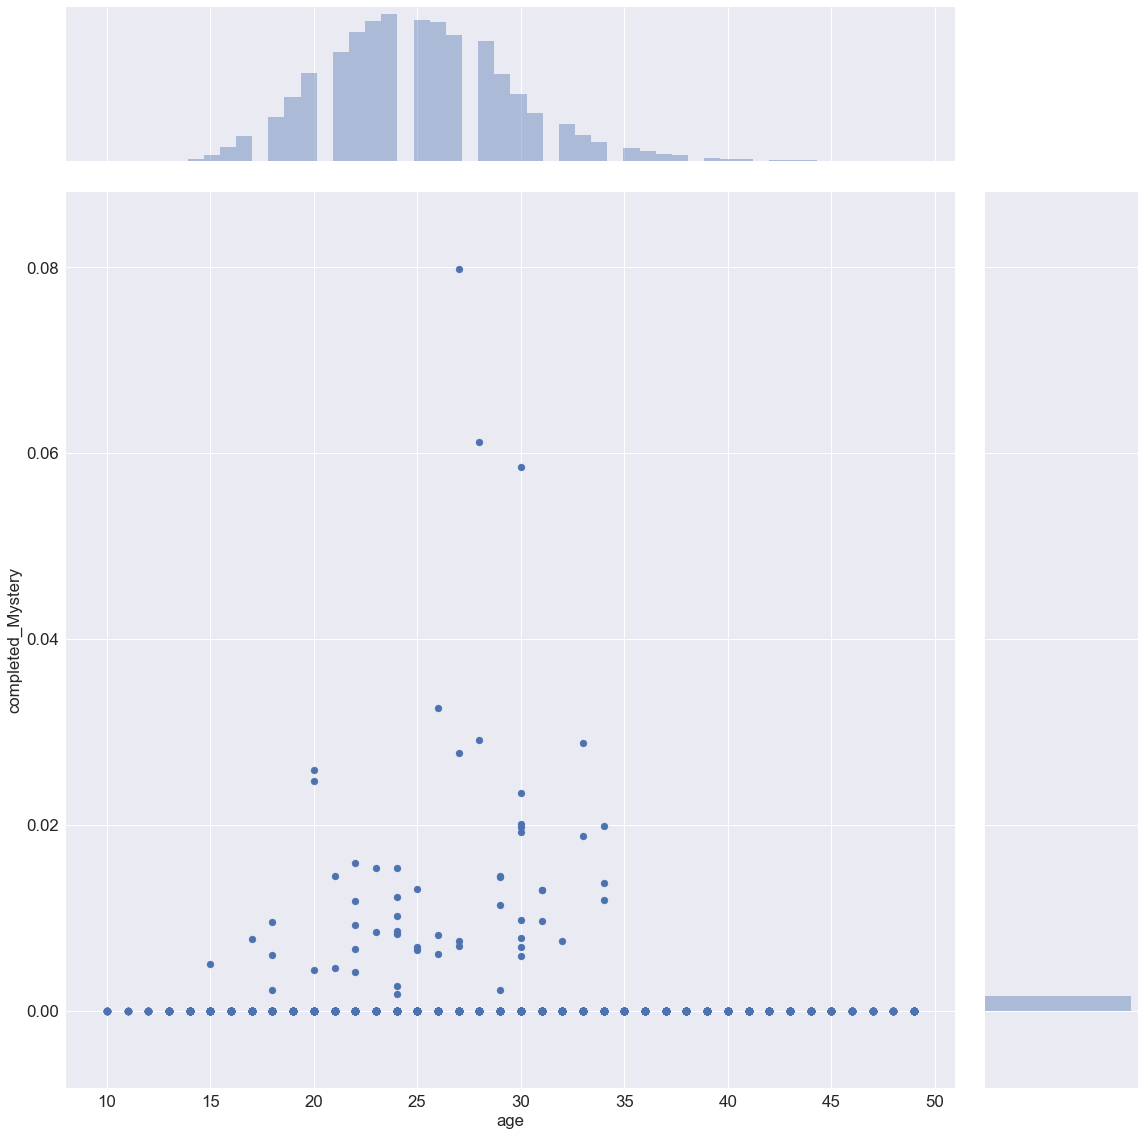

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


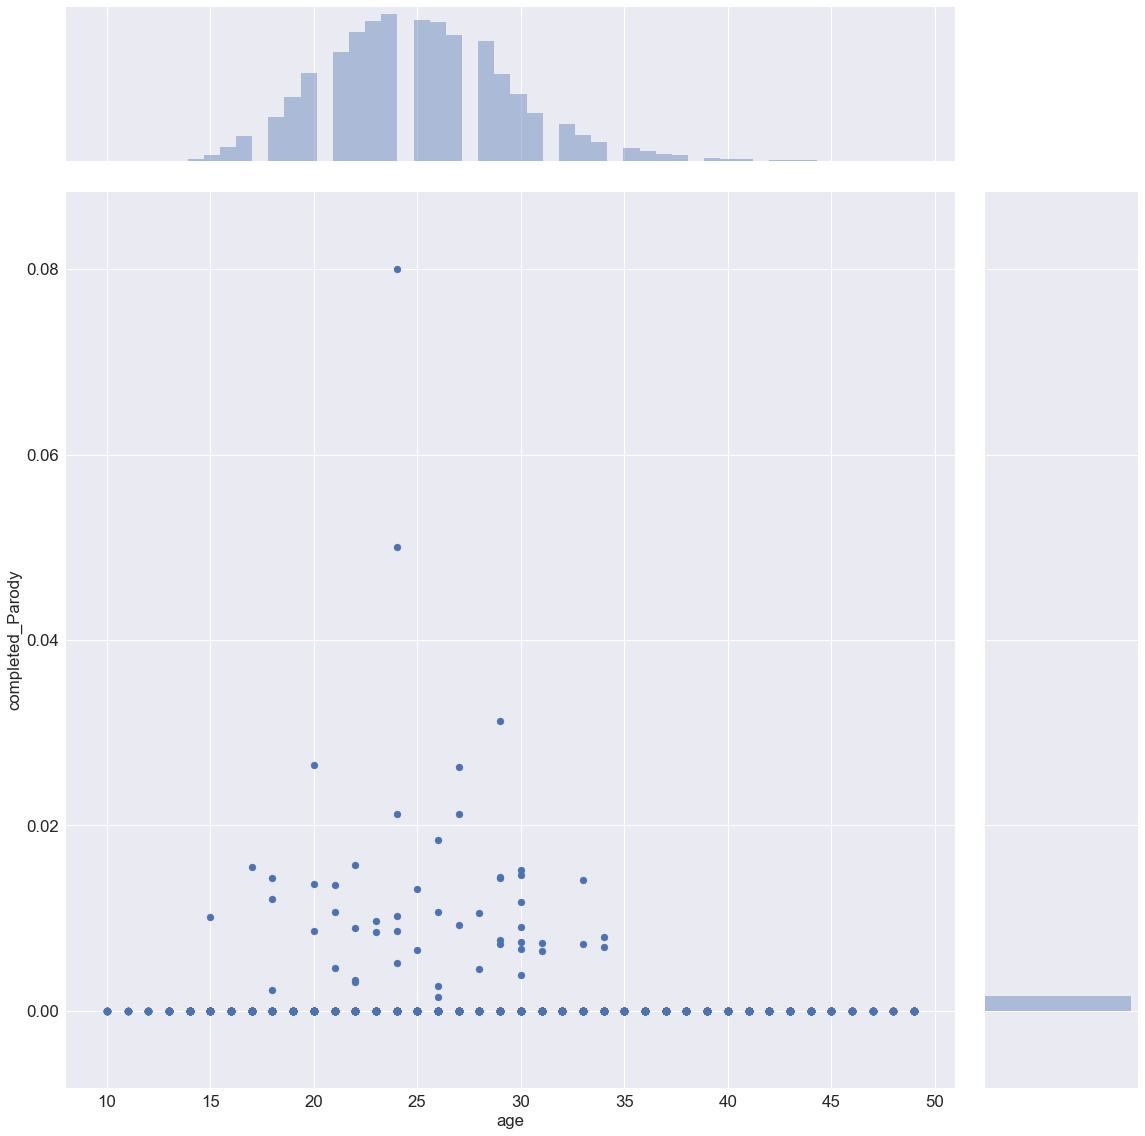

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


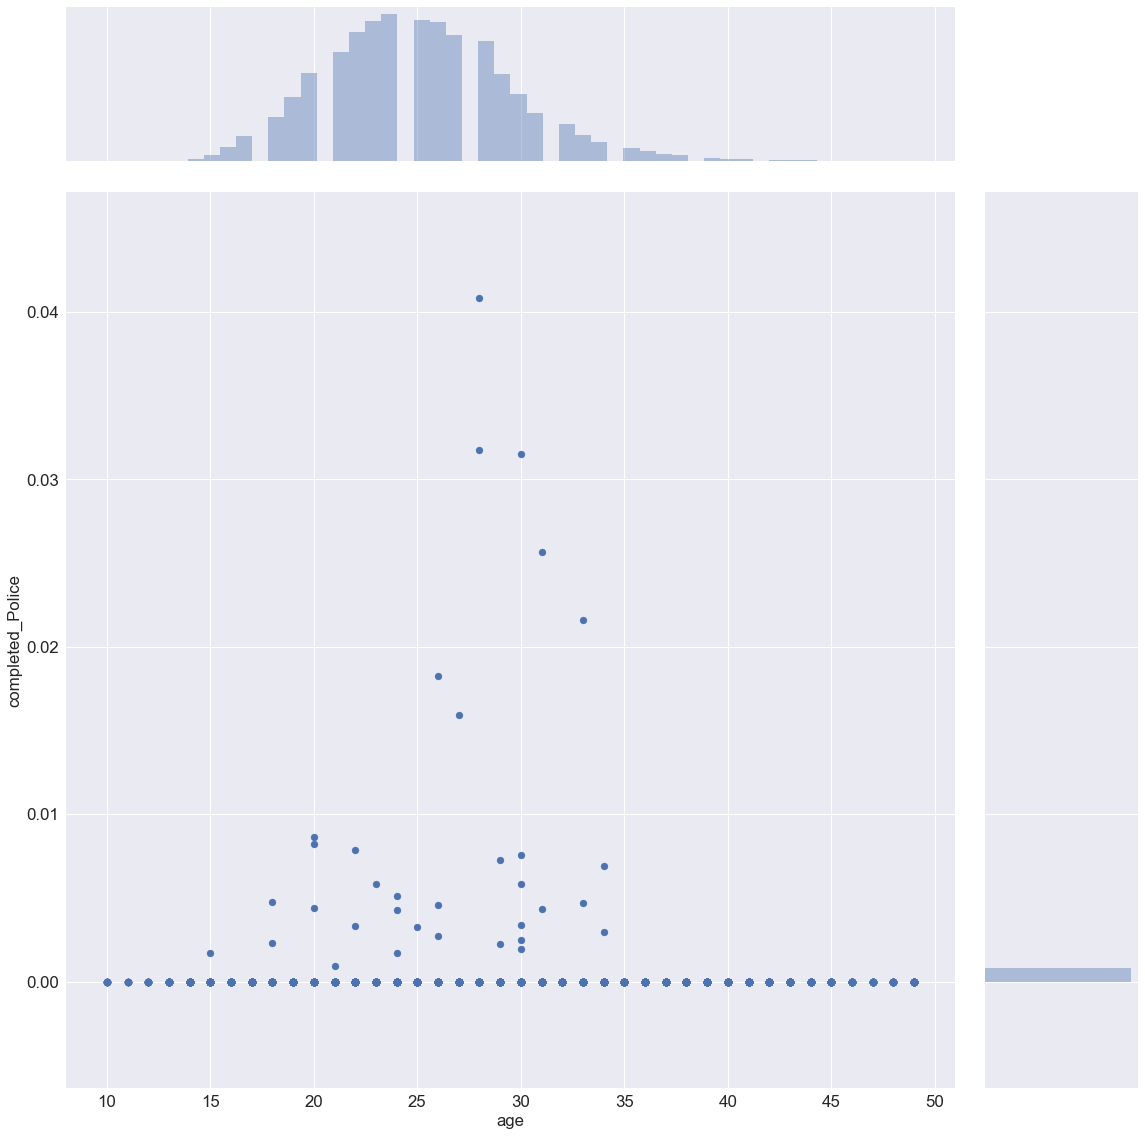

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


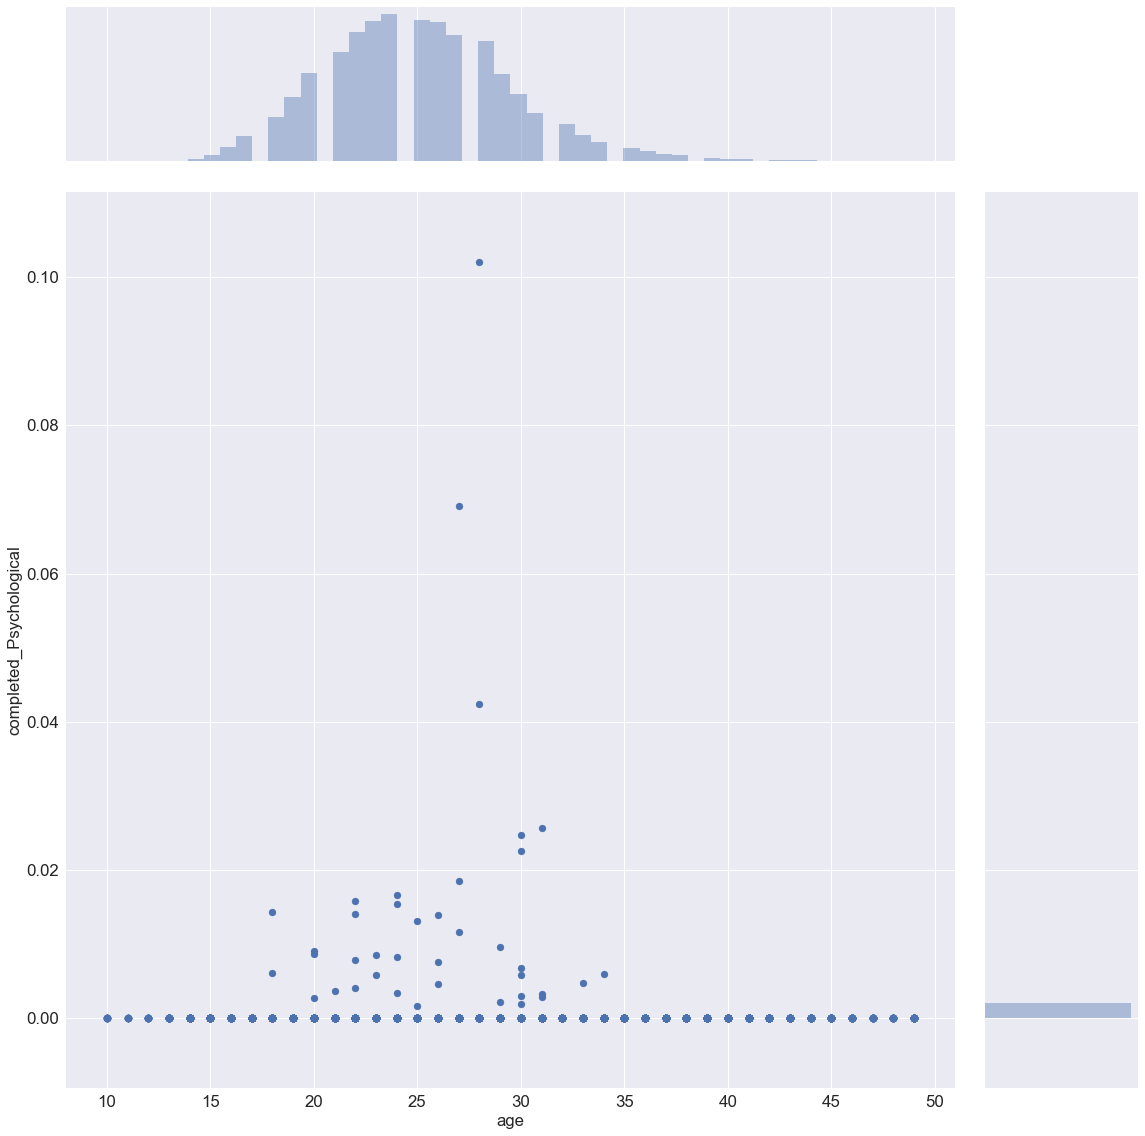

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


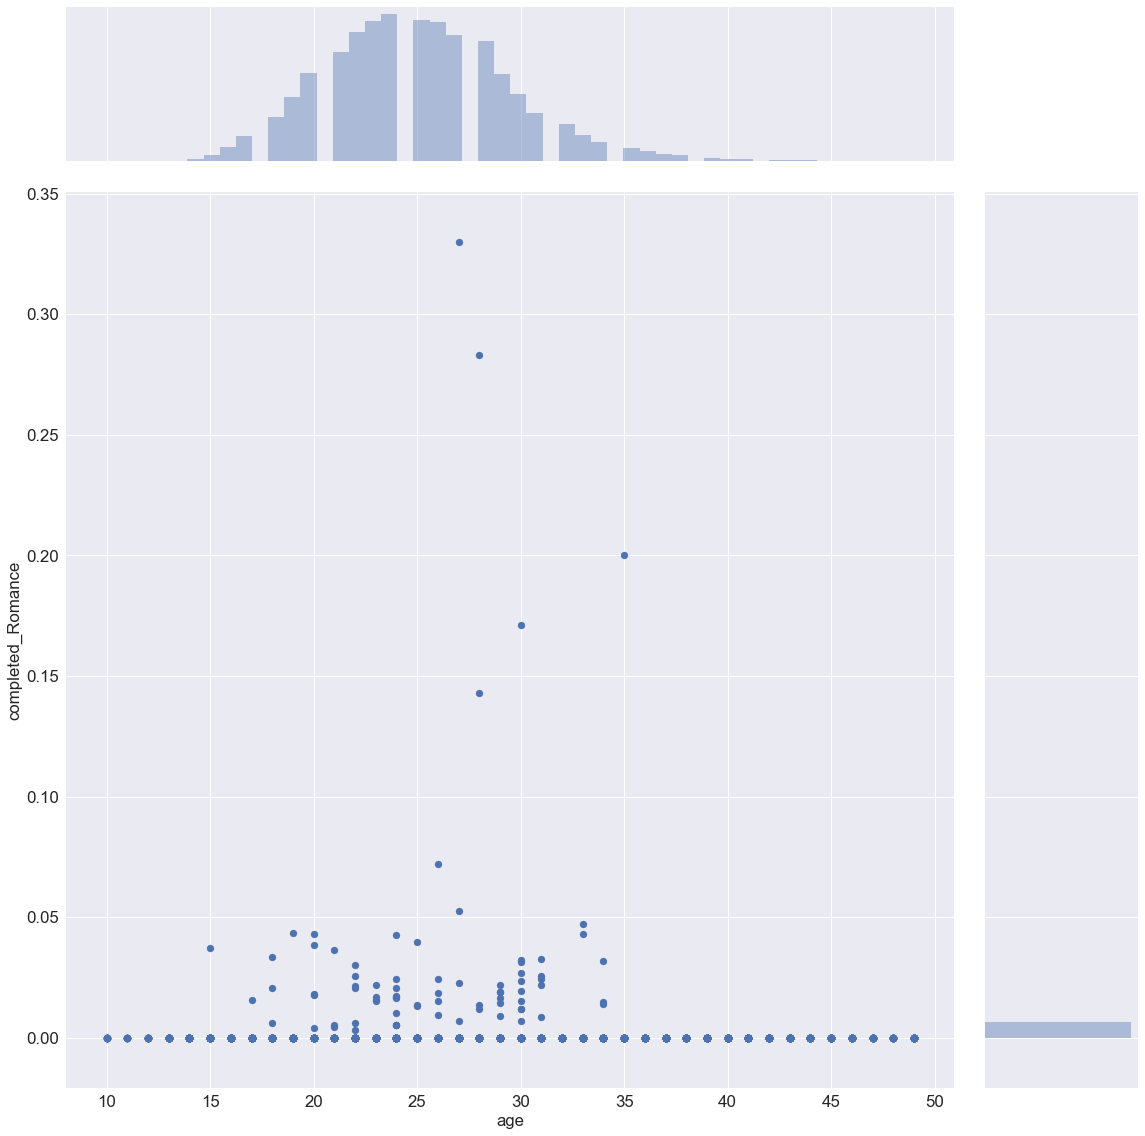

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


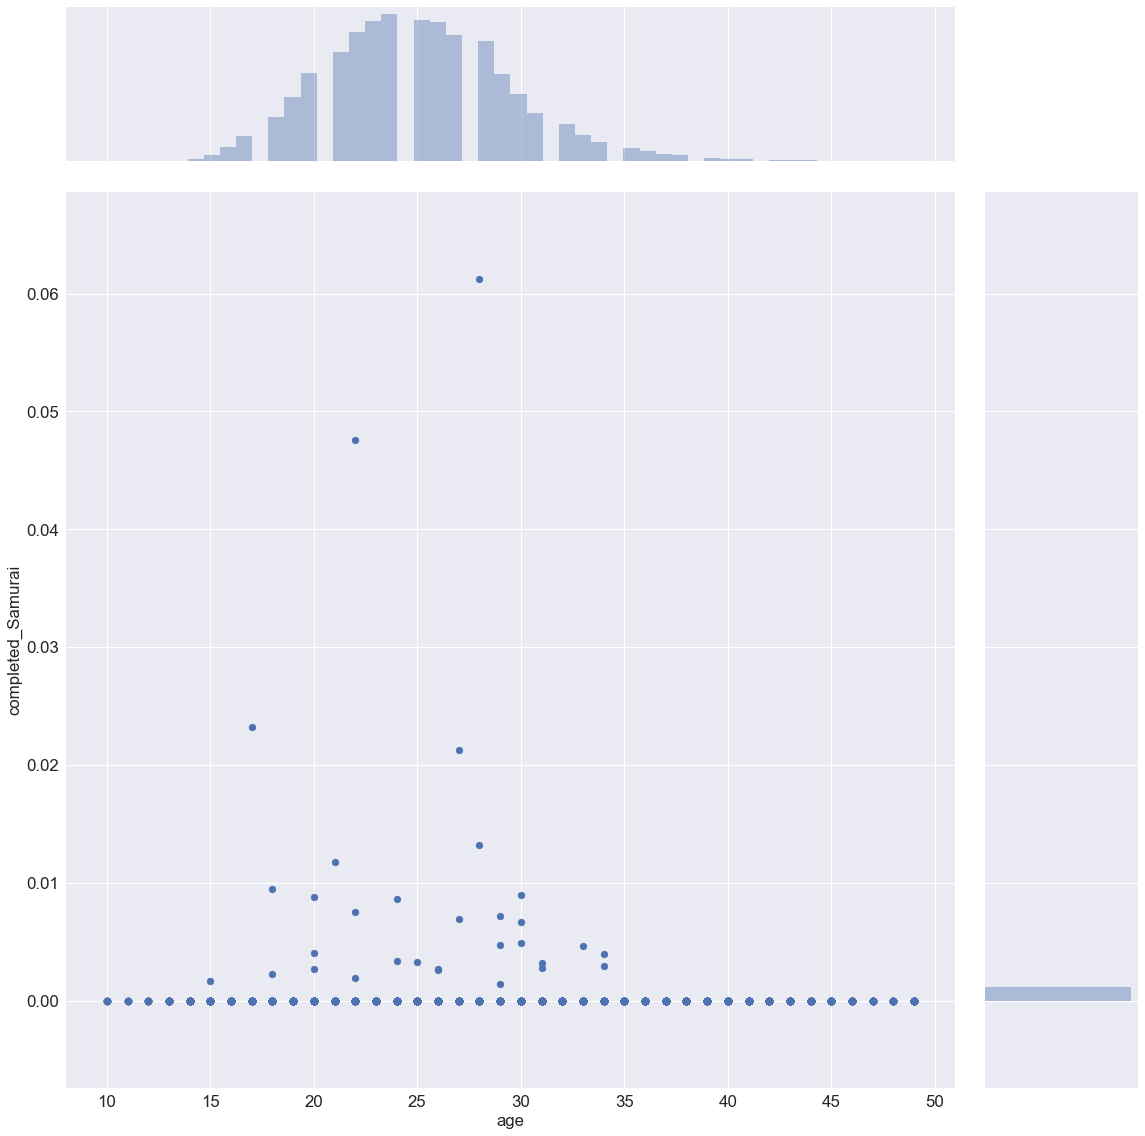

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


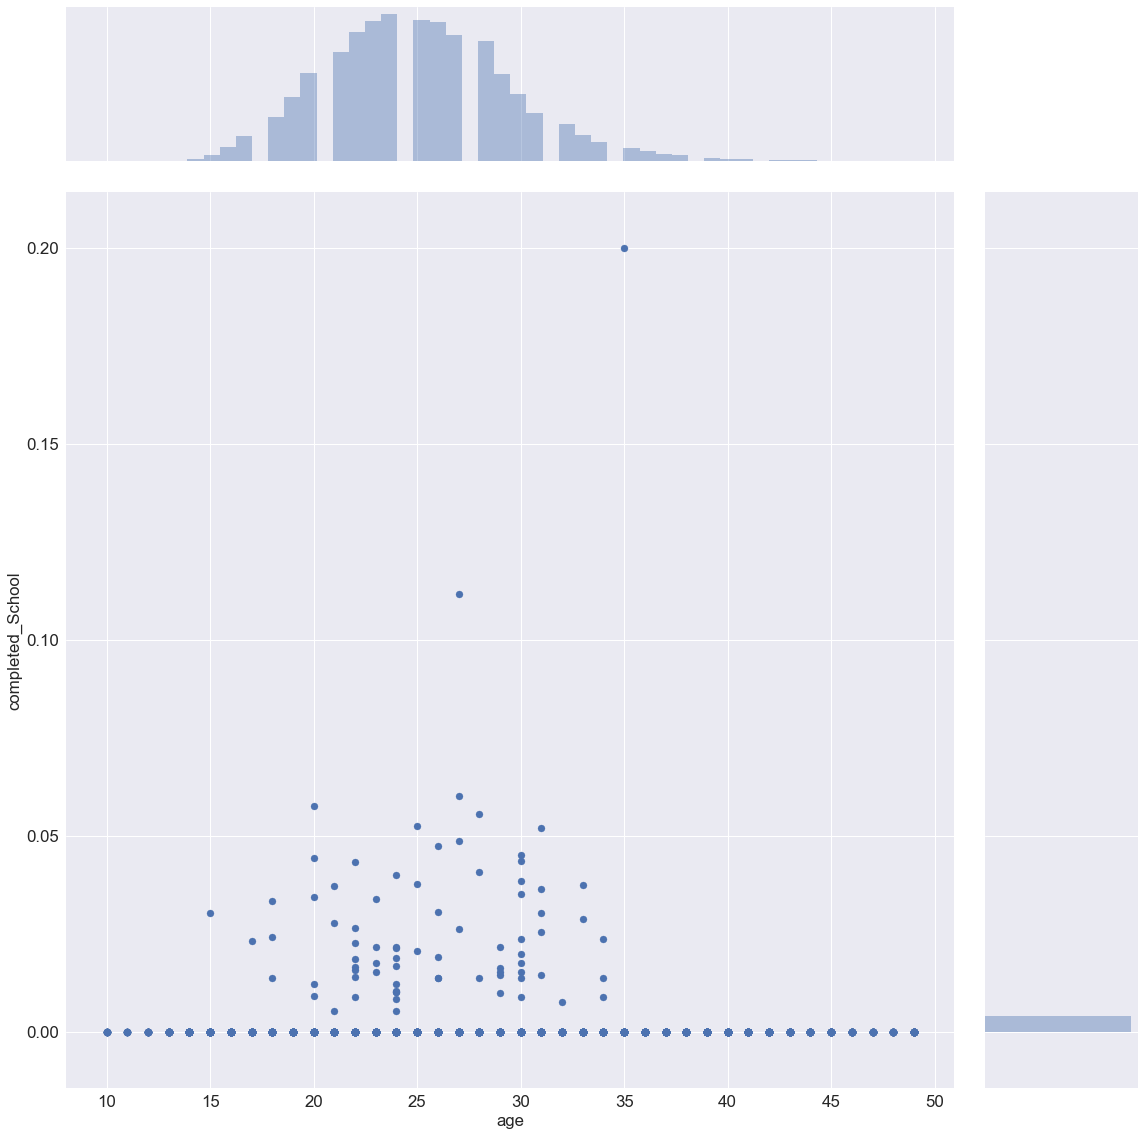

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


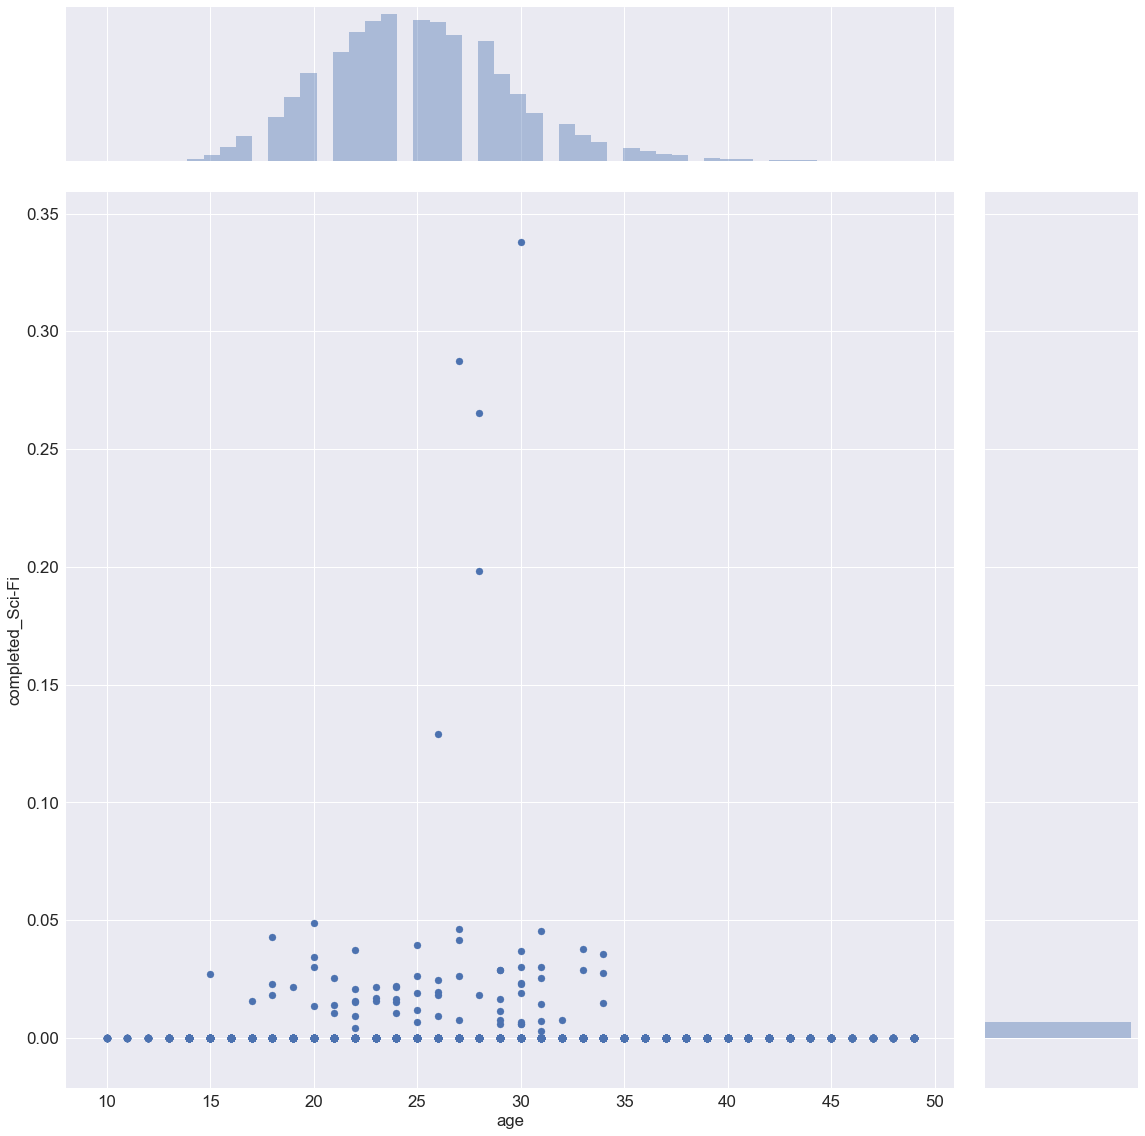

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


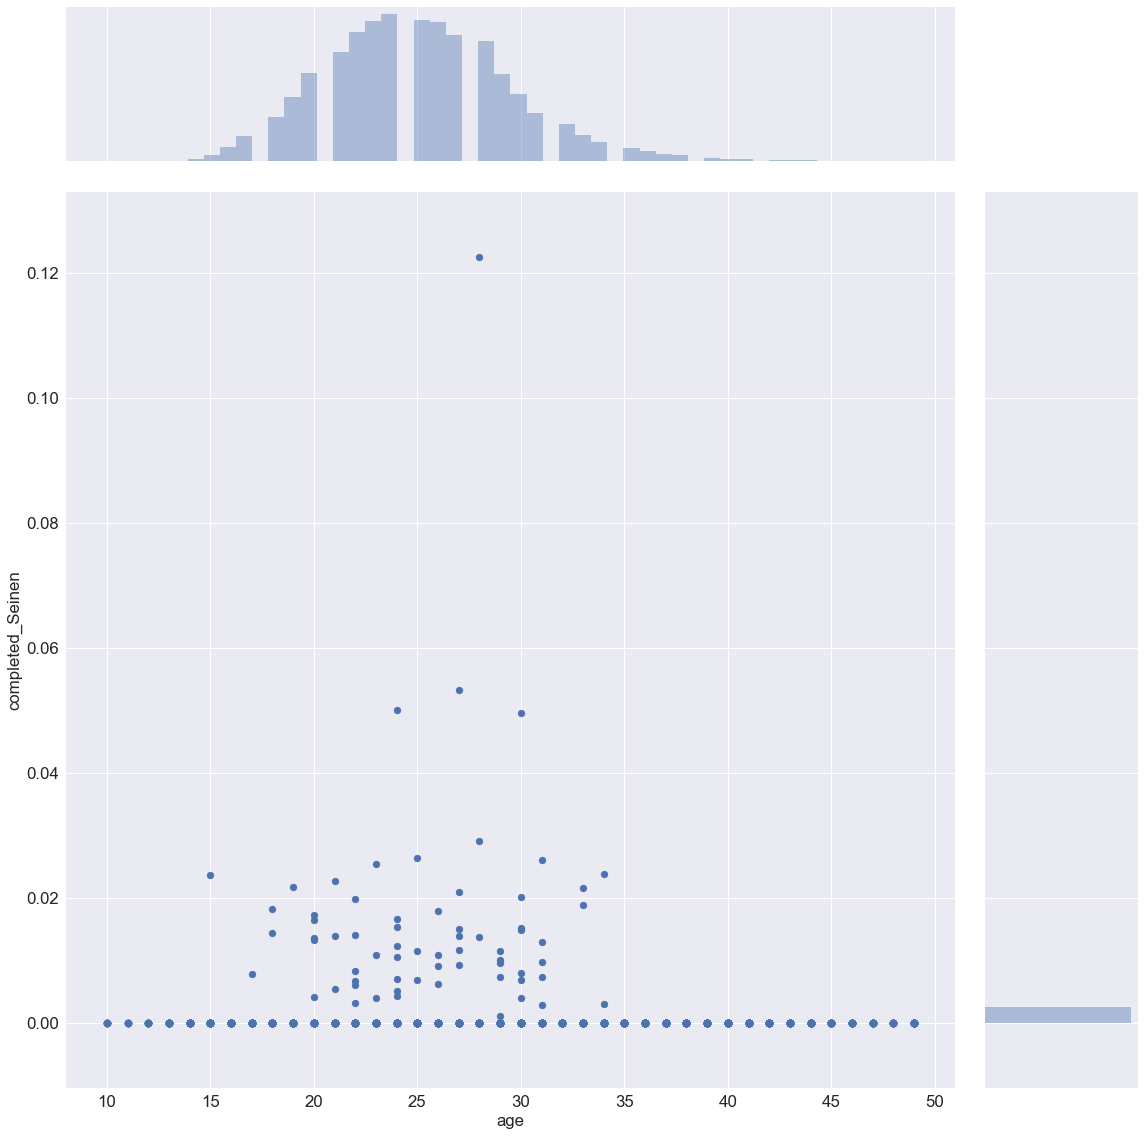

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


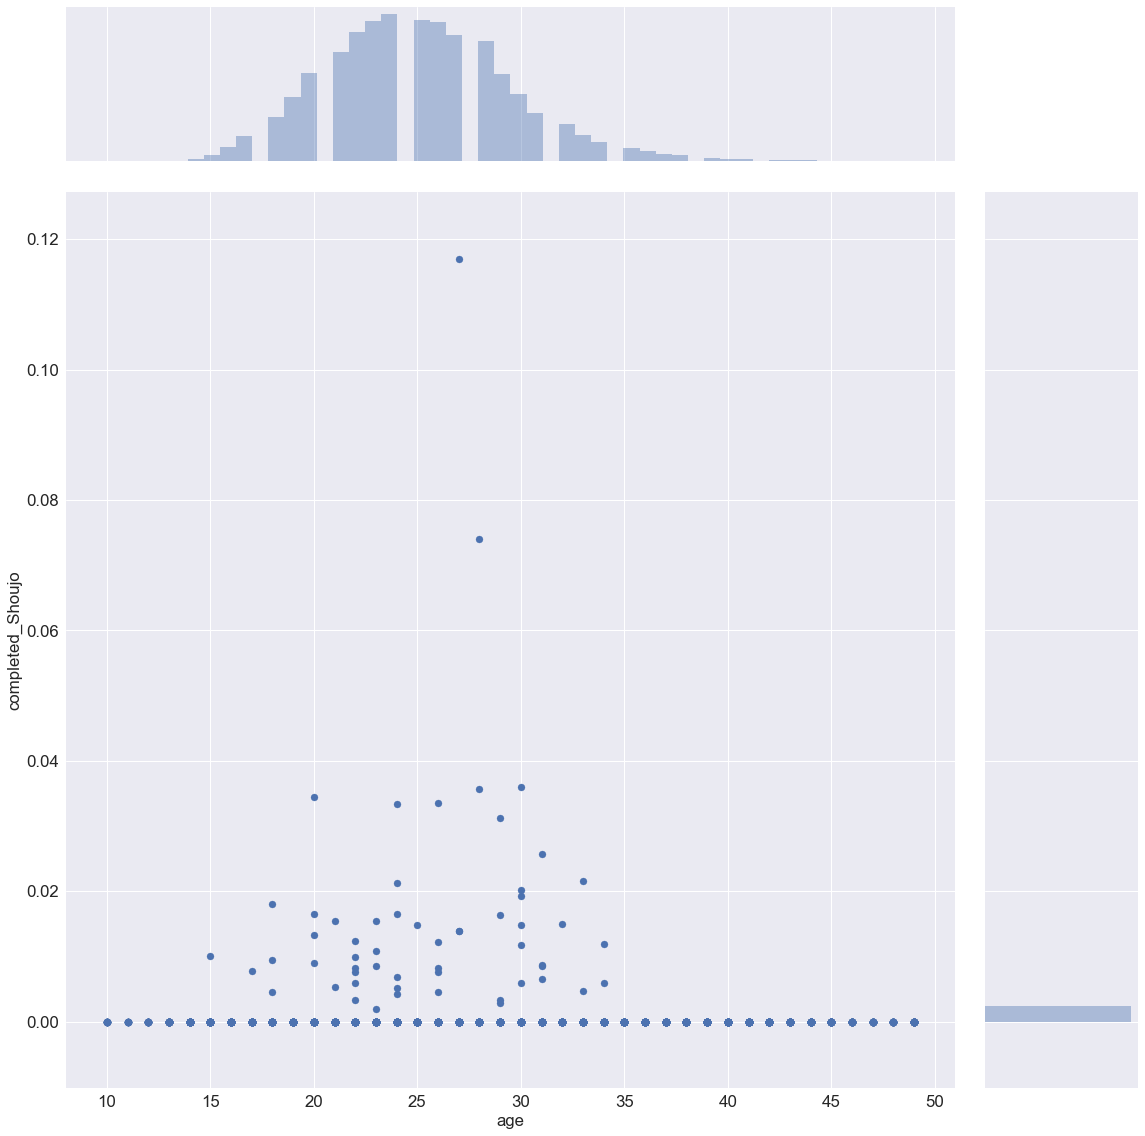

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


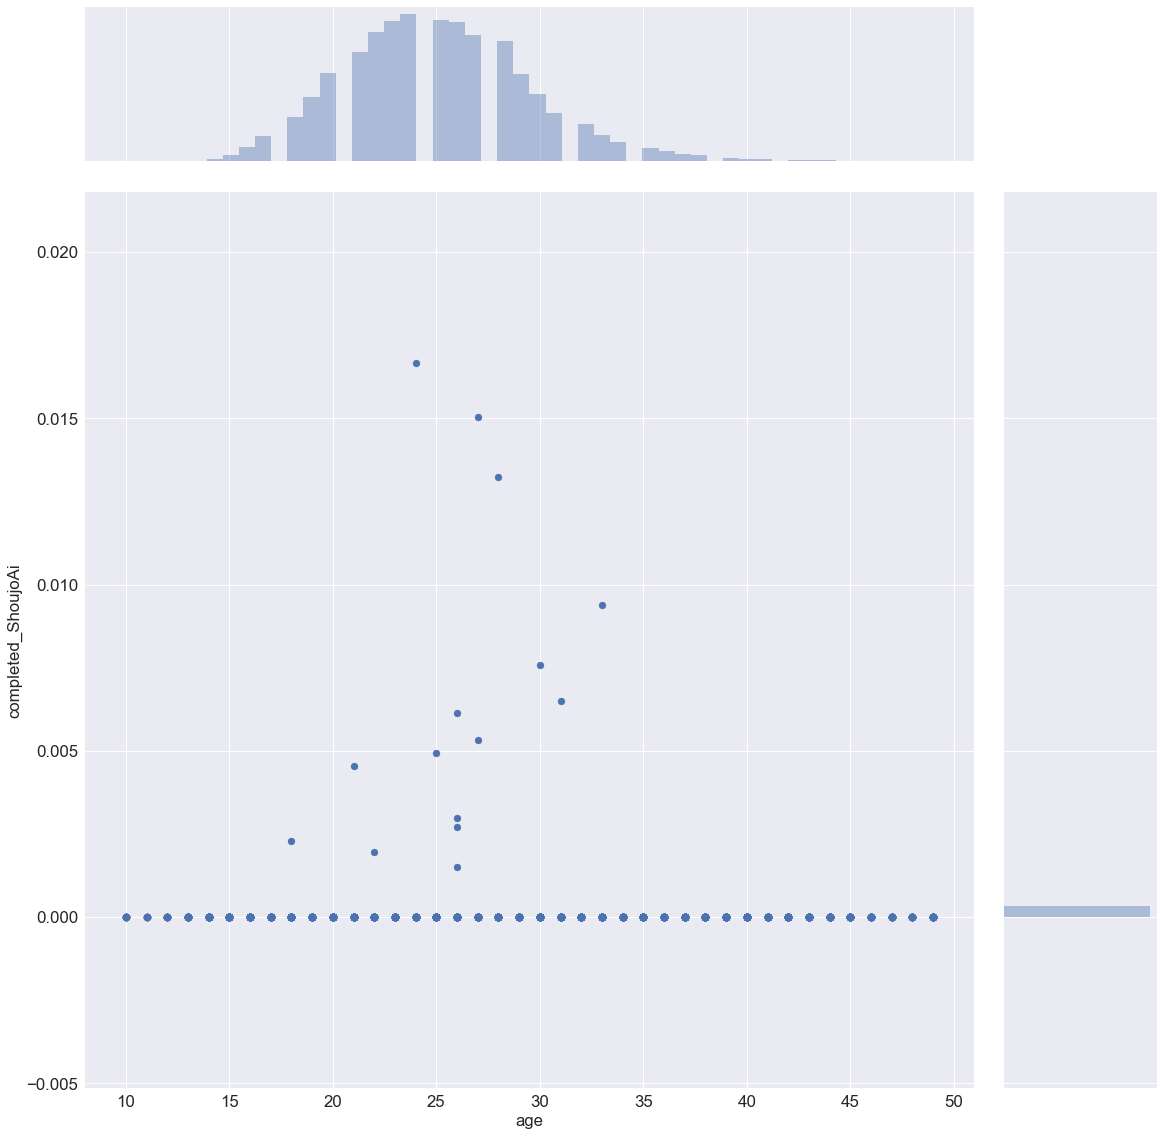

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


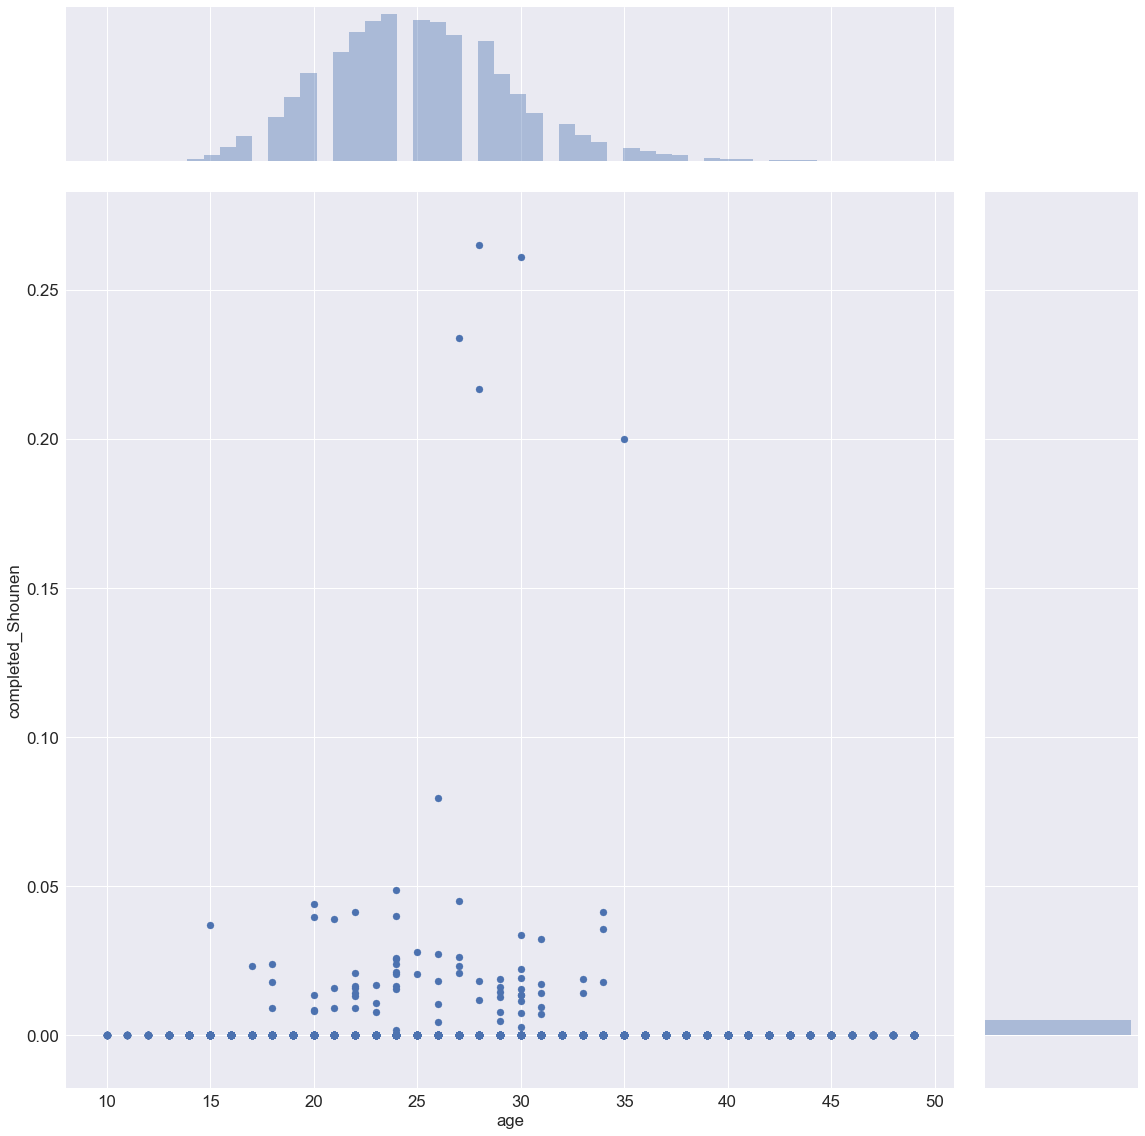

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


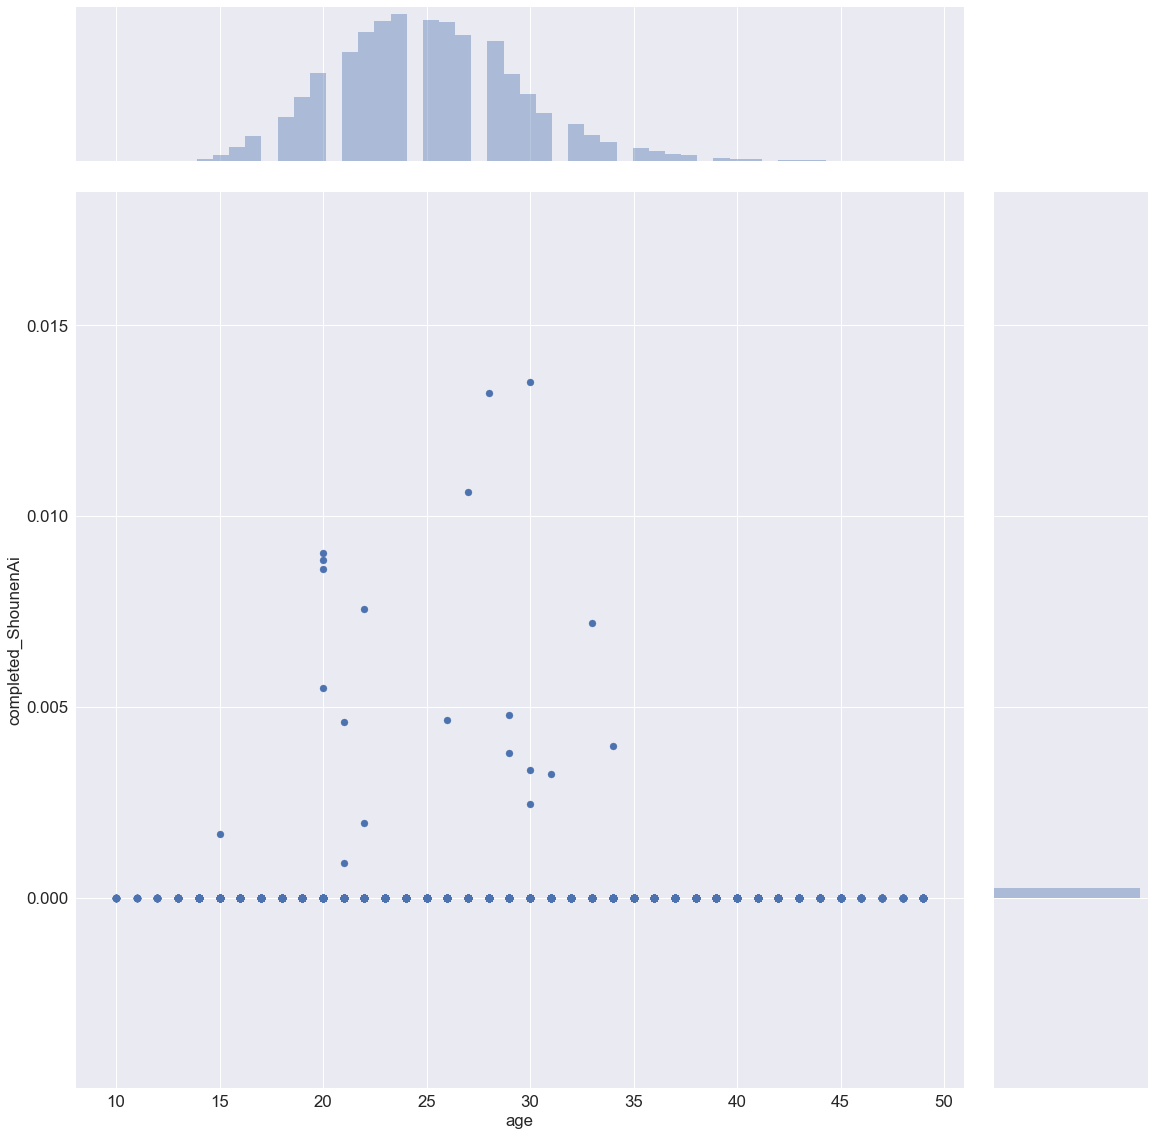

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


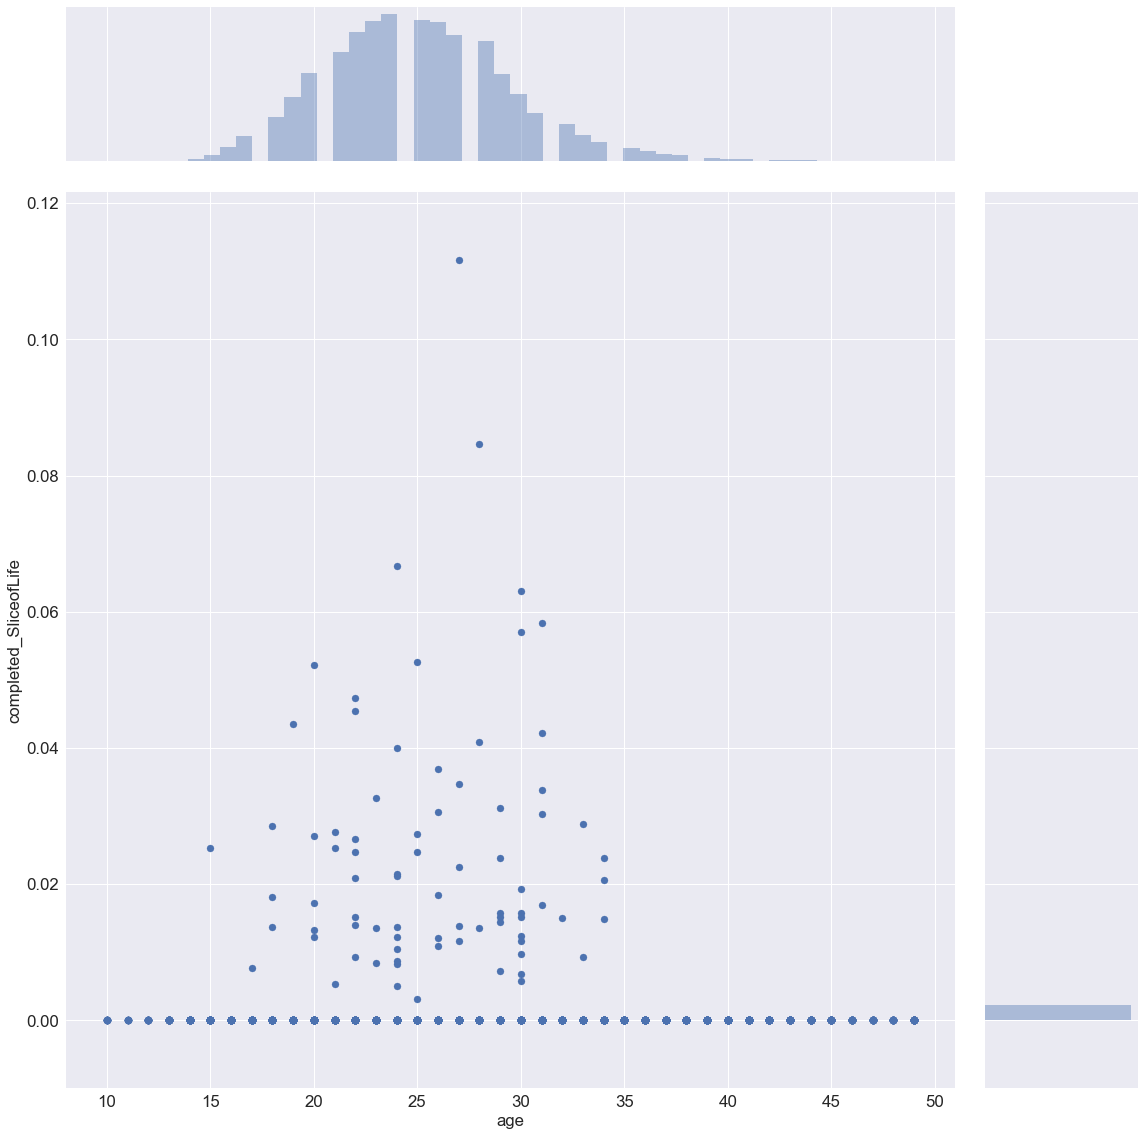

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


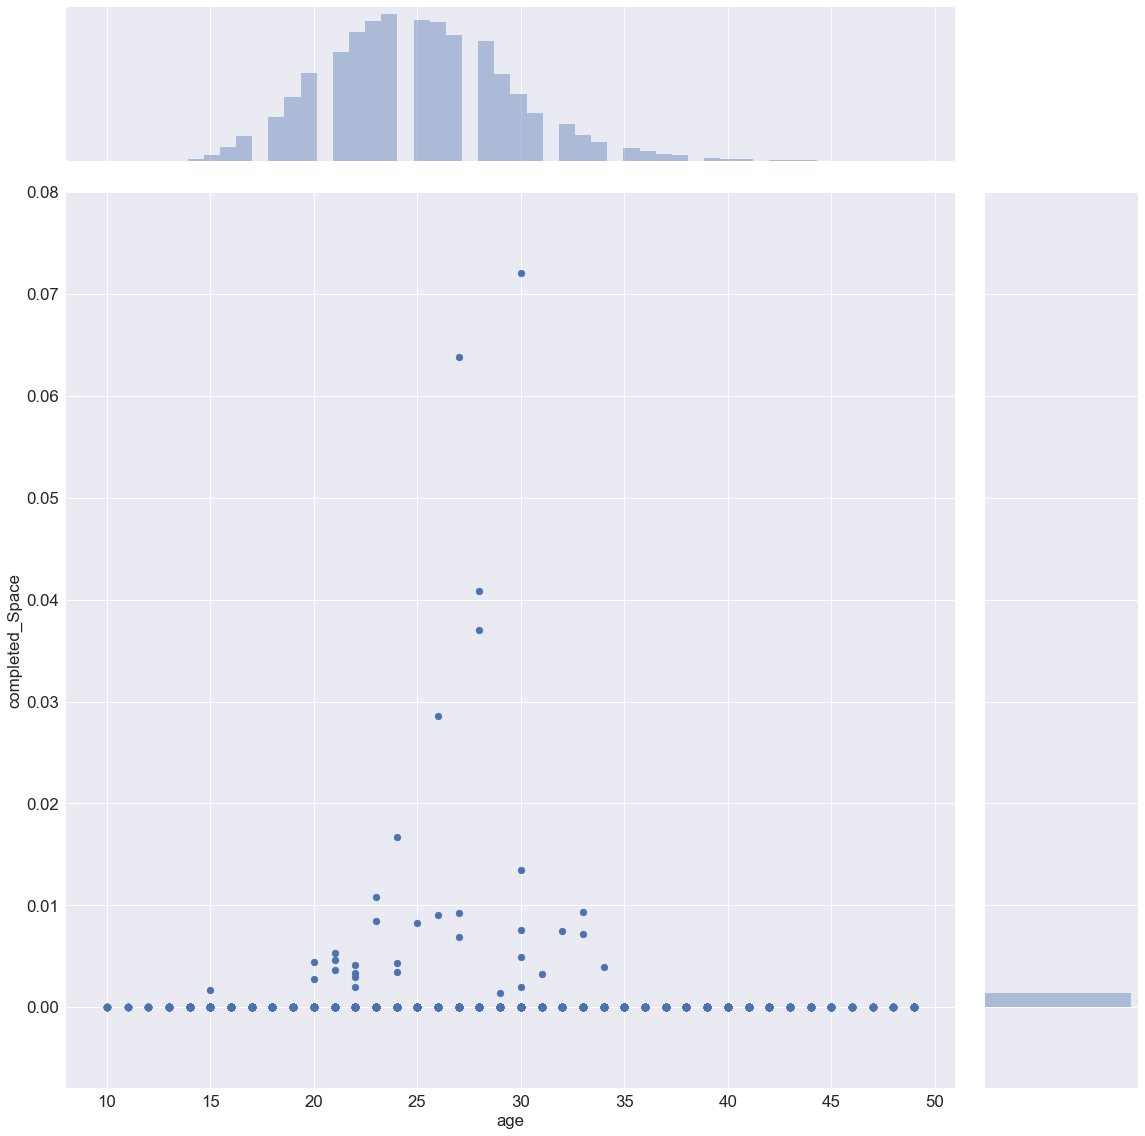

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


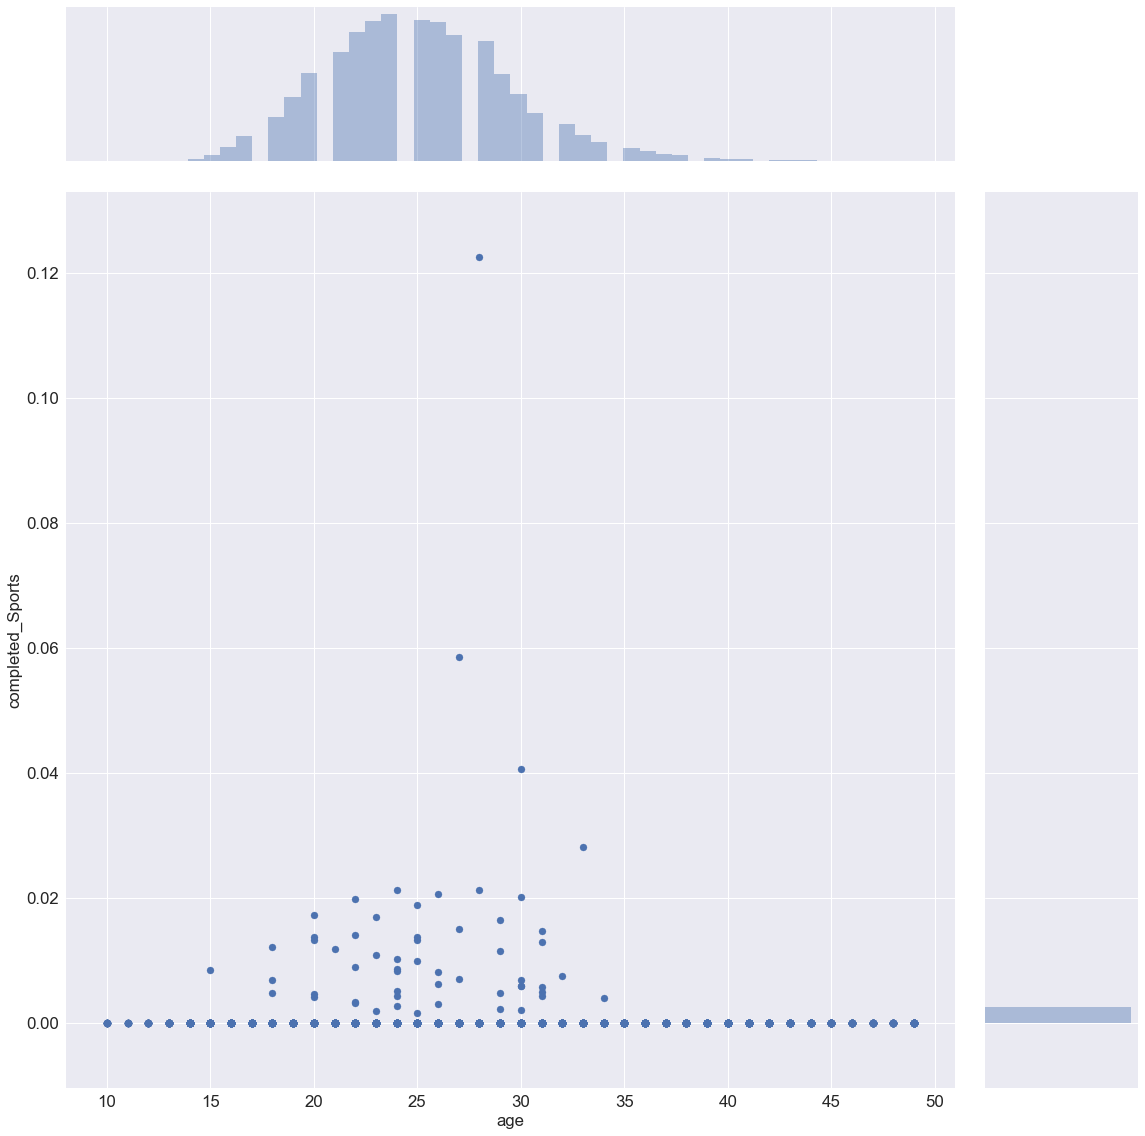

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


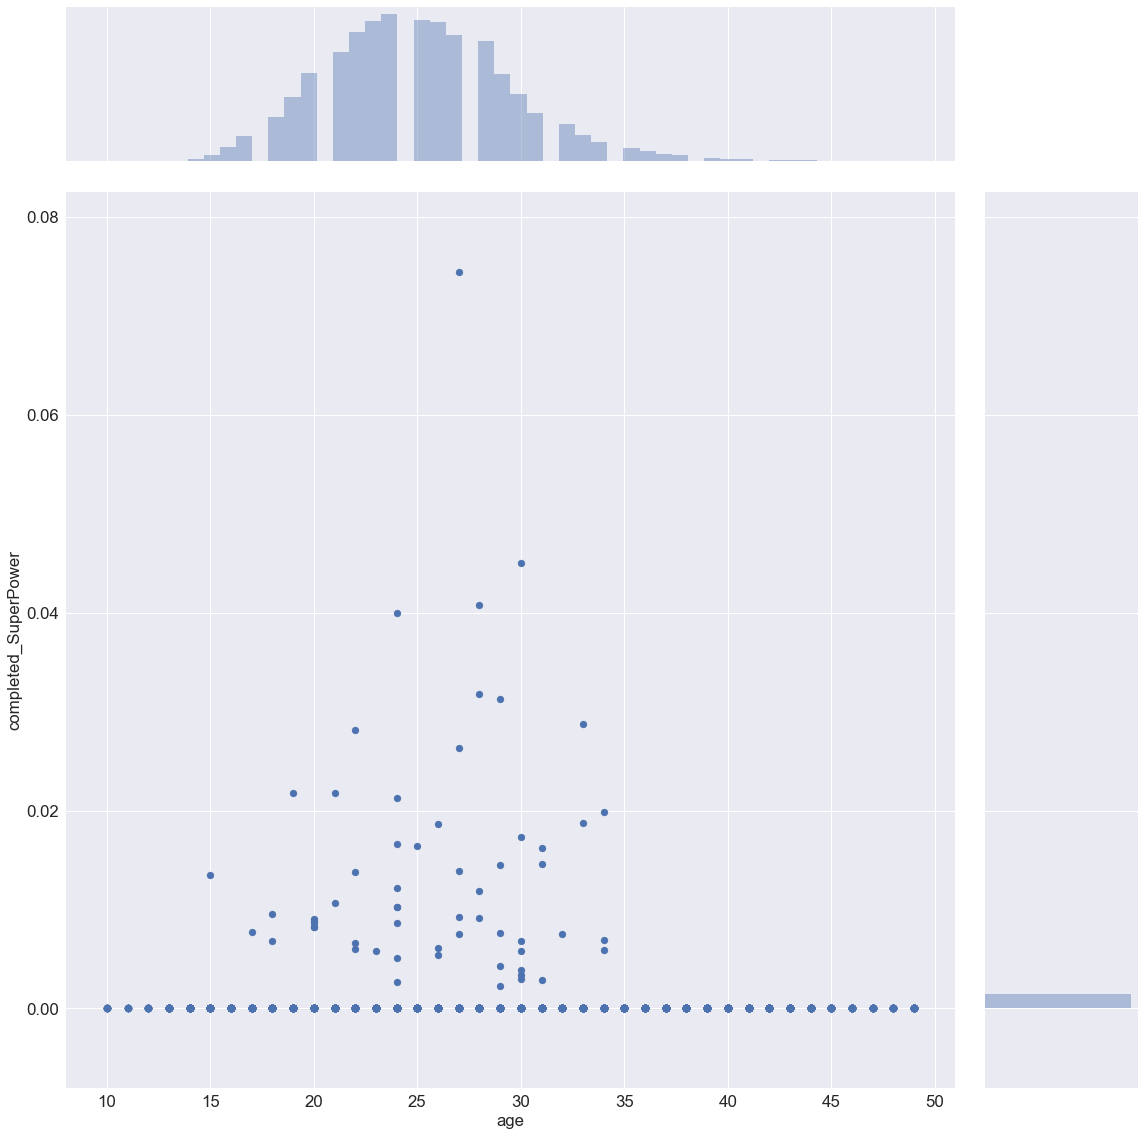

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


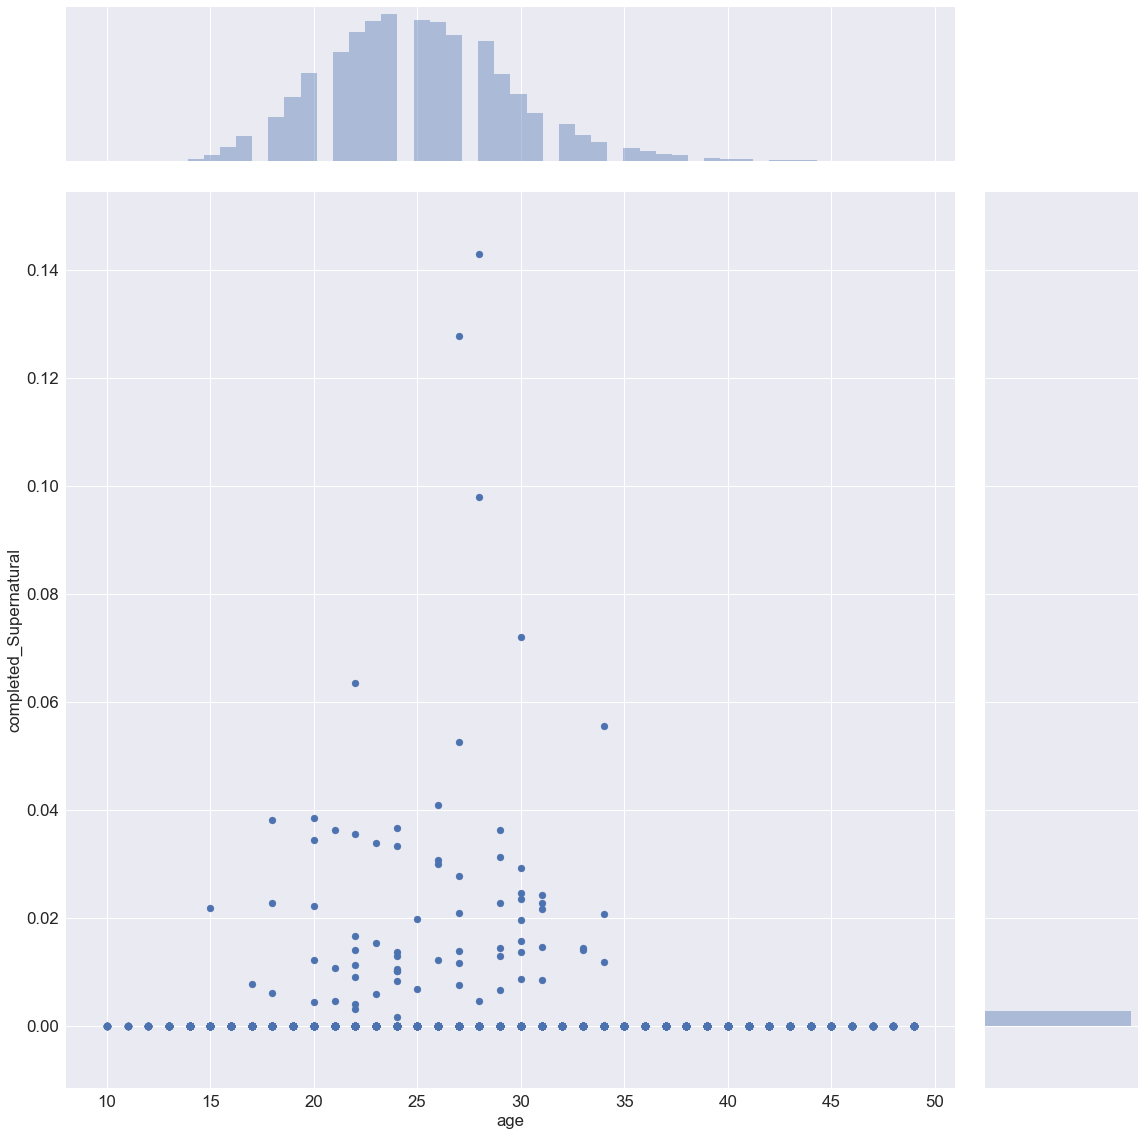

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


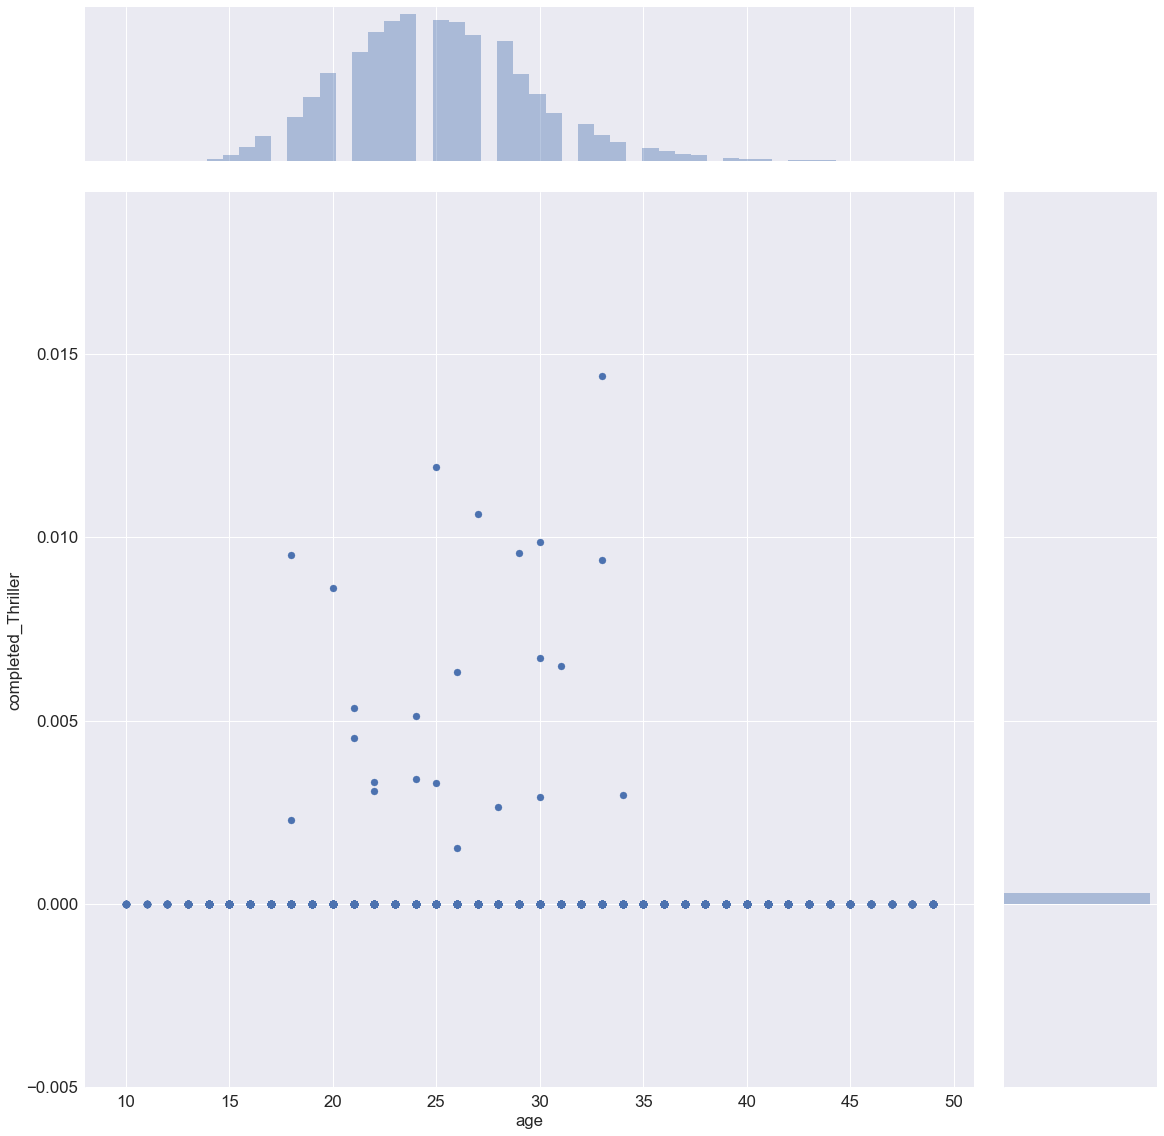

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


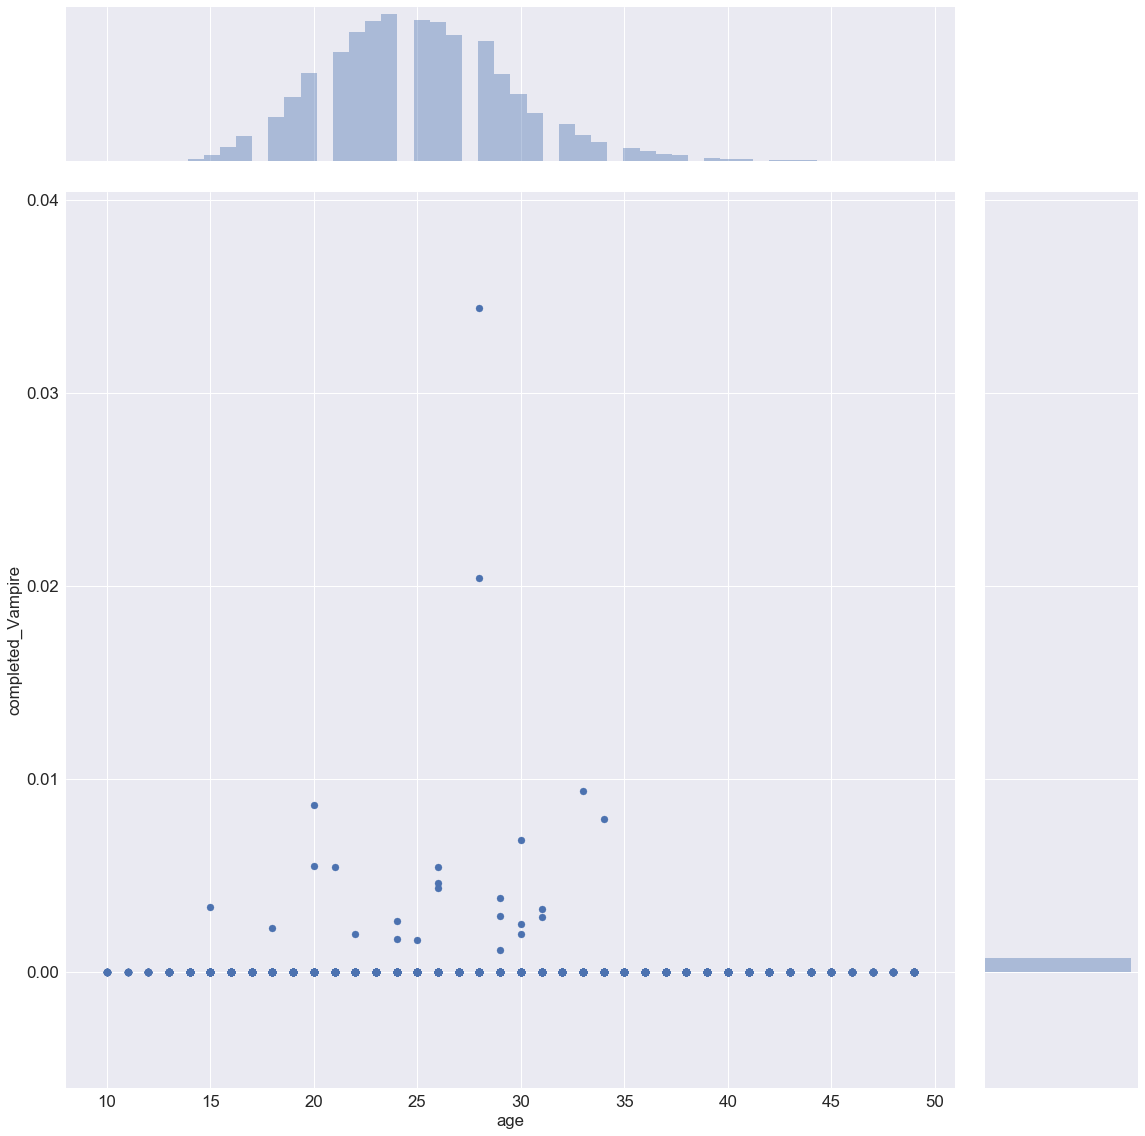

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


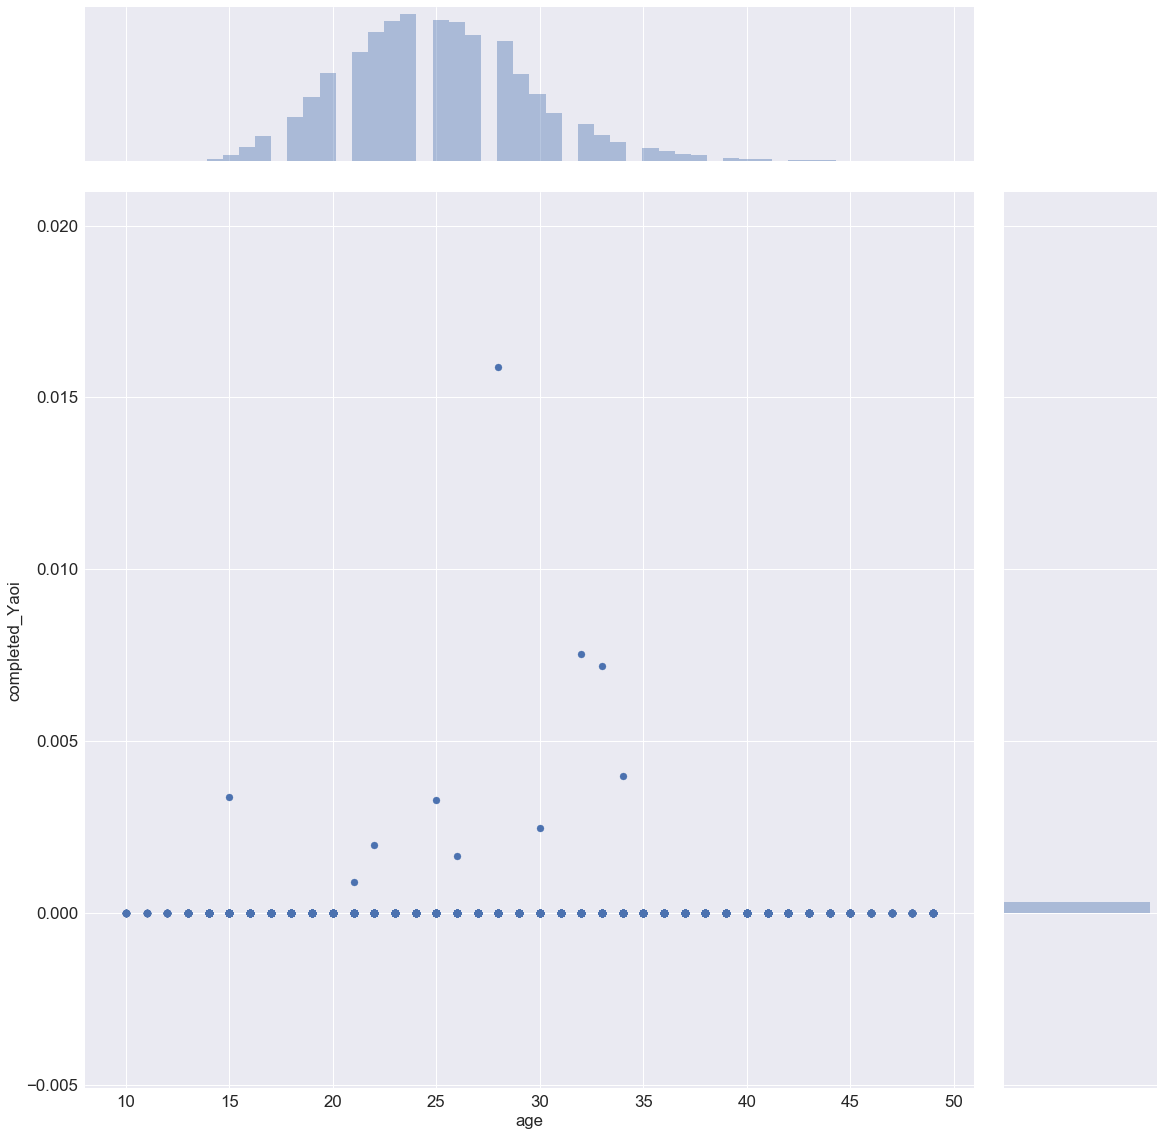

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


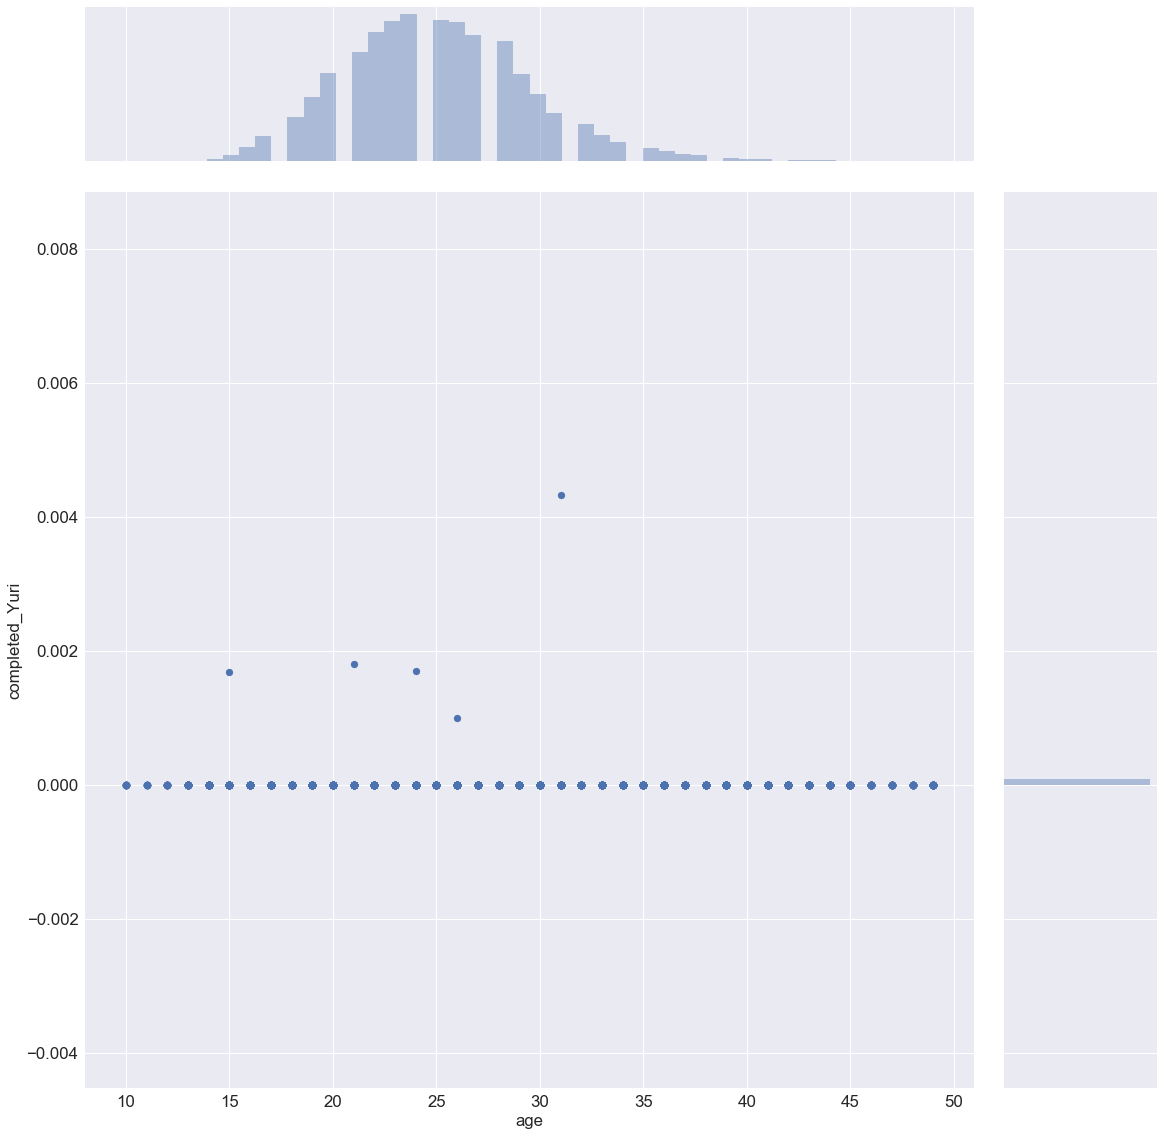

In [35]:
for genre in completed_columns:
    sns.jointplot(x='age', y=genre, data=users_ages_completed, size=16)
    plt.show()

In [36]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='scatter')

In [37]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='reg')

In [38]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='resid')

In [39]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='kde')

In [40]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='hex')

In [41]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16).plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [42]:
# entropy describes how many information it contains. Uniform distribution has highest entropy, dirac distribution lowest. 
# Lower entropy of genre means higher dependency on age
ages_genres[completed_columns].apply(entropy).sort_values()
# shows genres sorted by their dependency on age

completed_Yuri             0.919420
completed_Harem            1.539262
completed_Yaoi             1.741132
completed_Dementia         1.755771
completed_Josei            1.914098
completed_Cars             1.922967
completed_ShoujoAi         2.126002
completed_Thriller         2.146215
completed_Vampire          2.211757
completed_ShounenAi        2.257248
completed_Space            2.273730
completed_Military         2.277724
completed_MartialArts      2.318190
completed_Police           2.320306
completed_Shounen          2.358963
completed_Psychological    2.379643
completed_School           2.419985
completed_Romance          2.437276
completed_Samurai          2.466504
completed_Adventure        2.478492
completed_Horror           2.511644
completed_Mecha            2.513241
completed_Historical       2.526005
completed_Mystery          2.526354
completed_Sci-Fi           2.571254
completed_Supernatural     2.573258
completed_Music            2.584348
completed_Ecchi            2

In [43]:
arr = np.ones(ages_genres.index.size)
entropy(arr / arr.sum())

3.6888794541139363

In [44]:
dependent_genres = ages_genres[completed_columns].apply(entropy).sort_values().index[0:6]

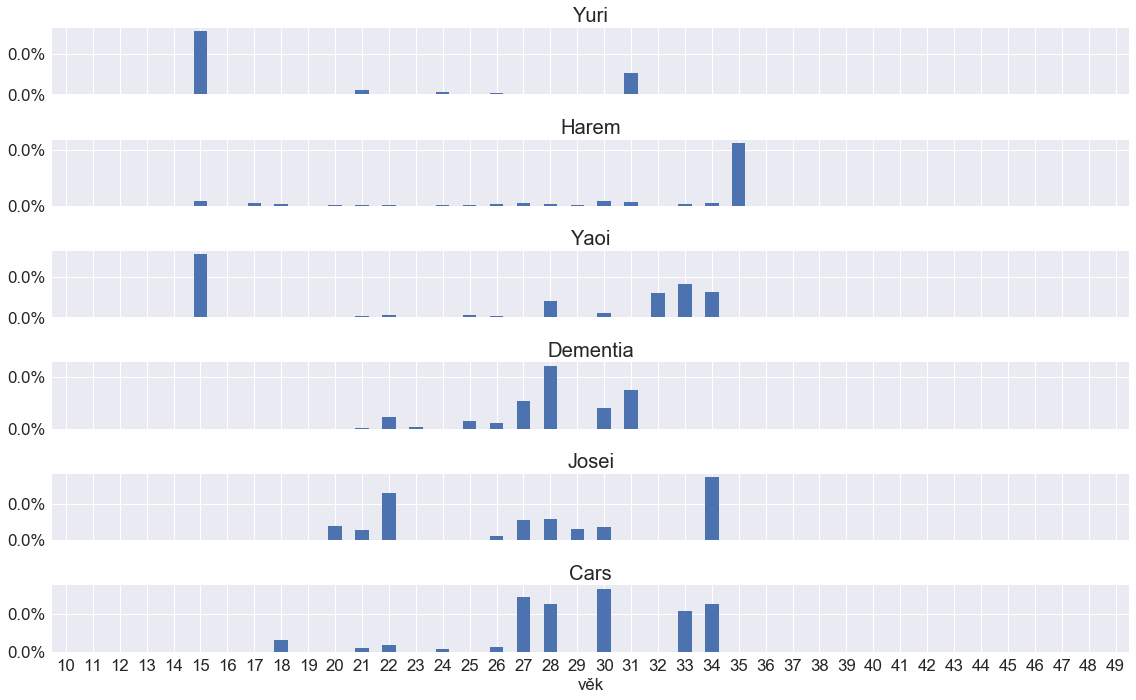

In [45]:
fig, ax = plt.subplots(len(dependent_genres), 1, sharex=True, figsize=(16, 10))
for i, genre in enumerate(dependent_genres):
    ages_genres[genre].plot(kind='bar', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.tight_layout()
plt.xticks(rotation=0)
plt.xlabel('věk')
plt.savefig('graphs/uzivatele-vek-nejrozdilnejsi-bar.png', bbox_inches="tight")

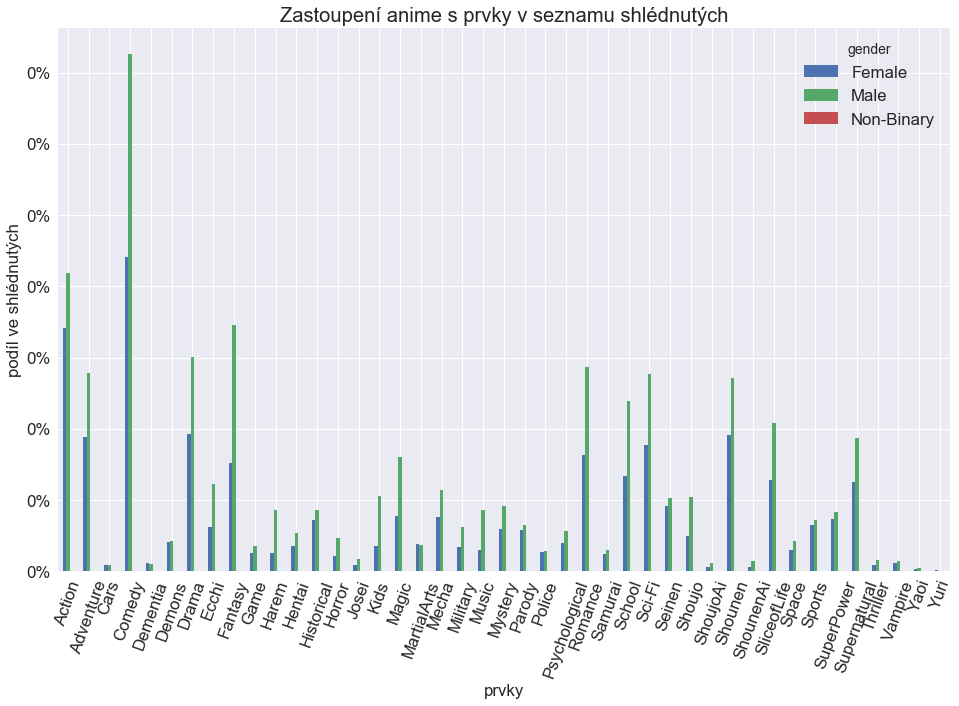

In [46]:
genders_genres.T.plot(kind='bar', figsize=(16, 10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns[y].replace('completed_', '')))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-pohlavi-bar.png', bbox_inches="tight")

In [47]:
genders_genres[completed_columns].apply(entropy).sort_values()

completed_Harem            0.541440
completed_Kids             0.560980
completed_Music            0.566365
completed_ShounenAi        0.609987
completed_Fantasy          0.615135
completed_Horror           0.628430
completed_Shoujo           0.630128
completed_Magic            0.631232
completed_ShoujoAi         0.634085
completed_Ecchi            0.638659
completed_Josei            0.643207
completed_Military         0.646561
completed_School           0.653502
completed_Romance          0.655058
completed_Thriller         0.657234
completed_Comedy           0.663042
completed_SliceofLife      0.664986
completed_Drama            0.668657
completed_Sci-Fi           0.669030
completed_Yaoi             0.669621
completed_Hentai           0.671058
completed_Mystery          0.671422
completed_Mecha            0.672157
completed_Supernatural     0.672914
completed_Adventure        0.674575
completed_Space            0.675440
completed_Psychological    0.676863
completed_Game             0

In [48]:
genders_genres[completed_columns].apply(np.var).sort_values(ascending=False)

completed_Comedy           8.939667e-10
completed_Action           3.302530e-10
completed_Fantasy          2.006930e-10
completed_Drama            1.547563e-10
completed_Romance          1.383376e-10
completed_Adventure        1.346398e-10
completed_Sci-Fi           1.316130e-10
completed_Shounen          1.292333e-10
completed_School           9.542652e-11
completed_SliceofLife      7.337204e-11
completed_Supernatural     6.088554e-11
completed_Magic            4.304106e-11
completed_Ecchi            2.501743e-11
completed_Mecha            2.258892e-11
completed_Seinen           2.126085e-11
completed_Kids             1.950305e-11
completed_Shoujo           1.794459e-11
completed_Historical       1.438272e-11
completed_Mystery          1.436283e-11
completed_SuperPower       1.366739e-11
completed_Harem            1.306896e-11
completed_Music            1.265416e-11
completed_Sports           1.050913e-11
completed_Parody           8.440167e-12
completed_Military         6.503322e-12


In [49]:
arr = np.ones(genders_genres.index.size)
entropy(arr / arr.sum())

1.0986122886681096

In [50]:
# variance is better than entropy now
dependent_genres = genders_genres[completed_columns].apply(np.var).sort_values(ascending=False).index[0:12]

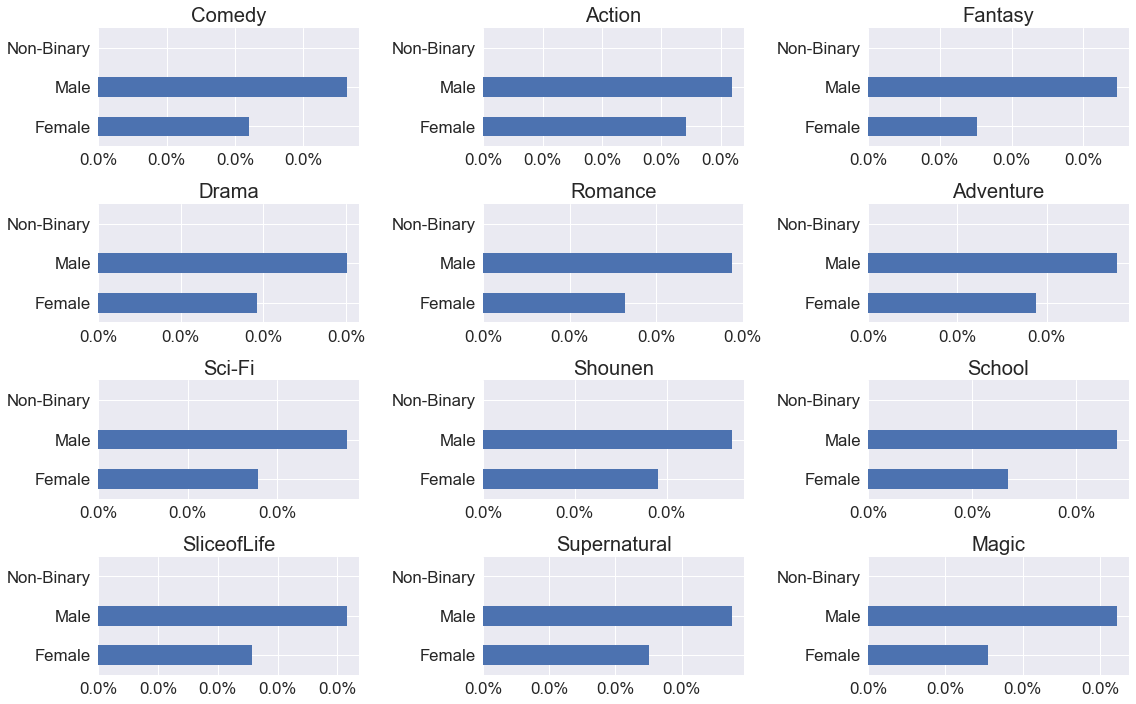

In [51]:
sqrt_num = np.ceil(np.sqrt(len(dependent_genres))).astype('int')
#fig, ax = plt.subplots(sqrt_num, sqrt_num, figsize=(16, 10), squeeze=False)
fig, ax = plt.subplots(4, 3, figsize=(16, 10), squeeze=False)
ax = ax.flatten()
for i, genre in enumerate(dependent_genres):
    genders_genres[genre].plot(kind='barh', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax[i].set_ylabel('')
plt.tight_layout()
#plt.subplots_adjust()
#plt.xticks(rotation=70)
plt.savefig('graphs/uzivatele-pohlavi-bar-jednotlive.png', bbox_inches="tight")

In [52]:
### and now binning ages into equi-sized bins
age_bins, intervals = pd.qcut(users['age'], 10, retbins=True)
intervals

array([10., 20., 21., 23., 24., 25., 26., 27., 29., 31., 49.])

In [53]:
age_bins.value_counts()
# these intervals suck, they fit 10-20 into one interval

(21.0, 23.0]     17871
(9.999, 20.0]    16448
(27.0, 29.0]     13788
(23.0, 24.0]      9760
(24.0, 25.0]      9379
(25.0, 26.0]      9231
(31.0, 49.0]      8927
(26.0, 27.0]      8383
(29.0, 31.0]      7690
(20.0, 21.0]      7234
Name: age, dtype: int64

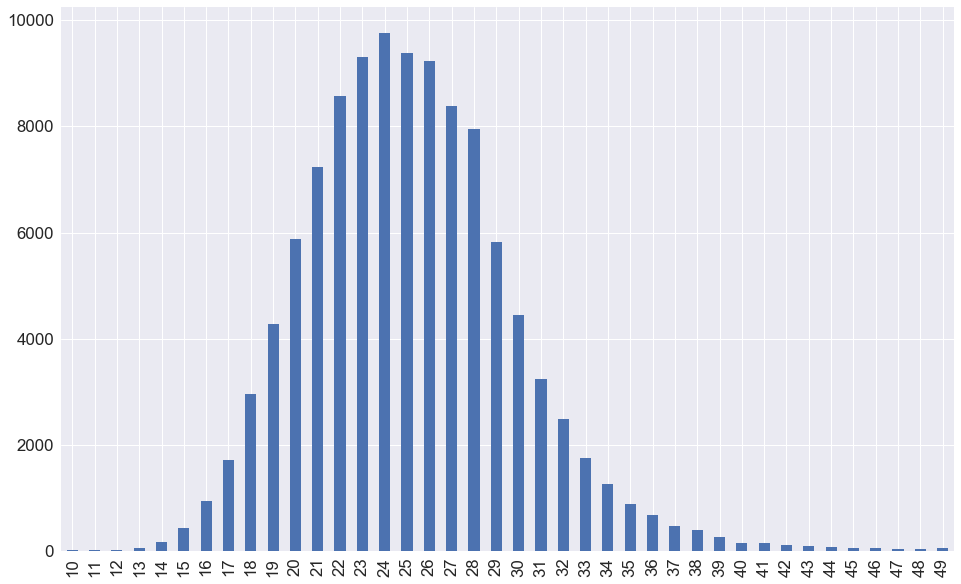

In [54]:
users_ages_completed['age'].value_counts().sort_index().plot(kind='bar', figsize=(16, 10))

In [55]:
bins = [9, 14, 17, 20, 23, 26, 30, 40, 50]
pd.cut(users_ages_completed['age'], bins, right=True).value_counts()
# hand-crafted by intuition

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age, dtype: int64

In [56]:
users_ages_completed['age_bin'] = pd.cut(users_ages_completed['age'], bins, right=True).astype(str)

In [57]:
users_ages_completed['age_bin'].value_counts()

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age_bin, dtype: int64

In [58]:
def tree_to_table(clf, target_column):
    def expand_node(curr_node, prefix):
        # three is balanced
        thr_percent = "{0:.1%}".format(threshold[curr_node])
        fname = fnames[feature[curr_node]]
        if children_left[curr_node] == -1 and children_right[curr_node] == -1:
            return [prefix], [targets[curr_node]], [value[curr_node, 0, :]]
        l_res, l_target, l_distr = expand_node(children_left[curr_node], prefix + [fname + ' <= ' + thr_percent])
        r_res, r_target, r_distr = expand_node(children_right[curr_node], prefix + [fname + ' > ' + thr_percent])
        return l_res + r_res, l_target + r_target, l_distr + r_distr

    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    fnames = [i.replace('completed_', '') for i in completed_columns]
    targets = [target_names[np.argmax(v)] for v in value]
    paths, classes, distr = expand_node(0, [])
    distr = np.array(distr)
    indices = pd.MultiIndex.from_tuples(paths)
    df = pd.DataFrame({target_column: classes, 'precision': (distr.max(axis=1) / distr.sum(axis=1))},
                      index=indices)
    df['precision'] = df['precision'].apply(lambda x: "{0:.2f}%".format(x * 100))
    # precision in classification terminology is # correctly classified / # totally classified (correctly + incorrectly)
    return df

In [59]:
# guessing gender based on completed genres histogram
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.88      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.51      0.33      0.26    108711
weighted avg       0.73      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


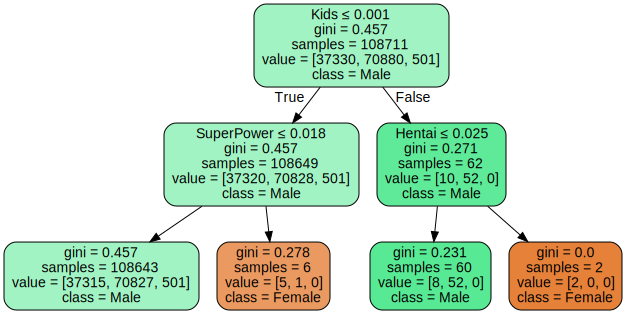

In [60]:
tree.export_graphviz(clf, out_file='gender_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [61]:
tree_to_table(clf, 'gender')

gender precision
Kids <= 0.1% SuperPower <= 1.8%    Male    65.19%
             SuperPower > 1.8%   Female    83.33%
Kids > 0.1%  Hentai <= 2.5%        Male    86.67%
             Hentai > 2.5%       Female   100.00%

In [62]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.00      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.22      0.33      0.26    108711
weighted avg       0.43      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Kids <= 0.1%   Male    65.19%
Kids > 0.1%    Male    83.87%

In [63]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.88      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.51      0.33      0.26    108711
weighted avg       0.73      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Kids <= 0.1% SuperPower <= 1.8%    Male    65.19%
             SuperPower > 1.8%   Female    83.33%
Kids > 0.1%  Hentai <= 2.5%        Male    86.67%
             Hentai > 2.5%       Female   100.00%

In [64]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       1.00      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.55      0.33      0.26    108711
weighted avg       0.77      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Kids <= 0.1% SuperPower <= 1.8% Drama <= 0.9%       Male    65.19%
                                Drama > 0.9%        Male   100.00%
             SuperPower > 1.8%  Romance <= 23.6%  Female   100.00%
                                Romance > 23.6%     Male   100.00%
Kids > 0.1%  Hentai <= 2.5%     School <= 5.9%      Male    88.14%
                                School > 5.9%     Female   100.00%
             Hentai > 2.5%      NaN               Female   100.00%

In [65]:
import pickle
with open('tree_clf.rick', 'wb+') as f:
    pickle.dump(clf, f)

In [66]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.93      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.53      0.33      0.26    108711
weighted avg       0.74      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Kids <= 0.1% SuperPower <= 1.8% Drama <= 0.9%    Mystery <= 0.8%    Male   
                                                 Mystery > 0.8%   Female   
                                Drama > 0.9%     NaN                Male   
             SuperPower > 1.8%  Fantasy <= 15.5% NaN              Female   
                                Fantasy > 15.5%  NaN                Male   
Kids > 0.1%  Hentai <= 2.5%     Thriller <= 1.2% School <= 5.9%     Male   
                                                 School > 5.9%    Female   
                                Thriller > 1.2%  NaN              Female   
             Hentai > 2.5%      NaN              NaN              Female   

                                                                 precision  
Kids <= 0.1% SuperPower <= 1.8% Drama <= 0.9%    Mystery <= 0.8%    65.19%  
                                                 Mystery > 0.8%     80.00%  
                                Drama > 0.9%     NaN               100.00%  
             SuperPower > 1.8%  Fantasy <= 15.5% NaN               100.00%  
                                Fantasy > 15.5%  NaN               100.00%  
Kids > 0.1%  Hentai <= 2.5%     Thriller <= 1.2% School <= 5.9%     89.66%  
                                                 School > 5.9%     100.00%  
                                Thriller > 1.2%  NaN               100.00%  
             Hentai > 2.5%      NaN              NaN               100.00%

In [67]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.88      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.51      0.33      0.26    108711
weighted avg       0.73      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Kids <= 0.1% SuperPower <= 1.8% Drama <= 0.9%  Supernatural <= 1.3% Magic <= 0.1%      Male   
                                                                    Magic > 0.1%       Male   
                                               Supernatural > 1.3%  Romance <= 0.9%    Male   
                                                                    Romance > 0.9%   Female   
                                Drama > 0.9%   NaN                  NaN                Male   
             SuperPower > 1.8%  Ecchi <= 7.1%  NaN                  NaN              Female   
                                Ecchi > 7.1%   NaN                  NaN                Male   
Kids > 0.1%  Hentai <= 2.5%     School <= 5.9% Thriller <= 1.2%     Yuri <= 0.1%       Male   
                                                                    Yuri > 0.1%      Female   
                                               Thriller > 1.2%      NaN              Female   
                                School > 5.9%  NaN                  NaN              Female   
             Hentai > 2.5%      NaN            NaN                  NaN              Female   

                                                                                    precision  
Kids <= 0.1% SuperPower <= 1.8% Drama <= 0.9%  Supernatural <= 1.3% Magic <= 0.1%      65.19%  
                                                                    Magic > 0.1%      100.00%  
                                               Supernatural > 1.3%  Romance <= 0.9%   100.00%  
                                                                    Romance > 0.9%    100.00%  
                                Drama > 0.9%   NaN                  NaN               100.00%  
             SuperPower > 1.8%  Ecchi <= 7.1%  NaN                  NaN               100.00%  
                                Ecchi > 7.1%   NaN                  NaN               100.00%  
Kids > 0.1%  Hentai <= 2.5%     School <= 5.9% Thriller <= 1.2%     Yuri <= 0.1%       92.59%  
                                                                    Yuri > 0.1%        50.00%  
                                               Thriller > 1.2%      NaN               100.00%  
                                School > 5.9%  NaN                  NaN               100.00%  
             Hentai > 2.5%      NaN            NaN                  NaN               100.00%

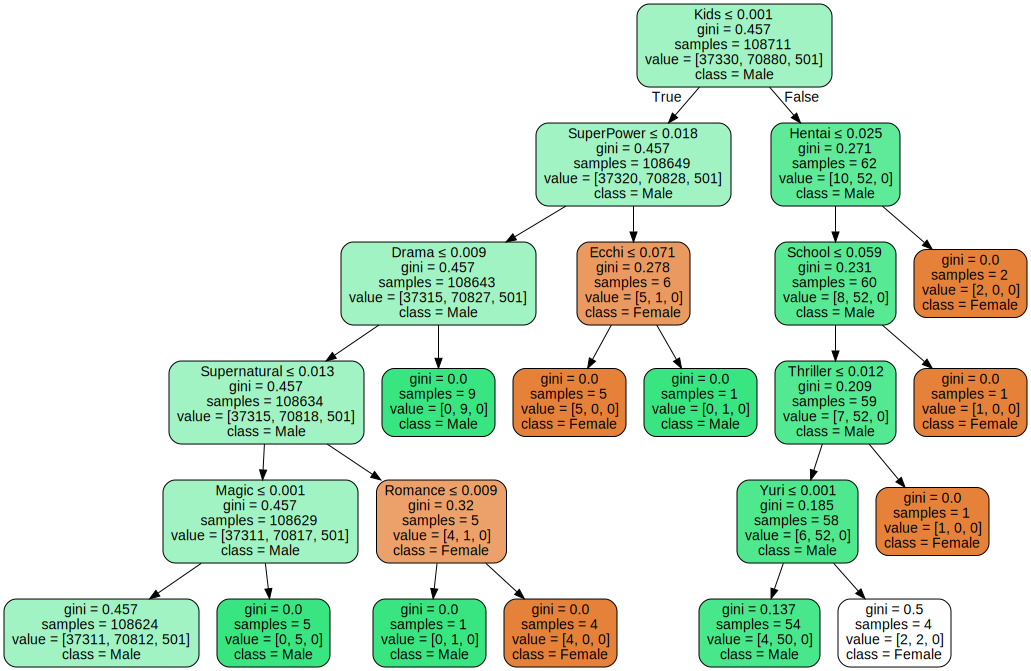

In [68]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [69]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       1.00      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.55      0.33      0.26    108711
weighted avg       0.77      0.65      0.51    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       1.00      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.55      0.33      0.26    108711
weighted avg       0.77      0.65      0.52    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.95      0.00      0.00     37330
        Male       0.65      1.00      0.79     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.65      0.65      0.65    108711
   macro avg       0.53      0.33      0.26    108711
weighted avg       0.75      0.65      0.52    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
# first, trying some depths

In [73]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      3077
    (17, 20]       0.00      0.00      0.00     13097
    (20, 23]       0.00      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       0.60      0.00      0.00     26617
    (14, 17]       0.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.11      0.13      0.05    108711
weighted avg       0.22      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      3077
    (17, 20]       0.33      0.00      0.00     13097
    (20, 23]       0.00      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       0.79      0.00      0.00     26617
    (14, 17]       0.55      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.24      0.13      0.05    108711
weighted avg       0.36      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      3077
    (17, 20]       0.62      0.00      0.00     13097
    (20, 23]       0.62      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       0.94      0.00      0.00     26617
    (14, 17]       0.67      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.39      0.13      0.05    108711
weighted avg       0.59      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.69      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       1.00      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.49      0.13      0.05    108711
weighted avg       0.70      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.50      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.89      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       0.81      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.56      0.13      0.05    108711
weighted avg       0.71      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       1.00      0.00      0.00      3077
    (17, 20]       0.82      0.00      0.00     13097
    (20, 23]       0.83      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       1.00      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.61      0.13      0.05    108711
weighted avg       0.74      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       1.00      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.94      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       0.96      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.65      0.13      0.05    108711
weighted avg       0.78      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       1.00      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.89      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       1.00      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.64      0.13      0.05    108711
weighted avg       0.77      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       1.00      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.94      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       1.00      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.65      0.13      0.05    108711
weighted avg       0.79      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
# 5 depth seems like nice tradeoff based 
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      3077
    (17, 20]       1.00      0.00      0.00     13097
    (20, 23]       0.69      0.00      0.00     25105
    (30, 40]       0.26      1.00      0.41     28370
    (23, 26]       1.00      0.00      0.00     26617
    (14, 17]       1.00      0.00      0.00     11555
    (40, 50]       0.00      0.00      0.00       616
     (9, 14]       0.00      0.00      0.00       274

   micro avg       0.26      0.26      0.26    108711
   macro avg       0.49      0.13      0.05    108711
weighted avg       0.70      0.26      0.11    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


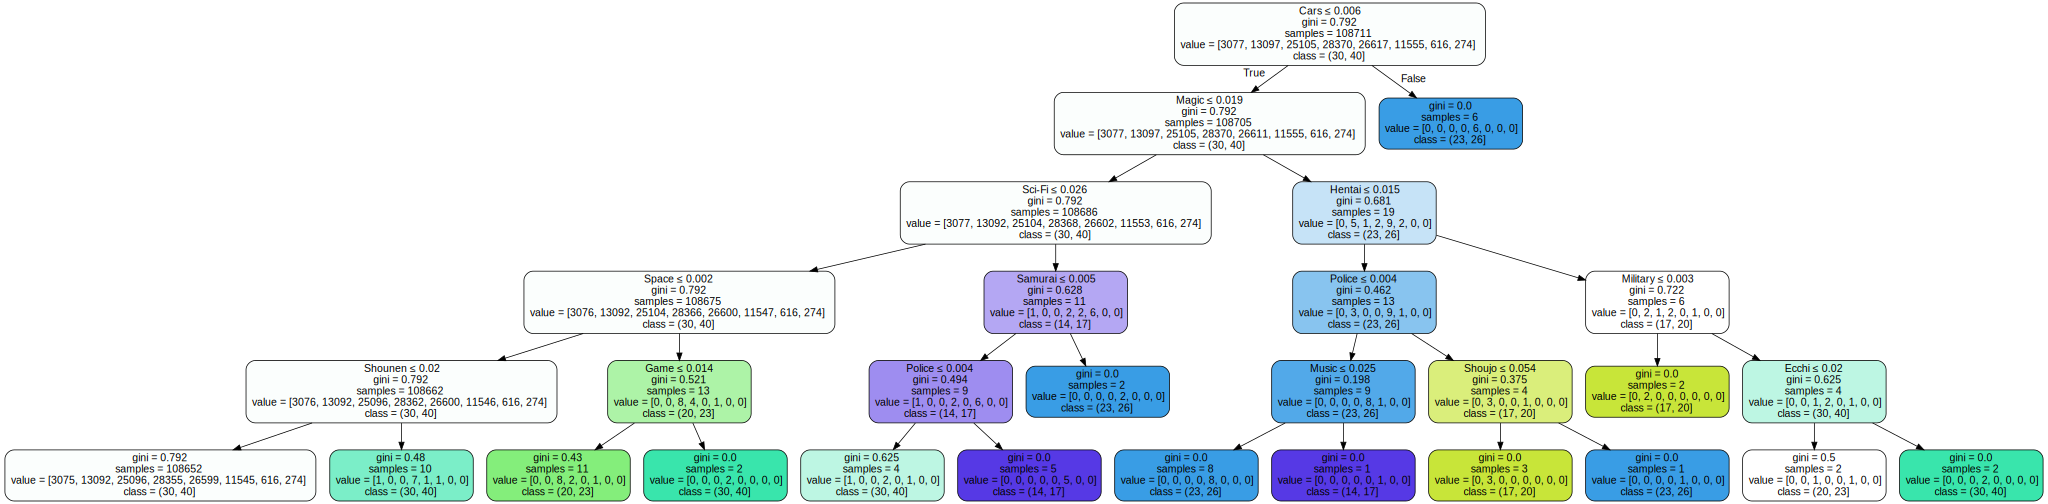

In [83]:
tree.export_graphviz(clf, out_file='age_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [84]:
tree_to_table(clf, 'age')

age  \
Cars <= 0.6% Magic <= 1.9% Sci-Fi <= 2.6% Space <= 0.2%    Shounen <= 2.0%  (30, 40]   
                                                           Shounen > 2.0%   (30, 40]   
                                          Space > 0.2%     Game <= 1.4%     (20, 23]   
                                                           Game > 1.4%      (30, 40]   
                           Sci-Fi > 2.6%  Samurai <= 0.5%  Police <= 0.4%   (30, 40]   
                                                           Police > 0.4%    (14, 17]   
                                          Samurai > 0.5%   NaN              (23, 26]   
             Magic > 1.9%  Hentai <= 1.5% Police <= 0.4%   Music <= 2.5%    (23, 26]   
                                                           Music > 2.5%     (14, 17]   
                                          Police > 0.4%    Shoujo <= 5.4%   (17, 20]   
                                                           Shoujo > 5.4%    (23, 26]   
                           Hentai > 1.5%  Military <= 0.3% NaN              (17, 20]   
                                          Military > 0.3%  Ecchi <= 2.0%    (20, 23]   
                                                           Ecchi > 2.0%     (30, 40]   
Cars > 0.6%  NaN           NaN            NaN              NaN              (23, 26]   

                                                                           precision  
Cars <= 0.6% Magic <= 1.9% Sci-Fi <= 2.6% Space <= 0.2%    Shounen <= 2.0%    26.10%  
                                                           Shounen > 2.0%     70.00%  
                                          Space > 0.2%     Game <= 1.4%       72.73%  
                                                           Game > 1.4%       100.00%  
                           Sci-Fi > 2.6%  Samurai <= 0.5%  Police <= 0.4%     50.00%  
                                                           Police > 0.4%     100.00%  
                                          Samurai > 0.5%   NaN               100.00%  
             Magic > 1.9%  Hentai <= 1.5% Police <= 0.4%   Music <= 2.5%     100.00%  
                                                           Music > 2.5%      100.00%  
                                          Police > 0.4%    Shoujo <= 5.4%    100.00%  
                                                           Shoujo > 5.4%     100.00%  
                           Hentai > 1.5%  Military <= 0.3% NaN               100.00%  
                                          Military > 0.3%  Ecchi <= 2.0%      50.00%  
                                                           Ecchi > 2.0%      100.00%  
Cars > 0.6%  NaN           NaN            NaN              NaN               100.00%

### genres in completed animests, compared with genres production

In [85]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

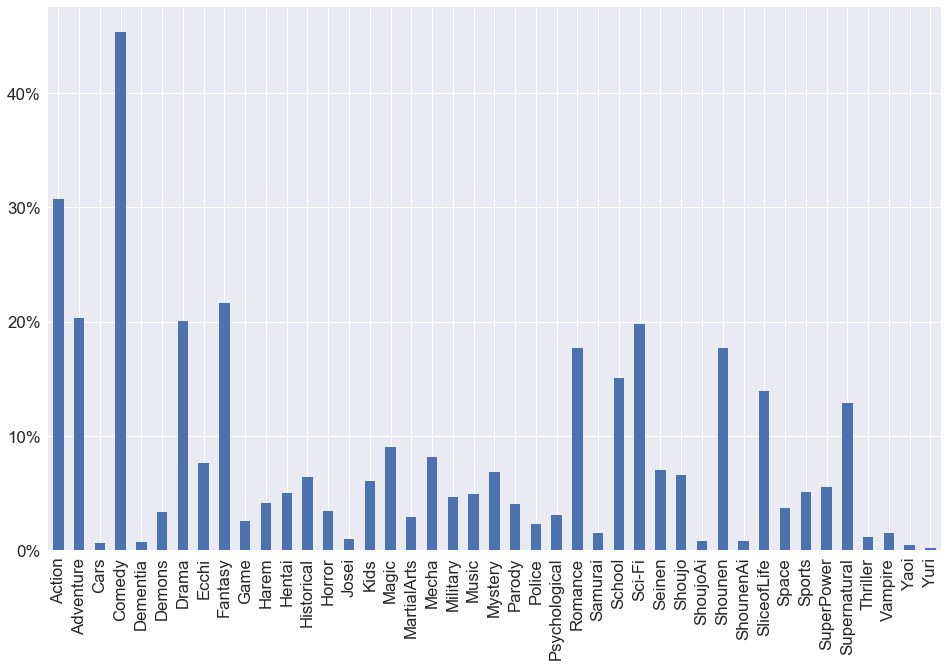

In [86]:
(animes_genres['genre'].value_counts() / animes.shape[0]).sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

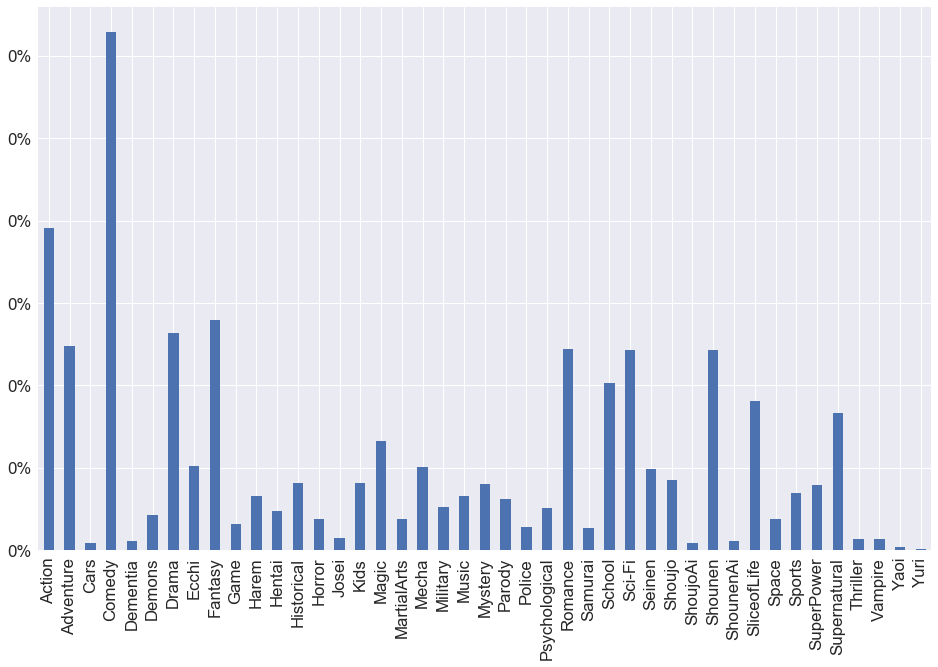

In [87]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

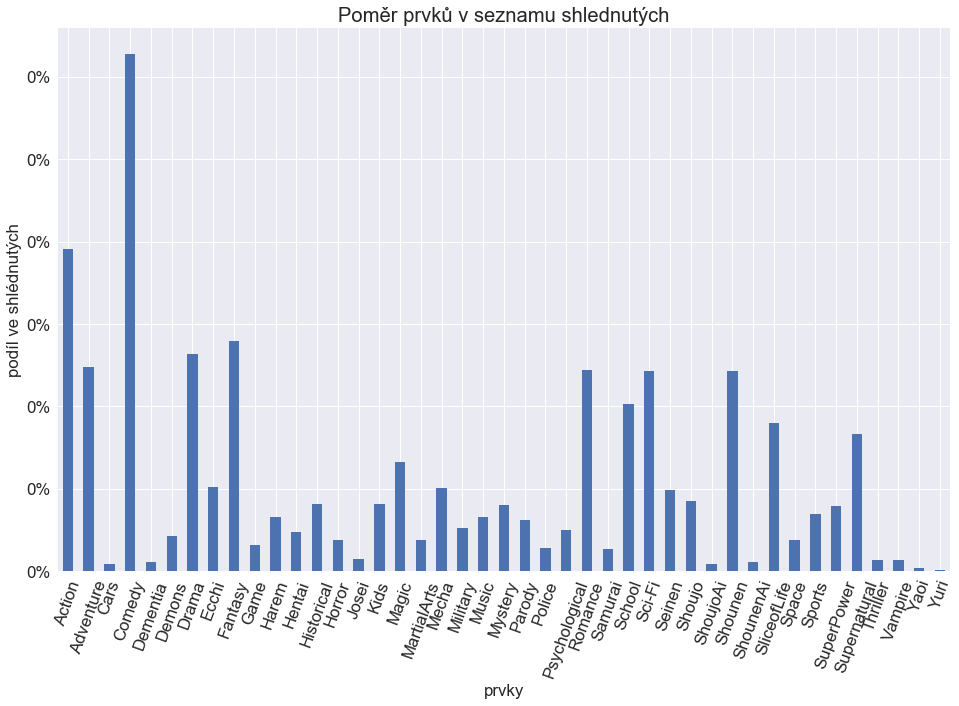

In [88]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Poměr prvků v seznamu shlednutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres.png', bbox_inches="tight")

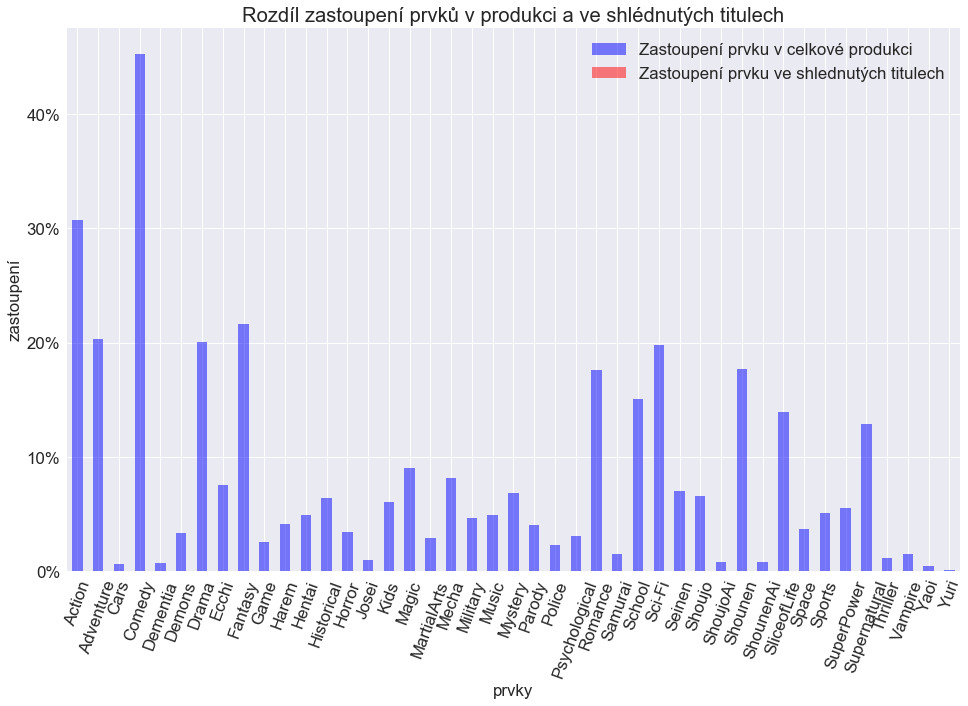

In [89]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
anime_genres_percent = (animes_genres['genre'].value_counts() / animes.shape[0]).sort_index()
anime_genres_percent.plot(kind='bar', figsize=(16, 10), title='Rozdíl zastoupení prvků v produkci a ve shlédnutých titulech', color='blue', alpha=0.5, label='Zastoupení prvku v celkové produkci')
users_genres_percent = users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index()
users_genres_percent.plot(kind='bar', color='red', alpha=0.5, label='Zastoupení prvku ve shlednutých titulech')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=1)
plt.xticks(rotation=70)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres-comparison.png', bbox_inches="tight")

In [90]:
# using new classes for users, both gender and age bin will be class, will try whether decision trees will have bigger success
users_ages_genders_completed = users_ages_completed.join(users_genders_completed['gender'])
users_ages_genders_completed['age_and_gender'] = users_ages_genders_completed['age_bin'] + ', ' + users_ages_genders_completed['gender']

In [91]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.17      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.00      0.00      0.00      9499
    (23, 26], Female       0.67      0.00      0.00     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.00      0.00      0.00     10772
    (14, 17], Female       0.00      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.00      0.00      0.00      8233
       (9, 14], Male       0.17      1.00      0.29     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age precision
Fantasy <= 3.7% Josei <= 0.5%      (9, 14], Male    16.85%
                Josei > 0.5%    (23, 26], Female    66.67%
Fantasy > 3.7%  Hentai <= 1.7%     (9, 14], Male    63.16%
                Hentai > 1.7%   (20, 23], Female    16.67%

In [92]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.30      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       1.00      0.00      0.00      9499
    (23, 26], Female       0.80      0.00      0.00     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.60      0.00      0.00     10772
    (14, 17], Female       0.00      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.00      0.00      0.00      8233
       (9, 14], Male       0.17      1.00      0.29     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age precision
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0%     (9, 14], Male    16.85%
                               MartialArts > 1.0%   (30, 40], Female    60.00%
                Josei > 0.5%   Action <= 2.5%          (9, 14], Male   100.00%
                               Action > 2.5%        (23, 26], Female    80.00%
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%         (9, 14], Male    78.57%
                               Vampire > 0.4%       (20, 23], Female    40.00%
                Hentai > 1.7%  Romance <= 1.7%        (20, 23], Male   100.00%
                               Romance > 1.7%       (20, 23], Female    20.00%

In [93]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.75      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       1.00      0.00      0.00      9499
    (23, 26], Female       0.83      0.00      0.00     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       1.00      0.00      0.00     10772
    (14, 17], Female       1.00      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.50      0.00      0.00      8233
       (9, 14], Male       0.17      1.00      0.29     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0% Parody <= 1.4%           (9, 14], Male   
                                                   Parody > 1.4%            (9, 14], Male   
                               MartialArts > 1.0%  Horror <= 0.4%        (30, 40], Female   
                                                   Horror > 0.4%         (14, 17], Female   
                Josei > 0.5%   Drama <= 0.7%       NaN                     (40, 50], Male   
                               Drama > 0.7%        Mecha <= 1.6%         (23, 26], Female   
                                                   Mecha > 1.6%             (9, 14], Male   
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%     Historical <= 0.5%       (9, 14], Male   
                                                   Historical > 0.5%        (9, 14], Male   
                               Vampire > 0.4%      Supernatural <= 4.7%  (20, 23], Female   
                                                   Supernatural > 4.7%     (40, 50], Male   
                Hentai > 1.7%  Military <= 0.3%    Historical <= 0.9%      (20, 23], Male   
                                                   Historical > 0.9%     (20, 23], Female   
                               Military > 0.3%     Seinen <= 1.2%        (14, 17], Female   
                                                   Seinen > 1.2%         (23, 26], Female   

                                                                        precision  
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0% Parody <= 1.4%          16.84%  
                                                   Parody > 1.4%           66.67%  
                               MartialArts > 1.0%  Horror <= 0.4%         100.00%  
                                                   Horror > 0.4%          100.00%  
                Josei > 0.5%   Drama <= 0.7%       NaN                    100.00%  
                               Drama > 0.7%        Mecha <= 1.6%          100.00%  
                                                   Mecha > 1.6%           100.00%  
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%     Historical <= 0.5%      50.00%  
                                                   Historical > 0.5%       90.00%  
                               Vampire > 0.4%      Supernatural <= 4.7%   100.00%  
                                                   Supernatural > 4.7%     33.33%  
                Hentai > 1.7%  Military <= 0.3%    Historical <= 0.9%     100.00%  
                                                   Historical > 0.9%       50.00%  
                               Military > 0.3%     Seinen <= 1.2%         100.00%  
                                                   Seinen > 1.2%           50.00%

In [94]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.50      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       1.00      0.00      0.00      4337
    (20, 23], Female       1.00      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       1.00      0.00      0.00      9499
    (23, 26], Female       0.71      0.00      0.00     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       1.00      0.00      0.00     10772
    (14, 17], Female       1.00      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.67      0.00      0.00      8233
       (9, 14], Male       0.17      1.00      0.29     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0% Parody <= 1.4%     Demons <= 1.2%               (9, 14], Male   
                                                                      Demons > 1.2%               (17, 20], Male   
                                                   Parody > 1.4%      Historical <= 1.5%           (9, 14], Male   
                                                                      Historical > 1.5%           (26, 30], Male   
                               MartialArts > 1.0%  Shoujo <= 1.1%     NaN                       (30, 40], Female   
                                                   Shoujo > 1.1%      NaN                       (14, 17], Female   
                Josei > 0.5%   Kids <= 1.0%        Drama <= 0.7%      NaN                         (40, 50], Male   
                                                   Drama > 0.7%       NaN                       (23, 26], Female   
                               Kids > 1.0%         NaN                NaN                          (9, 14], Male   
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%     Historical <= 0.5% Supernatural <= 0.7%         (9, 14], Male   
                                                                      Supernatural > 0.7%   (23, 26], Non-Binary   
                                                   Historical > 0.5%  Drama <= 0.5%             (30, 40], Female   
                                                                      Drama > 0.5%                 (9, 14], Male   
                               Vampire > 0.4%      Historical <= 1.6% NaN                       (20, 23], Female   
                                                   Historical > 1.6%  Romance <= 8.7%       (23, 26], Non-Binary   
                                                                      Romance > 8.7%              (40, 50], Male   
                Hentai > 1.7%  Shounen <= 1.8%     NaN                NaN                         (20, 23], Male   
                               Shounen > 1.8%      Game <= 0.2%       NaN                       (20, 23], Female   
                                                   Game > 0.2%        Samurai <= 0.1%           (14, 17], Female   
                                                                      Samurai > 0.1%            (23, 26], Female   

                                                                                           precision  
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0% Parody <= 1.4%     Demons <= 1.2%          16.85%  
                                                                      Demons > 1.2%          100.00%  
                                                   Parody > 1.4%      Historical <= 1.5%     100.00%  
                                                                      Historical > 1.5%       50.00%  
                               MartialArts > 1.0%  Shoujo <= 1.1%     NaN                    100.00%  
                                                   Shoujo > 1.1%      NaN                    100.00%  
                Josei > 0.5%   Kids <= 1.0%        Drama <= 0.7%      NaN                    100.00%  
                                                   Drama > 0.7%       NaN                    100.00%  
                               Kids > 1.0%         NaN                NaN                    100.00%  
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%     Historical <= 0.5% Supernatural <= 0.7%   100.00%  
                                                                      Supernatural > 0.7%    100.00%  
                                                   Historical > 0.5%  Drama <= 0.5%          100.00%  
                                                                      Drama > 0.5%           100.00%  
                               Vampire > 0.4%      Historical <= 1.6% NaN                    100.00%  
                                                   Historical > 1.6%  Romance <= 8.7%        100.00%  
             

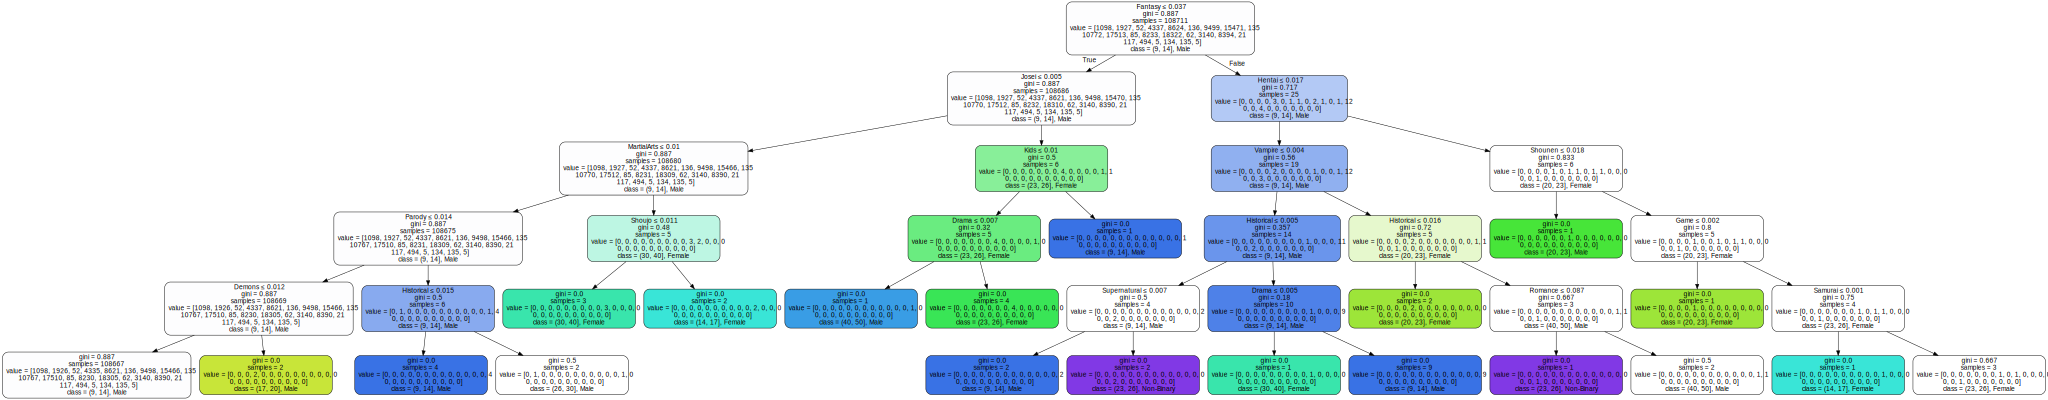

In [95]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_genders_completed['age_and_gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [96]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       1.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       1.00      0.00      0.00      4337
    (20, 23], Female       1.00      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       1.00      0.00      0.00      9499
    (23, 26], Female       1.00      0.00      0.00     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       1.00      0.00      0.00     10772
    (14, 17], Female       0.67      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       1.00      0.00      0.00      8233
       (9, 14], Male       0.17      1.00      0.29     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0%   Parody <= 1.4%     Drama <= 3.2%  Fantasy <= 2.4%          (9, 14], Male   
                                                                                       Fantasy > 2.4%        (14, 17], Female   
                                                                        Drama > 3.2%   NaN                     (17, 20], Male   
                                                     Parody > 1.4%      Shoujo <= 0.7% NaN                      (9, 14], Male   
                                                                        Shoujo > 0.7%  Ecchi <= 2.3%           (26, 30], Male   
                                                                                       Ecchi > 2.3%            (40, 50], Male   
                               MartialArts > 1.0%    Space <= 0.4%      NaN            NaN                   (30, 40], Female   
                                                     Space > 0.4%       NaN            NaN                   (14, 17], Female   
                Josei > 0.5%   Drama <= 0.7%         NaN                NaN            NaN                     (40, 50], Male   
                               Drama > 0.7%          Shounen <= 1.4%    NaN            NaN                      (9, 14], Male   
                                                     Shounen > 1.4%     NaN            NaN                   (23, 26], Female   
Fantasy > 3.7%  Hentai <= 1.7% Vampire <= 0.4%       Historical <= 0.5% Parody <= 0.3% NaN                      (9, 14], Male   
                                                                        Parody > 0.3%  NaN               (23, 26], Non-Binary   
                                                     Historical > 0.5%  Drama <= 0.5%  NaN                   (30, 40], Female   
                                                                        Drama > 0.5%   NaN                      (9, 14], Male   
                               Vampire > 0.4%        Music <= 1.1%      Horror <= 2.6% NaN               (23, 26], Non-Binary   
                                                                        Horror > 2.6%  Romance <= 21.3%        (40, 50], Male   
                                                                                       Romance > 21.3%          (9, 14], Male   
                                                     Music > 1.1%       NaN            NaN                   (20, 23], Female   
                Hentai > 1.7%  Psychological <= 0.2% Samurai <= 0.4%    NaN            NaN                   (14, 17], Female   
                                                     Samurai > 0.4%     NaN            NaN                   (20, 23], Female   
                               Psychological > 0.2%  Shoujo <= 0.7%     NaN            NaN               (23, 26], Non-Binary   
                                                     Shoujo > 0.7%      Yuri <= 0.0%   Drama <= 3.8%           (20, 23], Male   
                                                                                       Drama > 3.8%          (23, 26], Female   
                                                                        Yuri > 0.0%    NaN                   (30, 40], Female   

                                                                                                        precision  
Fantasy <= 3.7% Josei <= 0.5%  MartialArts <= 1.0%   Parody <= 1.4%     Drama <= 3.2%  Fantasy <= 2.4%     16.85%  
                                                                                       Fantasy > 2.4%      55.56%  
                                                                        Drama > 3.2%   NaN                100.00%  
                                                     Parody > 1.4%      Shoujo <= 0.7% NaN                100.00%  
                                                                        Shoujo > 0.7%  Ecchi <= 2.3%      100.00%  
                                                            

### nothing interesting in decision trees above, gender does not bring precision into age prediction
### going to measure genre distances by users animelists

<IPython.core.display.Javascript object>


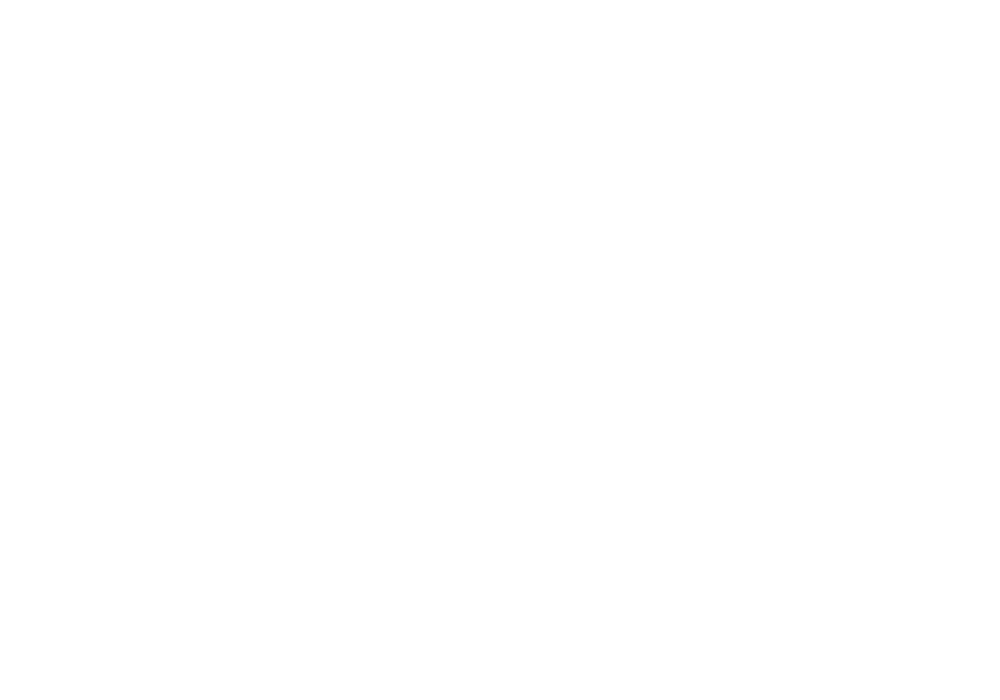

Text(0.5, 0.92, 'users by genres in 3D')

In [97]:
%matplotlib notebook
# doing PCA on genres distribution
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=3)
embeddings = pca.fit_transform(users_ages_genders_completed[completed_columns])

plt.figure(figsize=(10, 7))

# colors per gender
ax = plt.axes(projection='3d')
le = preprocessing.LabelEncoder()
genders = le.fit_transform(users_ages_genders_completed['gender'])
genders = genders.astype(np.int)
colors = plt.cm.Set1(np.unique(genders))
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=1, c=[colors[x] for x in genders])
plt.title("users by genres in 3D")

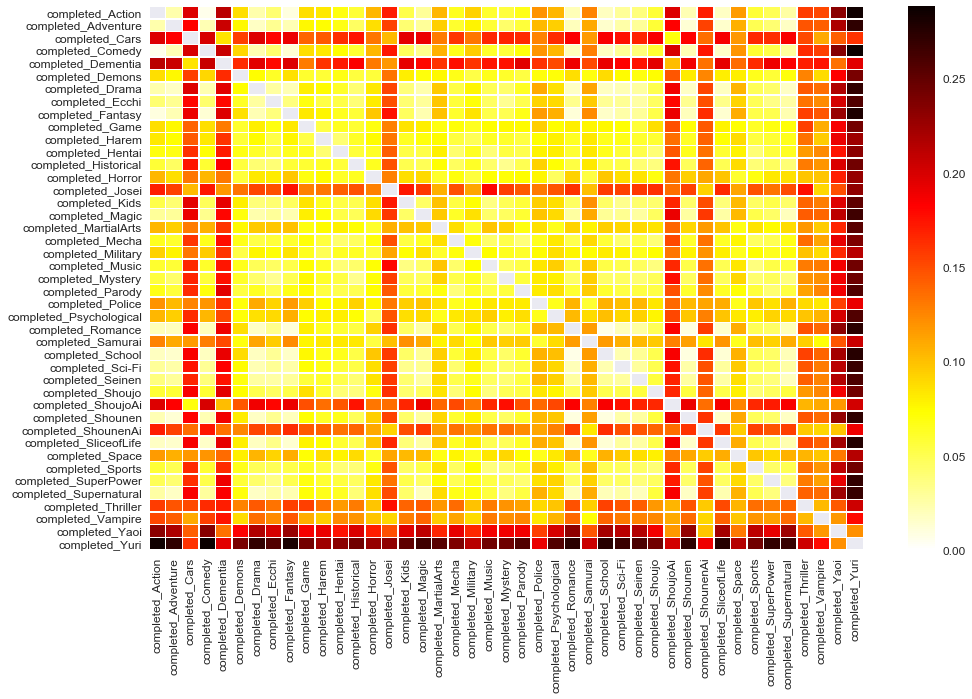

In [98]:
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

# todo: vymyslet co s tím, když je to spojité a ne binární
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
dists = pdist(users_completed[completed_columns].rename(columns=renaming).T > 0, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = users_completed.T.index
dists_df.index = users_completed.T.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

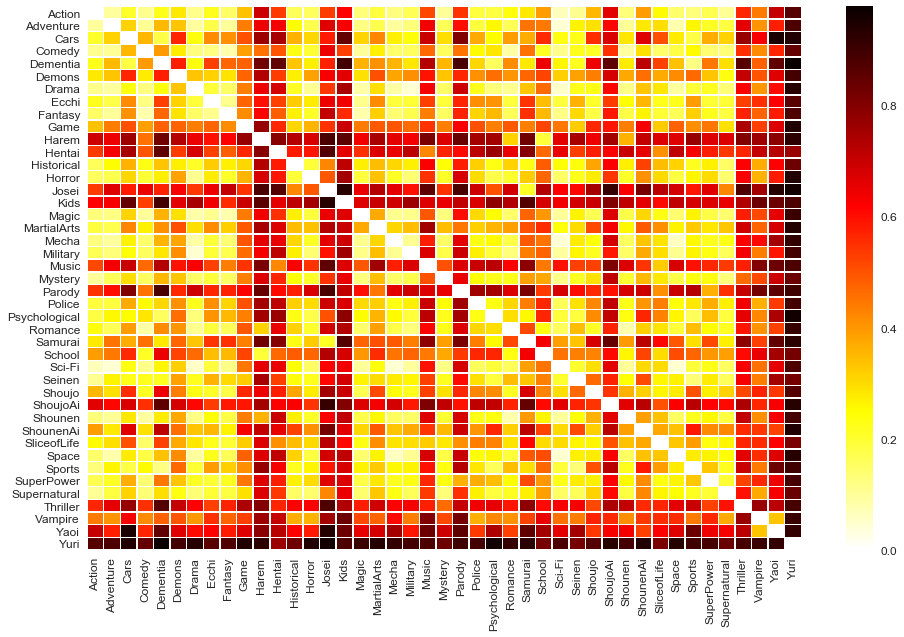

In [99]:
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

90

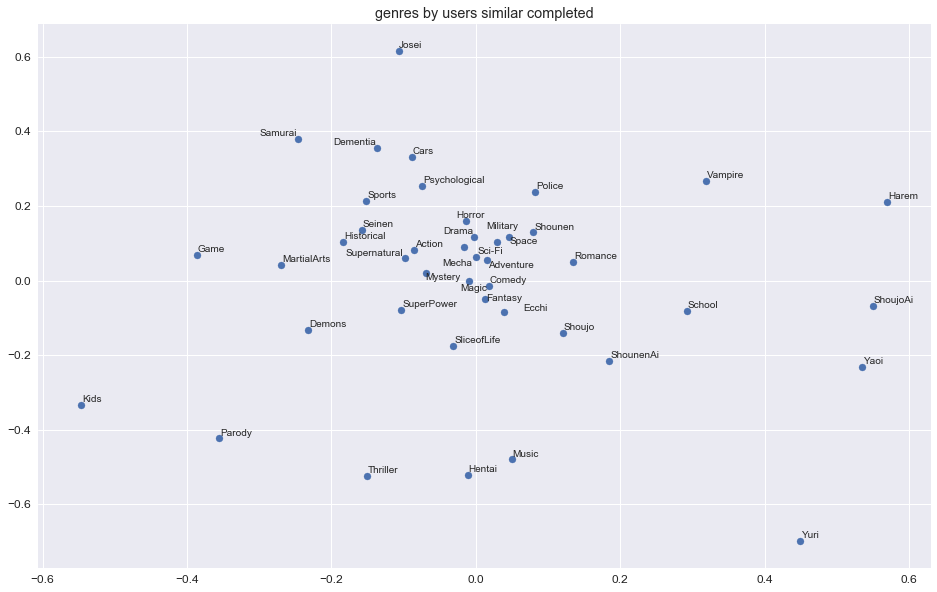

In [100]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

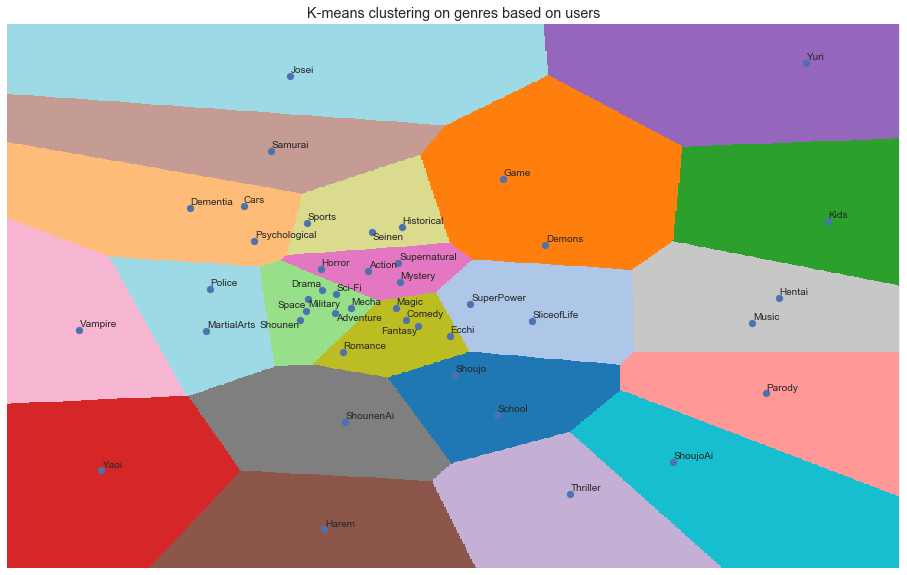

In [101]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

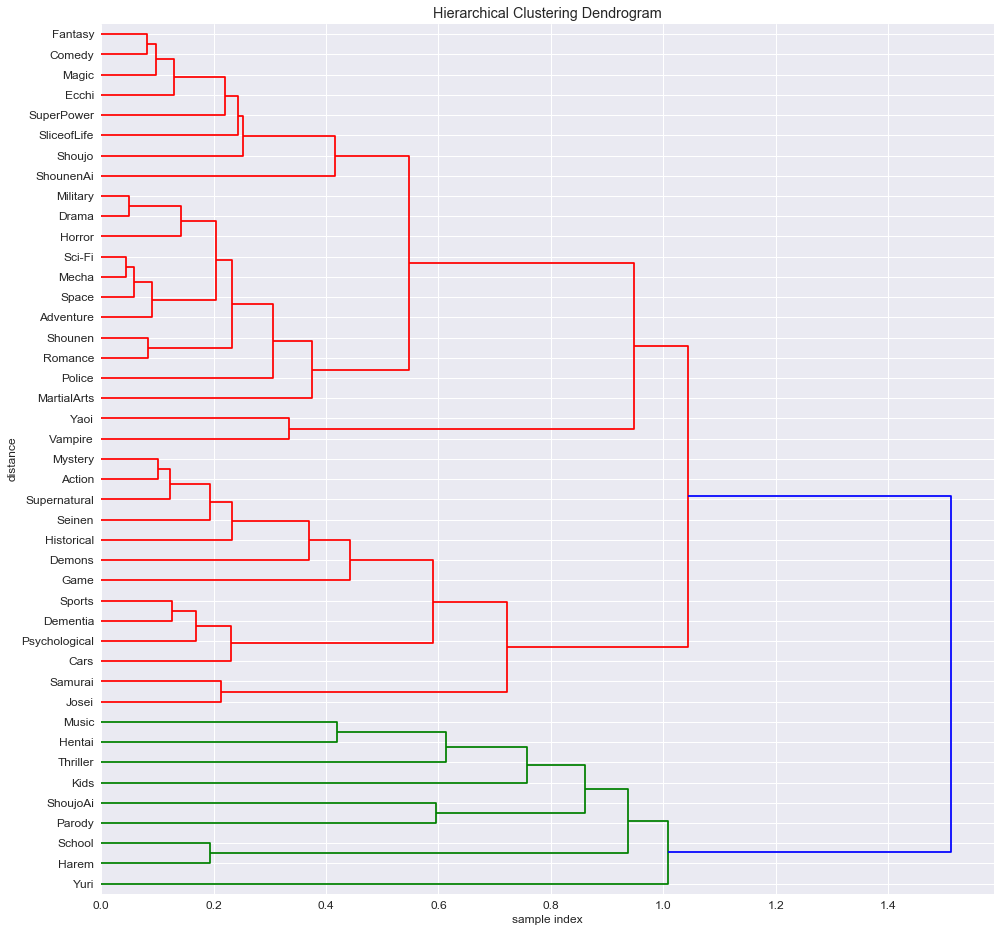

In [102]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

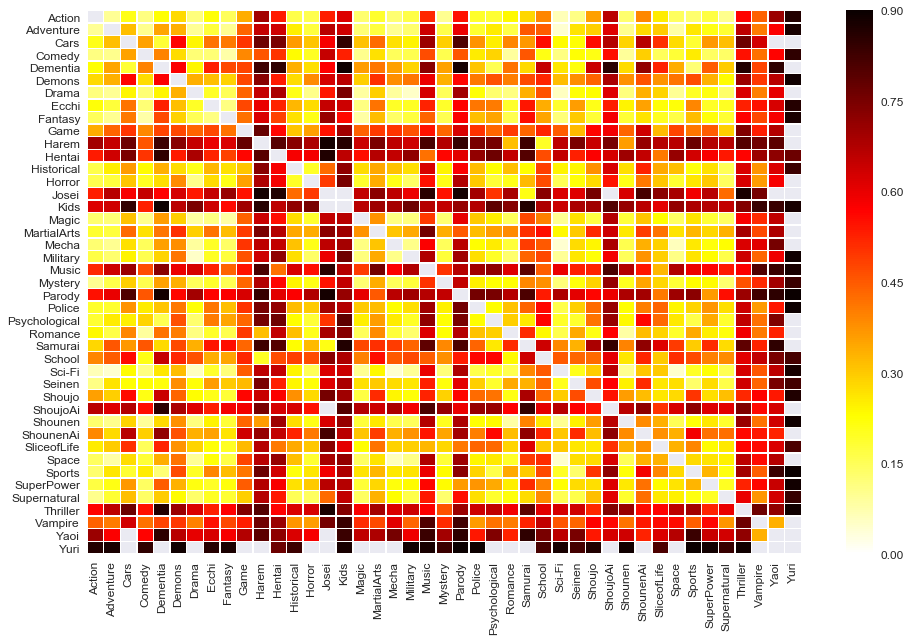

In [103]:
# now with thresholding, more than 0.9 dissimilarity is undefined
f, ax = plt.subplots(figsize=(16, 10))
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [104]:
def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
MovieWriter imagemagick unavailable. Trying to use pillow instead.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


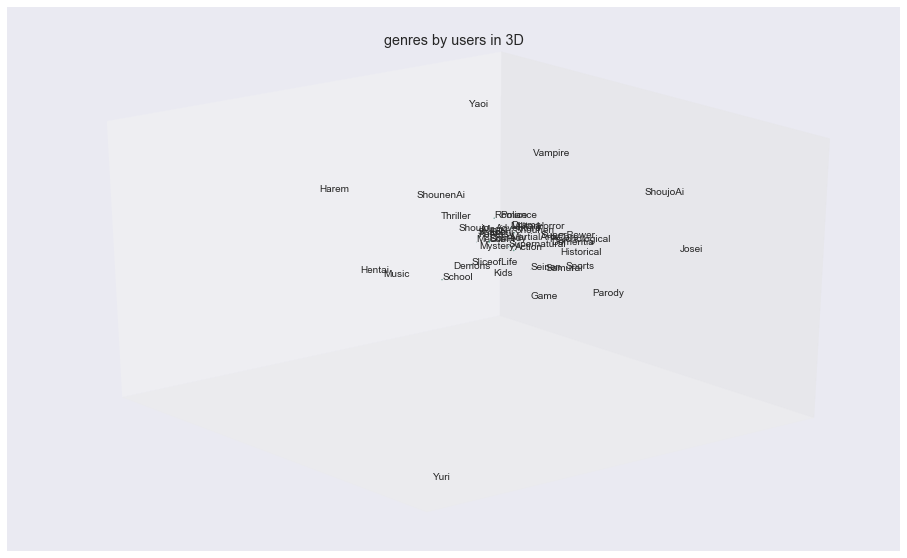

In [105]:
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

plt.title("genres by users in 3D")
points_3d_to_gif(embeddings, genres_users.index, 'genres_users-cosine-MSD', ax, genres_users.sum(axis=1).apply(np.log))

In [106]:
pairs = np.array(list(combinations(genres_users.index, 2)))

# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1-dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_cosine.csv', index=False, sep=',', encoding='utf-8')

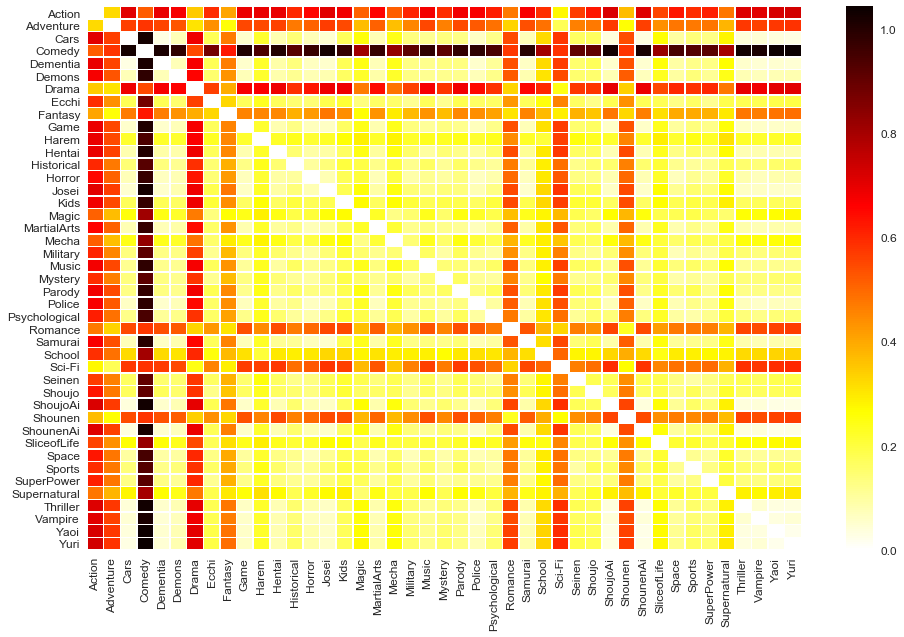

In [107]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'euclidean')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

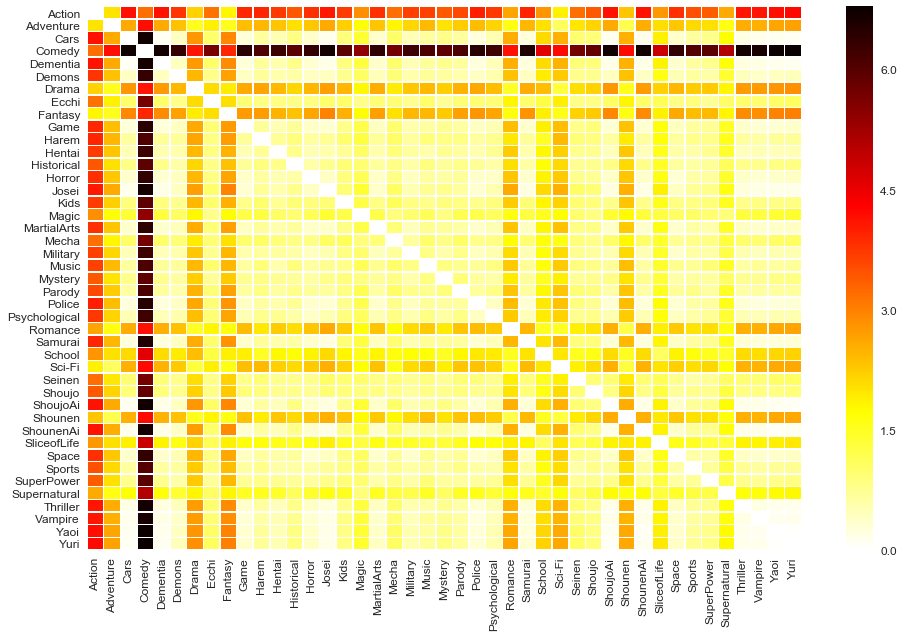

In [108]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cityblock')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

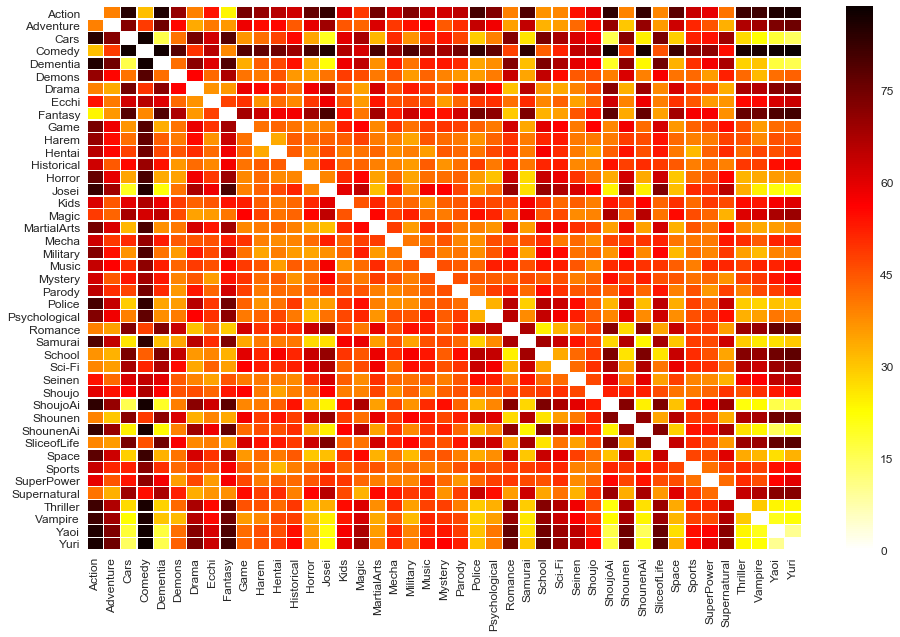

In [109]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'canberra')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

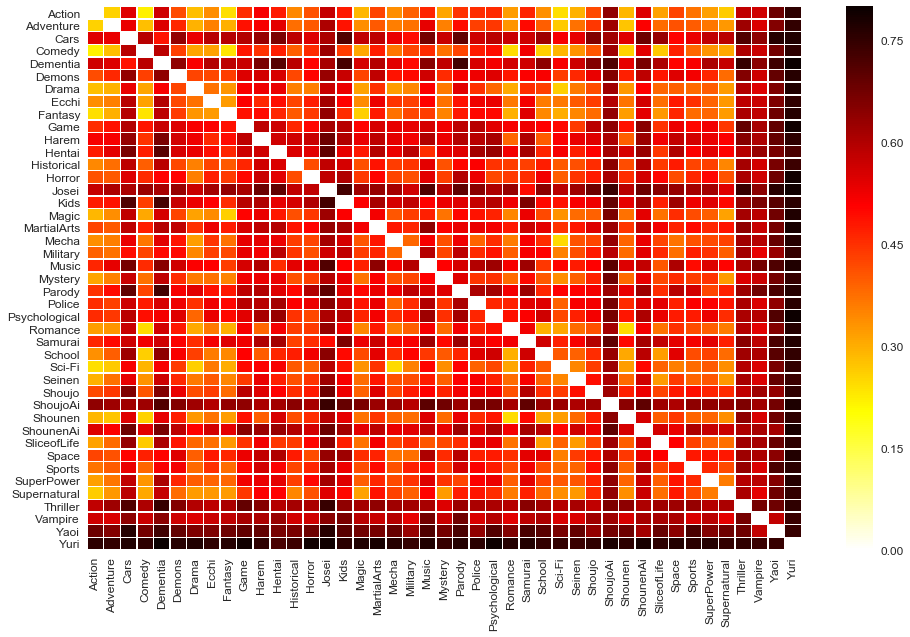

In [110]:
# using Jensen Shannon diverge, which is symeterized version of KL divergence
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def js_metric(p, q):
    # with square root it will satisfy triangle inequality
    return np.sqrt(js(p, q))

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, lambda x, y: js_metric(x, y))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

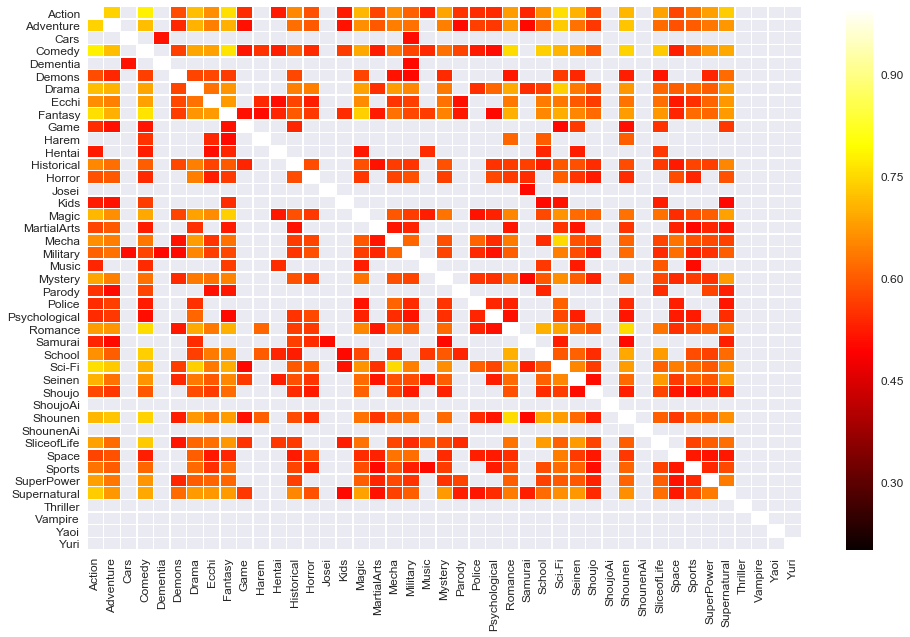

In [111]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[(1-dists_df) < 0.5] = True

sns.heatmap(1-dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot)

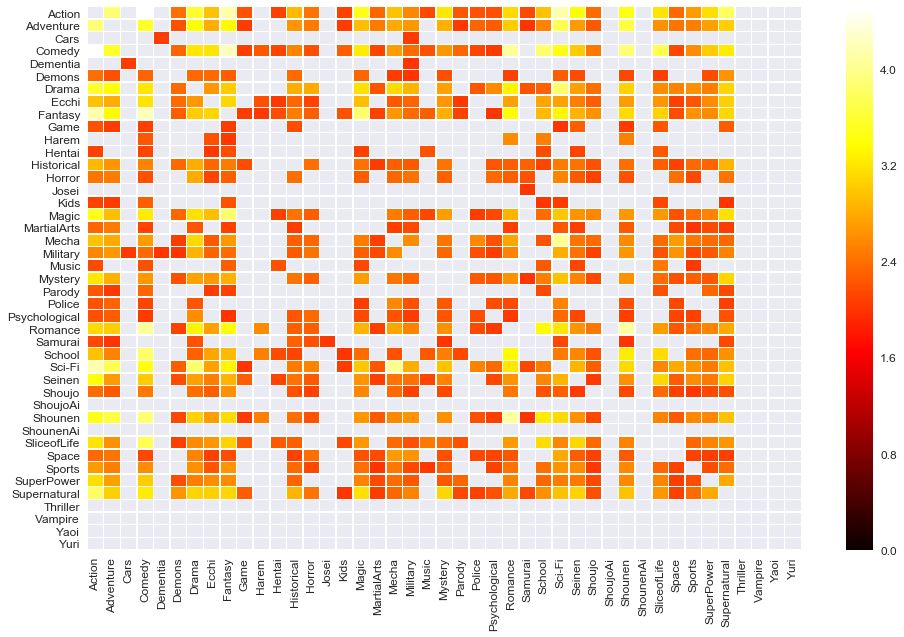

In [112]:
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 2] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

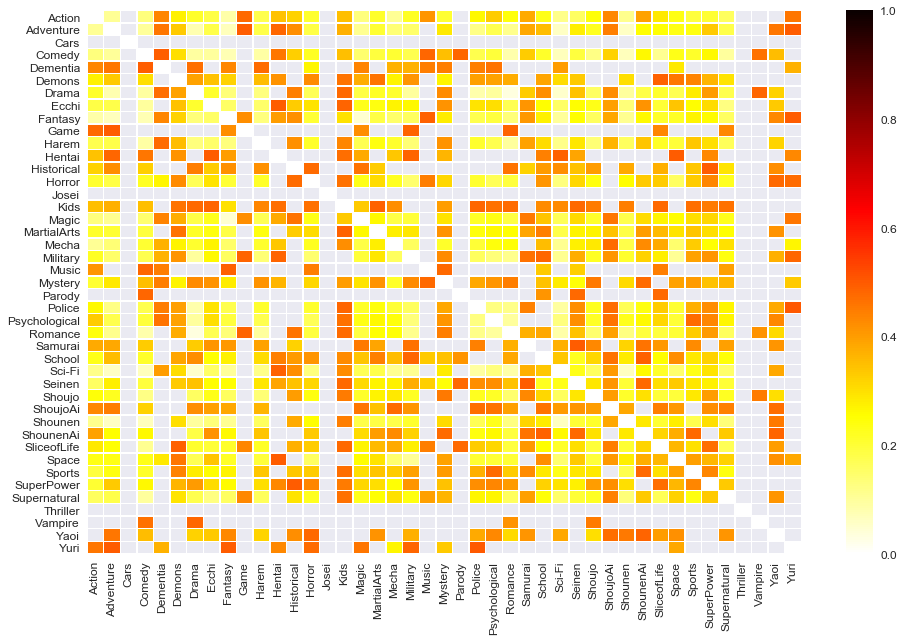

In [113]:
renaming = {x: x.replace('scoreabove8_', '') for x in above8_columns}
genres_users = users[above8_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df  > 0.5] = True

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

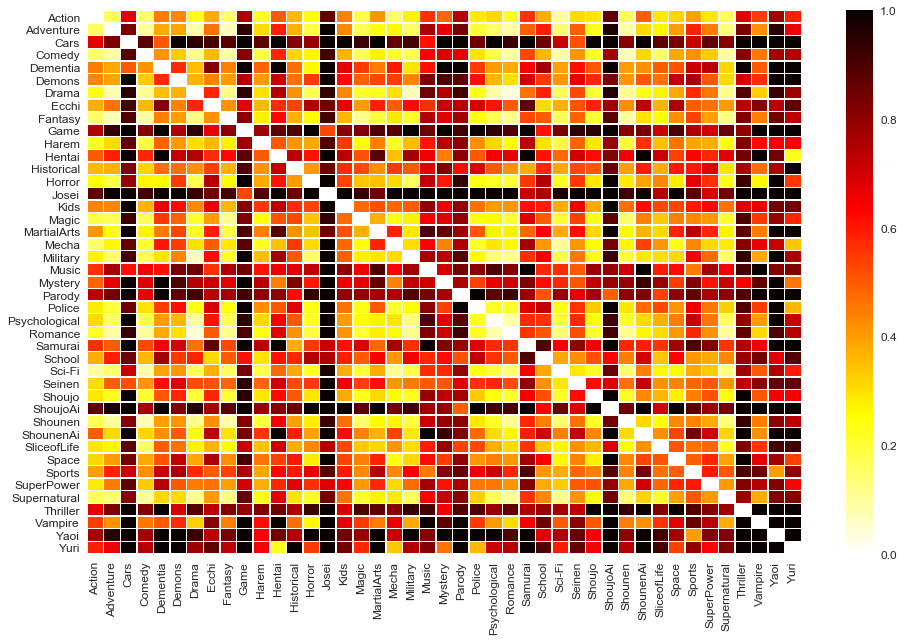

In [114]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

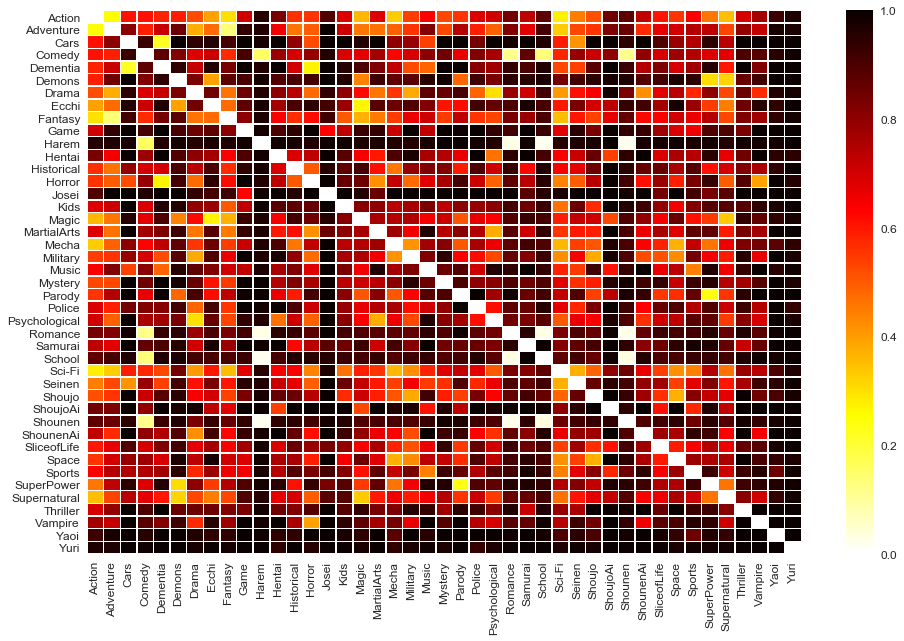

In [115]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].div(users['all_rated'], axis=0).fillna(0).rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


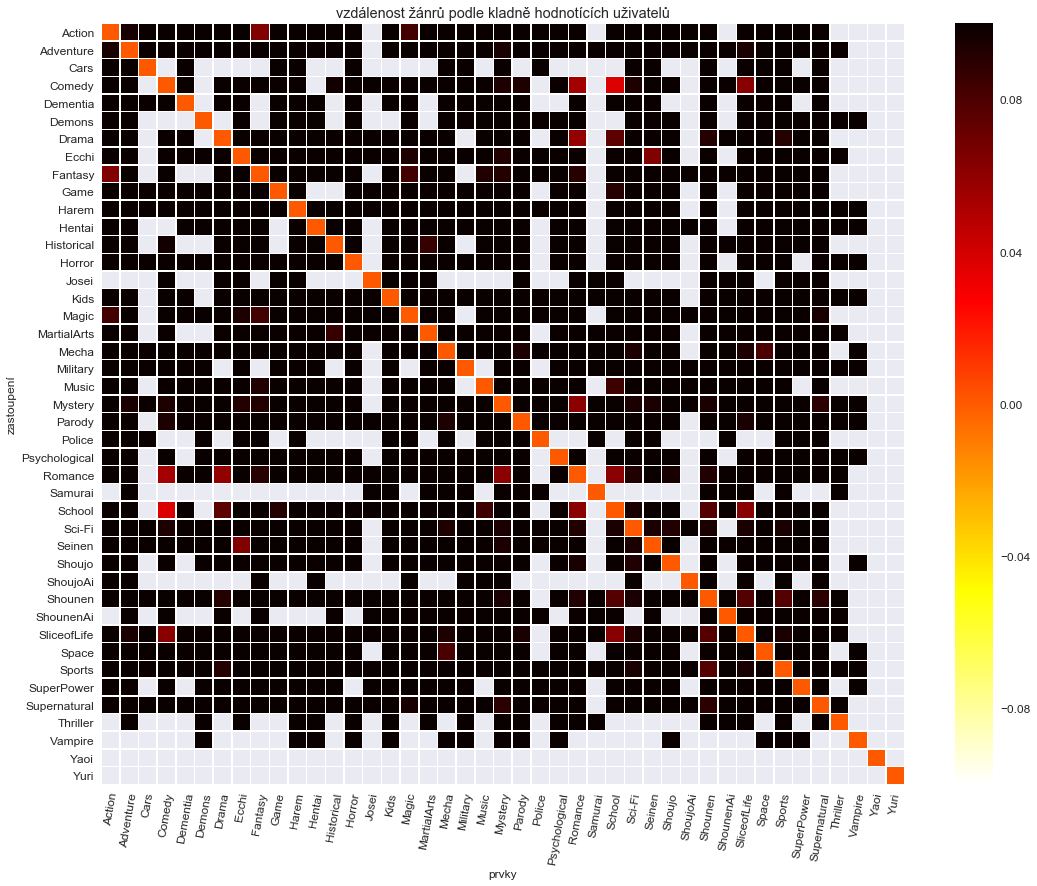

In [116]:
# NSD on 9 or more mean score
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

renaming = {x: x.replace('meanscore_', '') for x in mean_columns}
genres_users = (users[mean_columns] >= 9).rename(columns=renaming).T
dists = pdist(genres_users, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

plt.title('vzdálenost žánrů podle kladně hodnotících uživatelů')
plt.xticks(rotation=80)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-zanry-9-a-vice-heatmap.png', bbox_inches="tight")

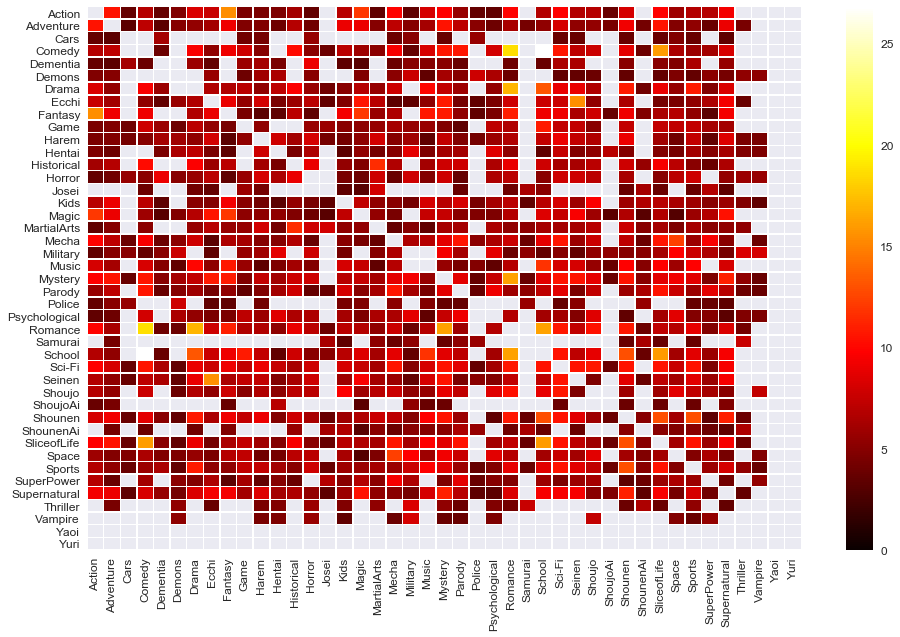

In [117]:
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 1.6] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

In [118]:
# MDS embedding for NSD
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

In [ ]:
pairs = np.array(list(combinations(genres_users.index, 2)))


# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1/dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_NSD.csv', index=False, sep=',', encoding='utf-8')